AR(p) p bic optimized


================ AR(p) — split_60 (train 0:797 | test 798:930) ================
Chosen p=2 by BIC=-2948.096

=== AR(p) (level forecasts) ===
  h= 1: MAE=0.021870  MSE=0.000833  RMSE=0.028864  MAPE=5.71%
  h= 4: MAE=0.038923  MSE=0.002269  RMSE=0.047635  MAPE=9.71%
  h=12: MAE=0.044953  MSE=0.003226  RMSE=0.056802  MAPE=10.82%


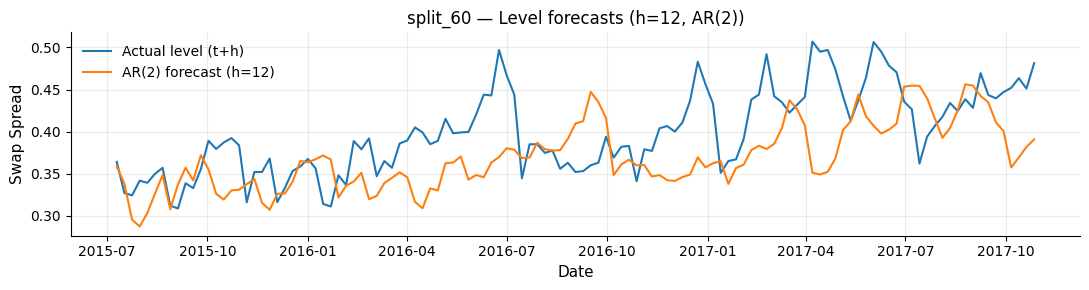

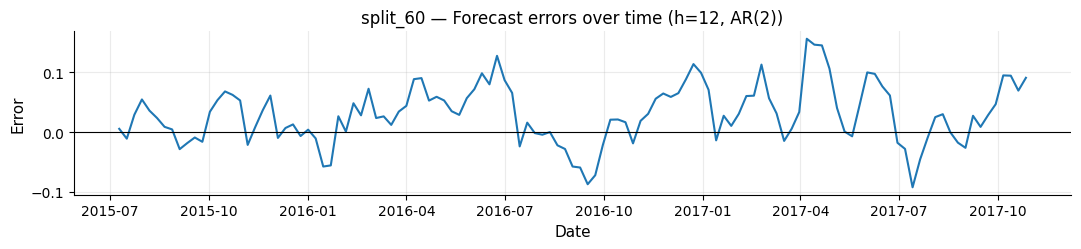


================ AR(p) — split_70 (train 0:930 | test 931:1063) ================
Chosen p=2 by BIC=-3500.495

=== AR(p) (level forecasts) ===
  h= 1: MAE=0.019924  MSE=0.000721  RMSE=0.026844  MAPE=4.37%
  h= 4: MAE=0.033253  MSE=0.001845  RMSE=0.042955  MAPE=7.09%
  h=12: MAE=0.049522  MSE=0.004025  RMSE=0.063440  MAPE=10.14%


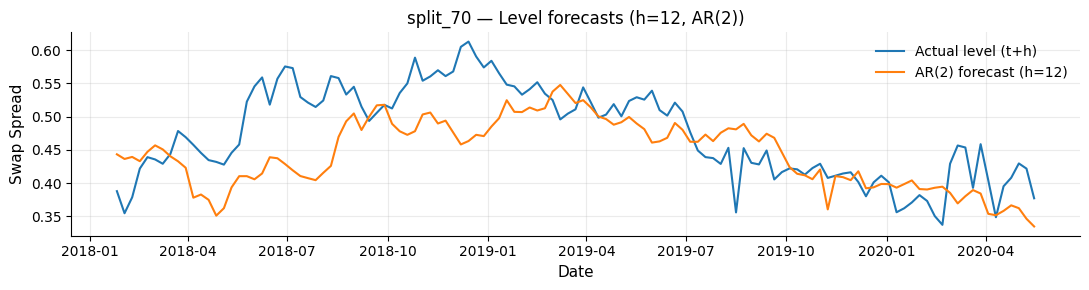

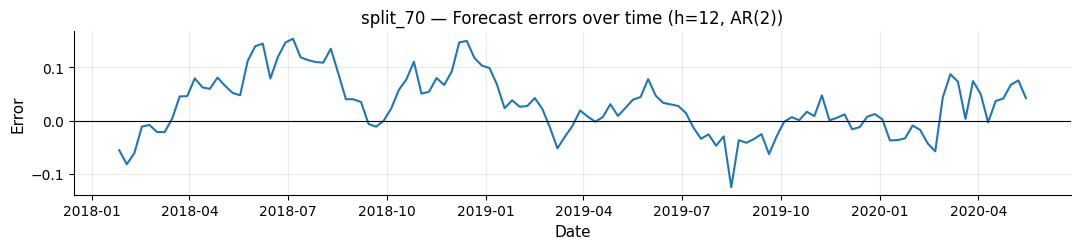


================ AR(p) — split_80 (train 0:1063 | test 1064:1196) ================
Chosen p=2 by BIC=-4067.504

=== AR(p) (level forecasts) ===
  h= 1: MAE=0.028051  MSE=0.001678  RMSE=0.040967  MAPE=5.54%
  h= 4: MAE=0.051939  MSE=0.005777  RMSE=0.076007  MAPE=9.62%
  h=12: MAE=0.092091  MSE=0.016276  RMSE=0.127575  MAPE=15.74%


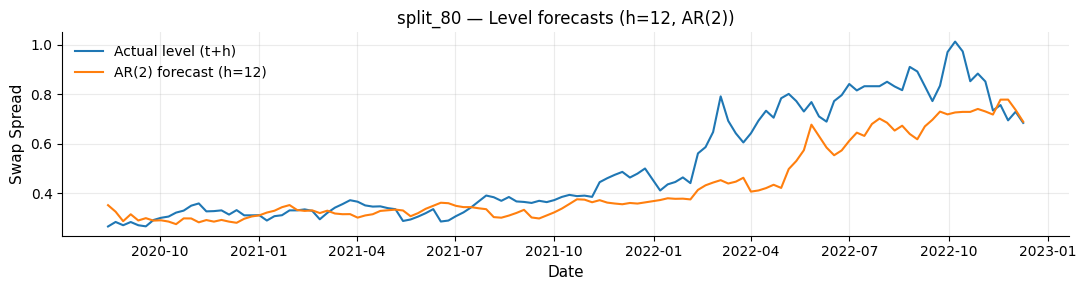

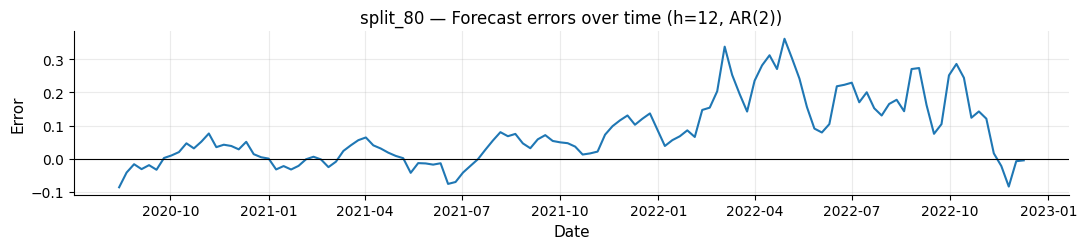


================ AR(p) — split_90 (train 0:1196 | test 1197:1330) ================
Chosen p=2 by BIC=-4536.123

=== AR(p) (level forecasts) ===
  h= 1: MAE=0.025930  MSE=0.001446  RMSE=0.038024  MAPE=166.34%
  h= 4: MAE=0.051726  MSE=0.004913  RMSE=0.070093  MAPE=142.43%
  h=12: MAE=0.092614  MSE=0.014112  RMSE=0.118794  MAPE=250.71%


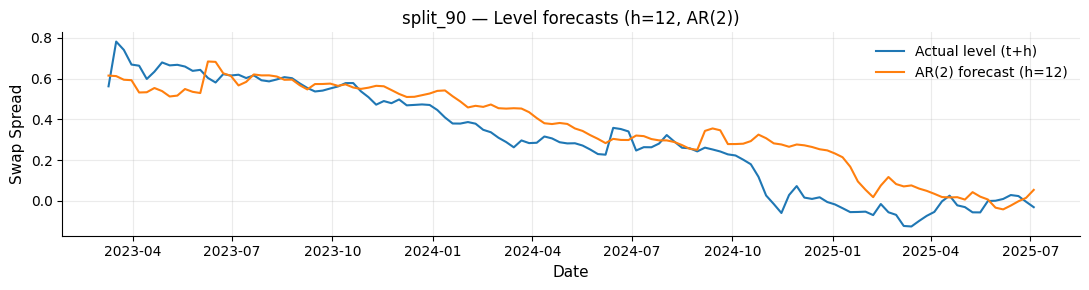

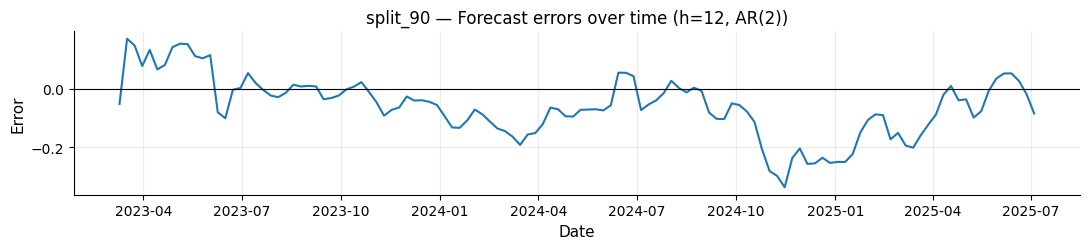

In [32]:
# ====================== AR(p) baseline with BIC model order ======================
# - Level forecasts only (no differencing, no exogs)
# - p chosen by BIC over p = 1..P_MAX for each split
# - Splits: 60→70, 70→80, 80→90, 90→100
# - Metrics: MAE, MSE, RMSE, MAPE
# - Plots: Actual vs Forecast (h=12), Errors over time (h=12)
# ================================================================================

import math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# ----------------------------- Config ------------------------------------------
PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"
DATE_COL  = "Date"
LEVEL_COL = "Swap Spread"     # level series (no differencing)
HORIZONS  = [1, 4, 12]
SPLITS    = [(0.60,0.70), (0.70,0.80), (0.80,0.90), (0.90,1.00)]
P_MAX     = 12                # you can try 24 as a sensitivity check

# ----------------------------- Load --------------------------------------------
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df = df[[DATE_COL, LEVEL_COL]].dropna().sort_values(DATE_COL).reset_index(drop=True)
dates = pd.to_datetime(df[DATE_COL].values)
y     = df[LEVEL_COL].astype(float).values
N     = len(df)

# ----------------------------- Utils -------------------------------------------
def metrics_report(y_true, y_hat):
    y_true = np.asarray(y_true, float); y_hat = np.asarray(y_hat, float)
    err  = y_true - y_hat
    mae  = float(np.mean(np.abs(err)))
    mse  = float(np.mean(err**2))
    rmse = float(np.sqrt(mse))
    mape = float(np.mean(np.abs(err) / (np.abs(y_true) + 1e-8))) * 100.0
    return dict(MAE=mae, MSE=mse, RMSE=rmse, MAPE=mape)

def print_metrics_table(title, res_dict):
    print(f"\n=== {title} ===")
    for h in HORIZONS:
        m = res_dict[h]
        print(f"  h={h:>2}: MAE={m['MAE']:.6f}  MSE={m['MSE']:.6f}  RMSE={m['RMSE']:.6f}  MAPE={m['MAPE']:.2f}%")

def fit_ar_p_bic(y_train, pmax=P_MAX):
    """
    Fit AR(p) with p in [1..pmax], select by minimum BIC.
    Returns (p_best, c, phi, bic_best, results_object).
    """
    best = dict(bic=np.inf, p=None, res=None)
    for p in range(1, pmax+1):
        # Need at least p+1 points
        if len(y_train) <= p + 1:
            break
        try:
            res = AutoReg(y_train, lags=p, trend='c', old_names=False).fit()
            bic = float(res.bic)
            if bic < best["bic"]:
                best = dict(bic=bic, p=p, res=res)
        except Exception:
            continue
    if best["res"] is None:
        raise RuntimeError("Failed to fit any AR(p) model. Try lowering P_MAX.")
    res = best["res"]
    params = res.params
    # params index: 'const', 'y.L1', 'y.L2', ...
    c = float(params[0])
    phi = np.array(params[1:], float)
    return best["p"], c, phi, best["bic"], res

def ar_p_forecast_h(c, phi, history_descending, h):
    """
    h-step forecast for AR(p):
      y_{t+1} = c + sum_{i=1..p} phi_i * y_{t+1-i}
    history_descending: [y_t, y_{t-1}, ..., y_{t-p+1}] (length >= p)
    """
    p = len(phi)
    buf = list(history_descending[:p])  # ensure length p
    for step in range(1, h+1):
        nxt = c
        # use the most recent p values in buf (descending)
        for i in range(1, p+1):
            nxt += phi[i-1] * buf[i-1]  # buf[0]=y_t (or last simulated), buf[1]=y_{t-1}, ...
        # prepend new value (keep descending order)
        buf = [nxt] + buf[:p-1]
    return buf[0]  # y_{t+h|t}

# ----------------------------- Main --------------------------------------------
for (a,b) in SPLITS:
    tr_end = int(math.floor(a*N))        # train: 0..tr_end-1
    te_end = int(math.floor(b*N))        # test anchors in [tr_end .. te_end-h]
    print(f"\n================ AR(p) — split_{int(a*100)} (train 0:{tr_end-1} | test {tr_end}:{te_end-1}) ================")

    y_train = y[:tr_end].copy()
    # Choose p by BIC
    p_best, c, phi, bic, res = fit_ar_p_bic(y_train, pmax=P_MAX)
    print(f"Chosen p={p_best} by BIC={bic:.3f}")

    # Anchors such that t+h exists and t in [tr_end, te_end - h]
    res_by_h = {}
    for h in HORIZONS:
        if te_end - h <= tr_end:
            print(f"  h={h}: not enough test points in this split.")
            continue
        anchors = np.arange(tr_end, te_end - h)
        y_true  = y[anchors + h]

        y_hat = np.empty_like(y_true)
        p = len(phi)
        for idx, t in enumerate(anchors):
            # Gather last p values as [y_t, y_{t-1}, ..., y_{t-p+1}]
            if t - (p-1) < 0:  # guard
                y_hat[idx] = np.nan
                continue
            hist = y[t : t - p : -1] if p > 1 else np.array([y[t]])
            if len(hist) < p:
                # pad with earliest available (rare at very beginning)
                pad = [y[0]] * (p - len(hist))
                hist = np.concatenate([hist, pad])
            y_hat[idx] = ar_p_forecast_h(c, phi, hist, h)

        # drop any NaNs that might sneak in at very beginning
        mask = ~np.isnan(y_hat)
        y_true = y_true[mask]; y_hat = y_hat[mask]

        res_by_h[h] = metrics_report(y_true, y_hat)
        # Keep arrays for plotting (use h=12 below)
        if h == 12:
            dates_plot = dates[anchors[mask] + h]
            y_true_plot = y_true
            y_hat_plot  = y_hat
            err_plot    = y_true_plot - y_hat_plot

    # Print metrics
    print_metrics_table("AR(p) (level forecasts)", res_by_h)

    # --------- Plots (for h=12) ---------
    if 12 in res_by_h:
        plt.figure(figsize=(11,3))
        plt.plot(dates_plot, y_true_plot, label="Actual level (t+h)")
        plt.plot(dates_plot, y_hat_plot,  label=f"AR({p_best}) forecast (h=12)")
        plt.title(f"split_{int(a*100)} — Level forecasts (h=12, AR({p_best}))")
        plt.xlabel("Date"); plt.ylabel(LEVEL_COL); plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(11,2.6))
        plt.plot(dates_plot, err_plot)
        plt.axhline(0, linewidth=0.8, color='black')
        plt.title(f"split_{int(a*100)} — Forecast errors over time (h=12, AR({p_best}))")
        plt.xlabel("Date"); plt.ylabel("Error"); plt.tight_layout(); plt.show()


Saving predictions


================ AR(p) — split_60 (train 0:797 | test 798:930) ================
Chosen p=2 by BIC=-2948.096
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_60_h1.csv
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_60_h4.csv
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_60_h12.csv


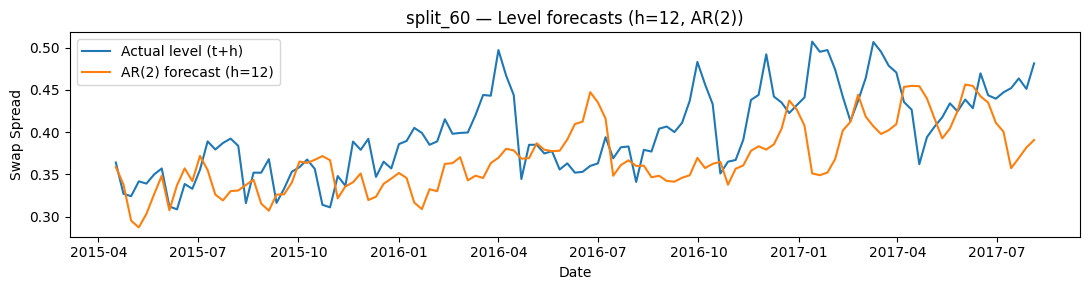

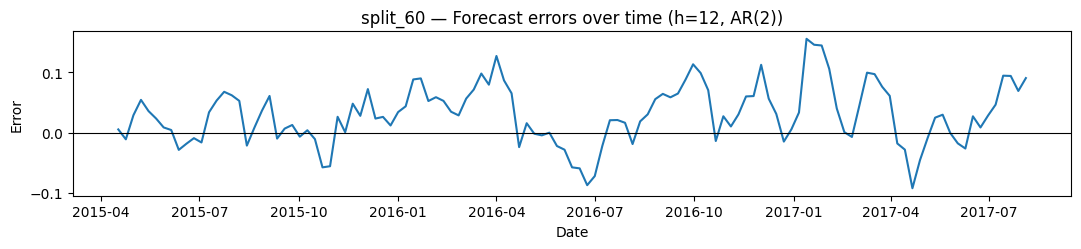


=== AR(p) (level forecasts) — split_60 ===
  h= 1: MAE=0.021870  MSE=0.000833  RMSE=0.028864  MAPE=5.71%
  h= 4: MAE=0.038923  MSE=0.002269  RMSE=0.047635  MAPE=9.71%
  h=12: MAE=0.044953  MSE=0.003226  RMSE=0.056802  MAPE=10.82%

================ AR(p) — split_70 (train 0:930 | test 931:1063) ================
Chosen p=2 by BIC=-3500.495
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_70_h1.csv
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_70_h4.csv
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_70_h12.csv


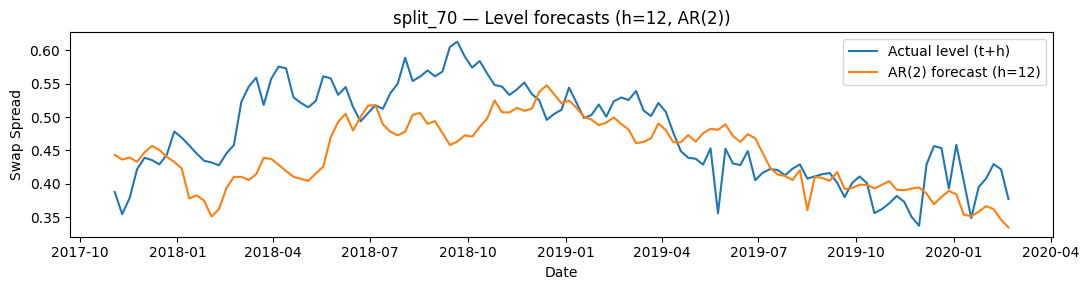

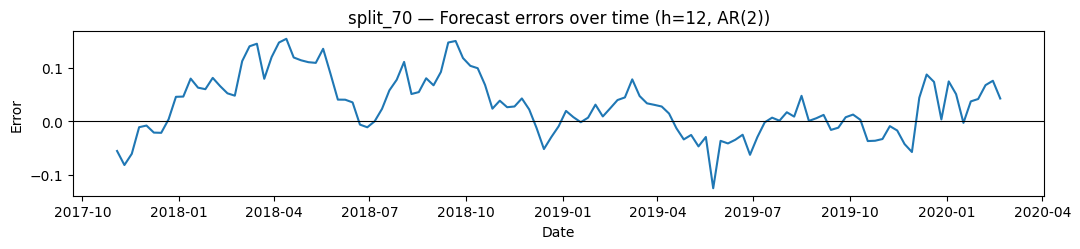


=== AR(p) (level forecasts) — split_70 ===
  h= 1: MAE=0.019924  MSE=0.000721  RMSE=0.026844  MAPE=4.37%
  h= 4: MAE=0.033253  MSE=0.001845  RMSE=0.042955  MAPE=7.09%
  h=12: MAE=0.049522  MSE=0.004025  RMSE=0.063440  MAPE=10.14%

================ AR(p) — split_80 (train 0:1063 | test 1064:1196) ================
Chosen p=2 by BIC=-4067.504
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_80_h1.csv
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_80_h4.csv
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_80_h12.csv


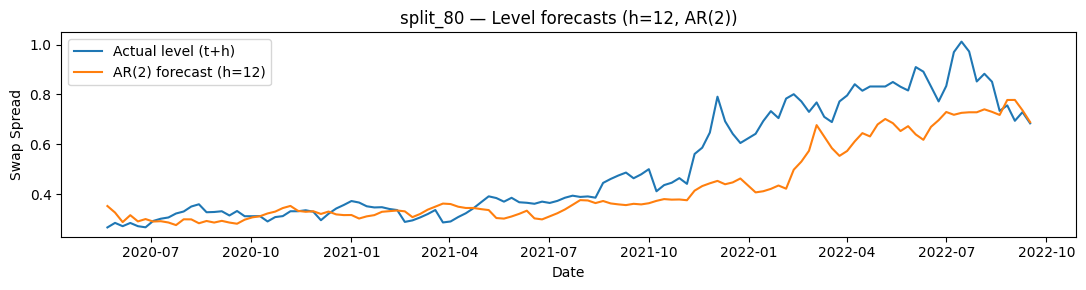

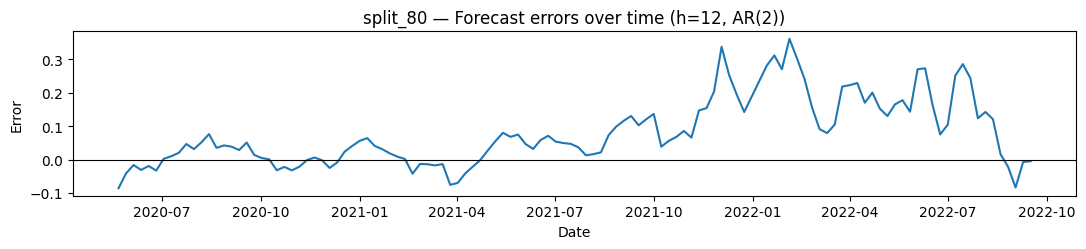


=== AR(p) (level forecasts) — split_80 ===
  h= 1: MAE=0.028051  MSE=0.001678  RMSE=0.040967  MAPE=5.54%
  h= 4: MAE=0.051939  MSE=0.005777  RMSE=0.076007  MAPE=9.62%
  h=12: MAE=0.092091  MSE=0.016276  RMSE=0.127575  MAPE=15.74%

================ AR(p) — split_90 (train 0:1196 | test 1197:1330) ================
Chosen p=2 by BIC=-4536.123
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_90_h1.csv
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_90_h4.csv
Saved predictions: /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_90_h12.csv


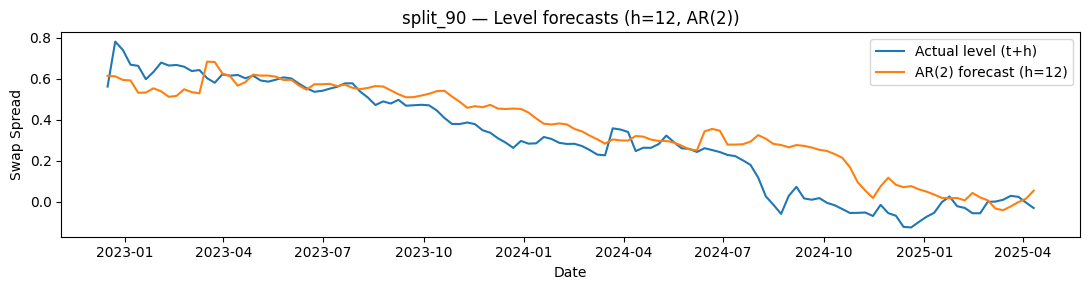

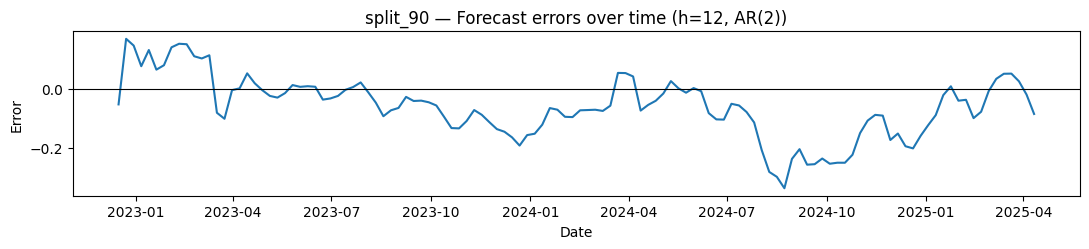


=== AR(p) (level forecasts) — split_90 ===
  h= 1: MAE=0.025930  MSE=0.001446  RMSE=0.038024  MAPE=166.34%
  h= 4: MAE=0.051726  MSE=0.004913  RMSE=0.070093  MAPE=142.43%
  h=12: MAE=0.092614  MSE=0.014112  RMSE=0.118794  MAPE=250.71%

All AR(p) predictions combined → /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_all_predictions.csv
Per-split AR(p) parameters → /Users/anwarouni/Downloads/Thesis/Output/AR predictions/arp_split_params.csv

Done.


In [73]:
# ====================== AR(p) baseline with BIC model order (with per-fold×h saves) ======================
# - Level forecasts only (no differencing, no exogs)
# - p chosen by BIC over p = 1..P_MAX for each split
# - Splits: 60→70, 70→80, 80→90, 90→100
# - Metrics: MAE, MSE, RMSE, MAPE
# - Plots: Actual vs Forecast (h=12), Errors over time (h=12)
# - Saves per split×h CSVs + combined CSVs ready for Diebold–Mariano
# ========================================================================================================

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# ----------------------------- Config ------------------------------------------
PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"
DATE_COL  = "Date"
LEVEL_COL = "Swap Spread"     # level series (no differencing)
HORIZONS  = [1, 4, 12]
SPLITS    = [(0.60,0.70), (0.70,0.80), (0.80,0.90), (0.90,1.00)]
P_MAX     = 12                # you can try 24 as a sensitivity check

# Save folder (same as AR(1) but with arp_* filenames)
OUT_DIR = "/Users/anwarouni/Downloads/Thesis/Output/AR predictions"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------- Load --------------------------------------------
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df = df[[DATE_COL, LEVEL_COL]].dropna().sort_values(DATE_COL).reset_index(drop=True)
dates = pd.to_datetime(df[DATE_COL].values)
y     = df[LEVEL_COL].astype(float).values
N     = len(df)

# ----------------------------- Utils -------------------------------------------
def metrics_report(y_true, y_hat):
    y_true = np.asarray(y_true, float); y_hat = np.asarray(y_hat, float)
    err  = y_true - y_hat
    mae  = float(np.mean(np.abs(err)))
    mse  = float(np.mean(err**2))
    rmse = float(np.sqrt(mse))
    mape = float(np.mean(np.abs(err) / (np.abs(y_true) + 1e-8))) * 100.0
    return dict(MAE=mae, MSE=mse, RMSE=rmse, MAPE=mape)

def print_metrics_table(title, res_dict):
    print(f"\n=== {title} ===")
    for h in HORIZONS:
        if h in res_dict:
            m = res_dict[h]
            print(f"  h={h:>2}: MAE={m['MAE']:.6f}  MSE={m['MSE']:.6f}  RMSE={m['RMSE']:.6f}  MAPE={m['MAPE']:.2f}%")

def fit_ar_p_bic(y_train, pmax=P_MAX):
    """
    Fit AR(p) with p in [1..pmax], select by minimum BIC.
    Returns (p_best, c, phi_vec, bic_best, results_object).
    """
    best = dict(bic=np.inf, p=None, res=None)
    for p in range(1, pmax+1):
        # Need at least p+1 points
        if len(y_train) <= p + 1:
            break
        try:
            res = AutoReg(y_train, lags=p, trend='c', old_names=False).fit()
            bic = float(res.bic)
            if bic < best["bic"]:
                best = dict(bic=bic, p=p, res=res)
        except Exception:
            continue
    if best["res"] is None:
        raise RuntimeError("Failed to fit any AR(p) model. Try lowering P_MAX.")
    res = best["res"]
    params = np.asarray(res.params, dtype=float)
    c = float(params[0])
    phi = np.array(params[1:], float)  # length p_best
    return best["p"], c, phi, best["bic"], res

def ar_p_forecast_h(c, phi, history_descending, h):
    """
    h-step forecast for AR(p):
      y_{t+1} = c + sum_{i=1..p} phi_i * y_{t+1-i}
    history_descending: [y_t, y_{t-1}, ..., y_{t-p+1}] (length >= p)
    """
    p = len(phi)
    buf = list(history_descending[:p])  # ensure length p
    for _ in range(h):
        nxt = c
        for i in range(1, p+1):
            nxt += phi[i-1] * buf[i-1]  # buf[0]=y_t, buf[1]=y_{t-1}, ...
        buf = [nxt] + buf[:p-1]        # prepend nxt, keep length p
    return buf[0]  # y_{t+h|t}

# ----------------------------- Main --------------------------------------------
all_files = []
all_predictions = []
params_rows = []

for (a,b) in SPLITS:
    tr_end = int(math.floor(a*N))        # train: 0..tr_end-1
    te_end = int(math.floor(b*N))        # test anchors in [tr_end .. te_end-h]
    split_tag = f"split_{int(a*100)}"
    print(f"\n================ AR(p) — {split_tag} (train 0:{tr_end-1} | test {tr_end}:{te_end-1}) ================")

    y_train = y[:tr_end].copy()
    # Choose p by BIC
    p_best, c, phi, bic, res = fit_ar_p_bic(y_train, pmax=P_MAX)
    print(f"Chosen p={p_best} by BIC={bic:.3f}")

    # keep param row
    pr = {"split": split_tag, "p": p_best, "BIC": bic, "c": c}
    # expand phi_1..phi_P_MAX for rectangular CSV
    for i in range(1, P_MAX+1):
        pr[f"phi_{i}"] = phi[i-1] if i <= len(phi) else np.nan
    params_rows.append(pr)

    # Anchors such that t+h exists and t in [tr_end, te_end - h]
    res_by_h = {}
    for h in HORIZONS:
        if te_end - h <= tr_end:
            print(f"  h={h}: not enough test points in this split.")
            continue
        anchors = np.arange(tr_end, te_end - h)
        y_true  = y[anchors + h]

        # Compute forecasts
        y_hat = np.empty_like(y_true, dtype=float)
        p = len(phi)
        for idx, t in enumerate(anchors):
            # Gather last p values as [y_t, y_{t-1}, ..., y_{t-p+1}]
            if t - (p-1) < 0:
                y_hat[idx] = np.nan
                continue
            # Fast slice in descending order
            hist = y[t : t - p : -1] if p > 1 else np.array([y[t]])
            if len(hist) < p:
                hist = np.pad(hist, (0, p - len(hist)), mode='edge')  # pad if ever needed
            y_hat[idx] = ar_p_forecast_h(c, phi, hist, h)

        # drop any NaNs (rare at very beginning)
        mask = ~np.isnan(y_hat)
        anchors = anchors[mask]
        y_true  = y_true[mask]
        y_t     = y[anchors]
        y_hat   = y_hat[mask]
        dates_a = dates[anchors]

        err = y_true - y_hat
        res_by_h[h] = metrics_report(y_true, y_hat)

        # -------- Save per split × horizon CSV for DM tests --------
        out_df = pd.DataFrame({
            "Date":     pd.to_datetime(dates_a),  # anchor date t (same convention as AR(1) saver)
            "split":    split_tag,
            "horizon":  h,
            "t_anchor": anchors,
            "y_t":      y_t,
            "y_true":   y_true,   # y_{t+h}
            "y_hat":    y_hat,
            "error":    err,
            "p":        p_best,
            "c":        c,
        })
        # add phi_1..phi_P_MAX columns
        for i in range(1, P_MAX+1):
            out_df[f"phi_{i}"] = phi[i-1] if i <= len(phi) else np.nan

        fname = os.path.join(OUT_DIR, f"arp_{split_tag}_h{h}.csv")
        out_df.to_csv(fname, index=False)
        all_files.append(fname)
        all_predictions.append(out_df)
        print(f"Saved predictions: {fname}")

        # ---- Plots (h=12) same as your script ----
        if h == 12 and len(out_df) > 0:
            plt.figure(figsize=(11,3))
            plt.plot(dates_a, y_true, label="Actual level (t+h)")
            plt.plot(dates_a, y_hat,  label=f"AR({p_best}) forecast (h=12)")
            plt.title(f"{split_tag} — Level forecasts (h=12, AR({p_best}))")
            plt.xlabel("Date"); plt.ylabel(LEVEL_COL); plt.legend(); plt.tight_layout(); plt.show()

            plt.figure(figsize=(11,2.6))
            plt.plot(dates_a, err)
            plt.axhline(0, linewidth=0.8, color='black')
            plt.title(f"{split_tag} — Forecast errors over time (h=12, AR({p_best}))")
            plt.xlabel("Date"); plt.ylabel("Error"); plt.tight_layout(); plt.show()

    # Metrics table per split
    print_metrics_table(f"AR(p) (level forecasts) — {split_tag}", res_by_h)

# ----------------- Save combined predictions & parameters -----------------
if len(all_predictions) > 0:
    df_all = pd.concat(all_predictions, ignore_index=True)
    combined_path = os.path.join(OUT_DIR, "arp_all_predictions.csv")
    df_all.to_csv(combined_path, index=False)
    print(f"\nAll AR(p) predictions combined → {combined_path}")

if len(params_rows) > 0:
    df_params = pd.DataFrame(params_rows)
    params_path = os.path.join(OUT_DIR, "arp_split_params.csv")
    df_params.to_csv(params_path, index=False)
    print(f"Per-split AR(p) parameters → {params_path}")

print("\nDone.")


AR(1) good


=========== AR(1) LEVEL — split_60 (train 0:797 | test 798:930) ===========


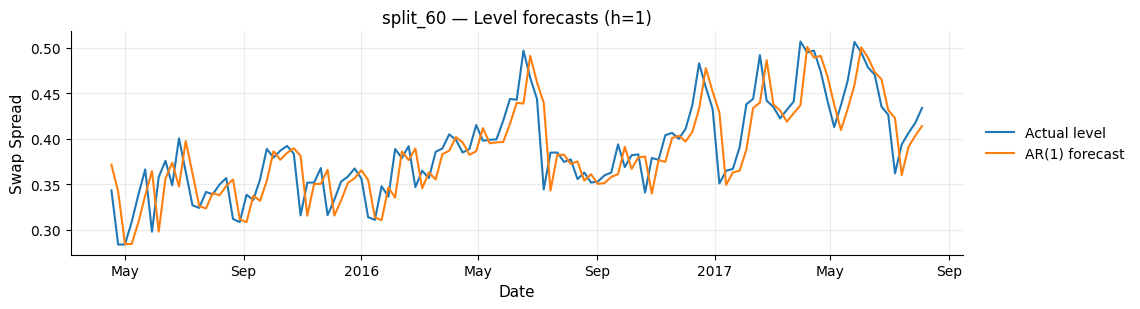

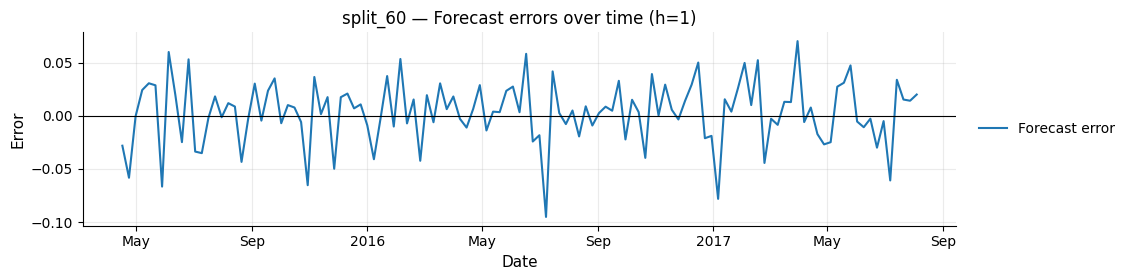

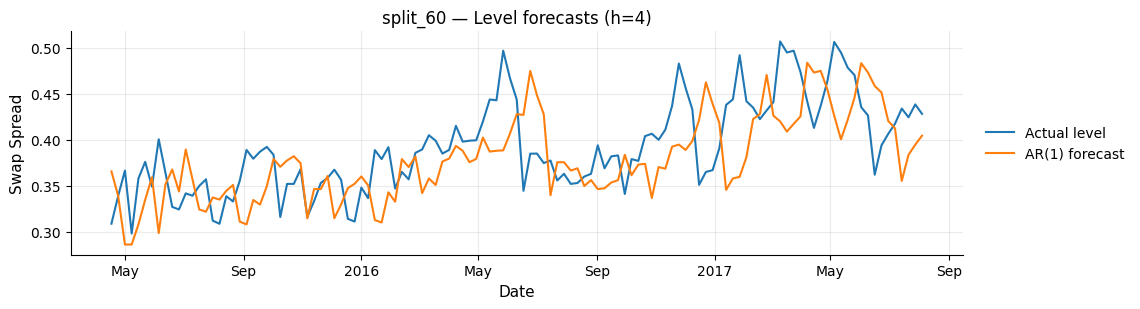

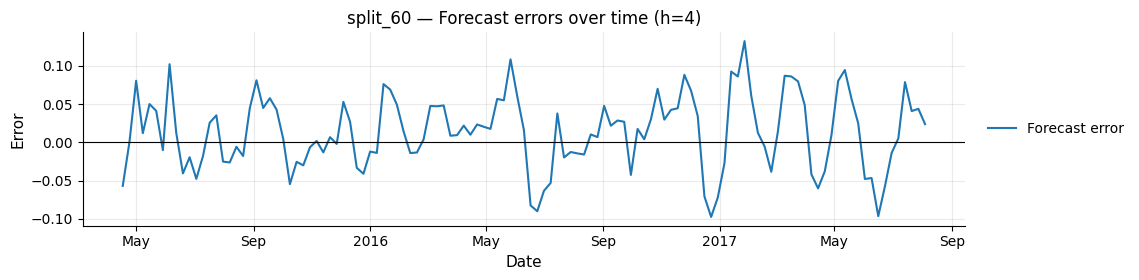

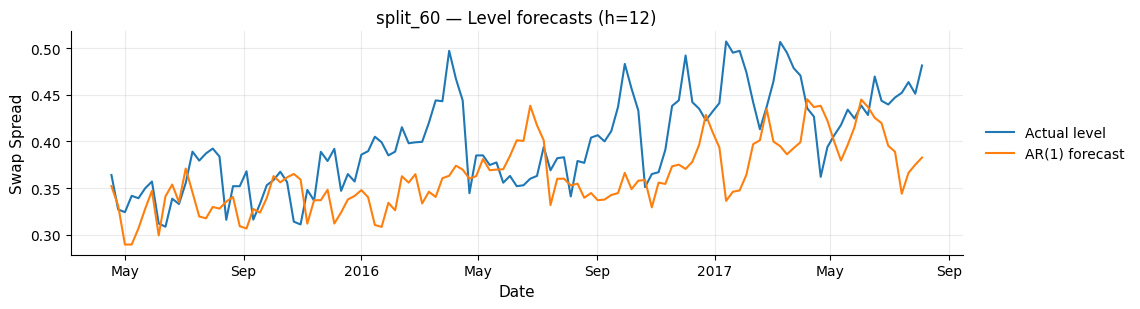

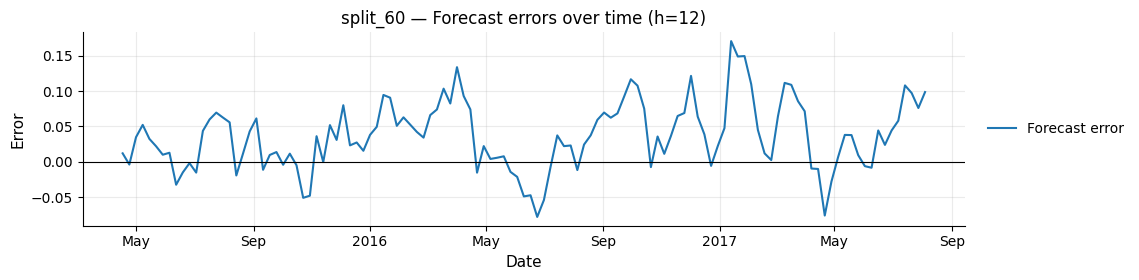


=== AR(1) on LEVEL — metrics (level forecasts) ===
  h=1: MAE=0.022543  MSE=0.000875  RMSE=0.029574  MAPE=5.94%  sMAPE=5.91%  MFE=0.003034
  h=4: MAE=0.040408  MSE=0.002449  RMSE=0.049484  MAPE=10.10%  sMAPE=10.34%  MFE=0.013341
  h=12: MAE=0.047535  MSE=0.003603  RMSE=0.060026  MAPE=11.38%  sMAPE=12.23%  MFE=0.036616

=========== AR(1) LEVEL — split_70 (train 0:930 | test 931:1063) ===========


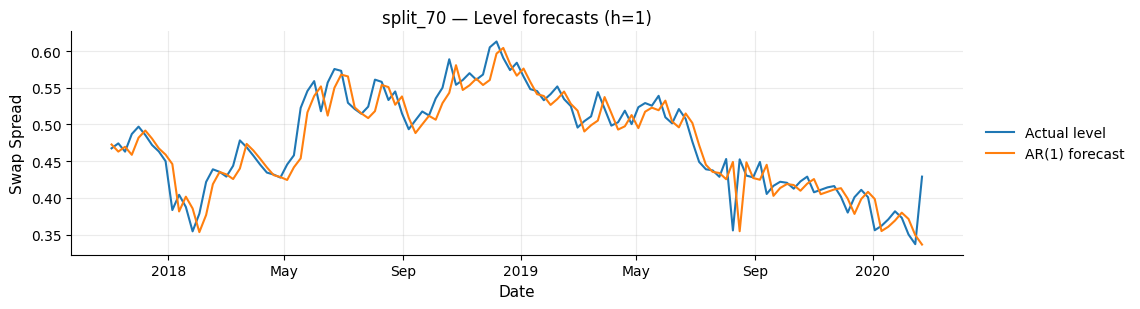

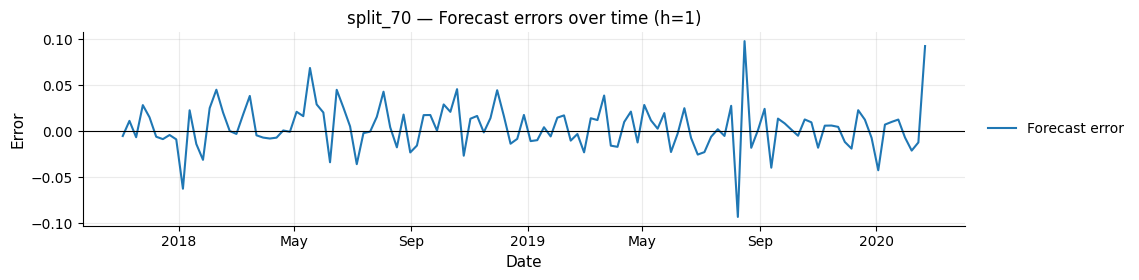

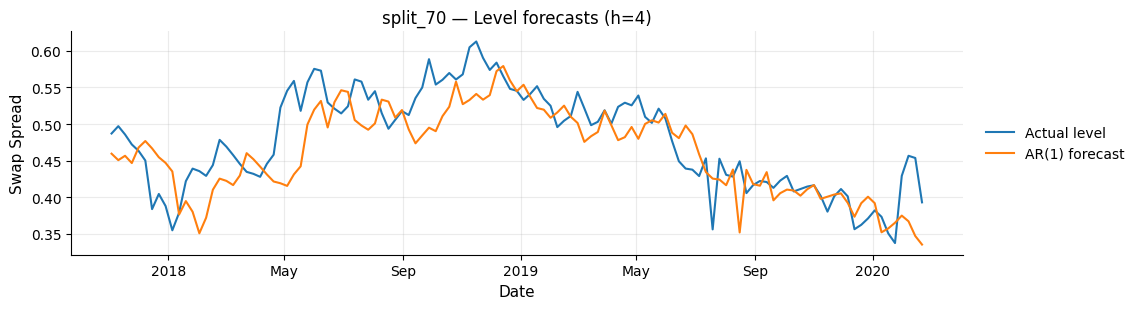

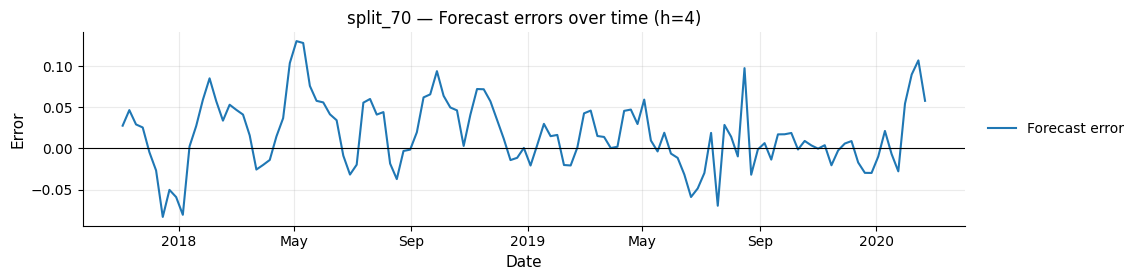

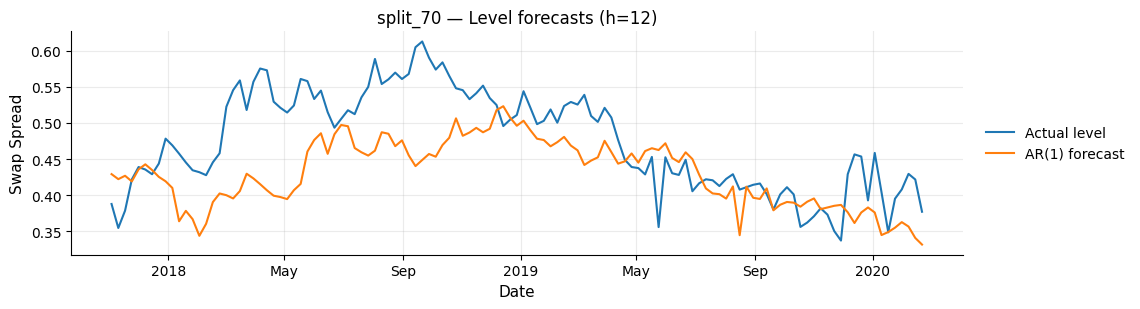

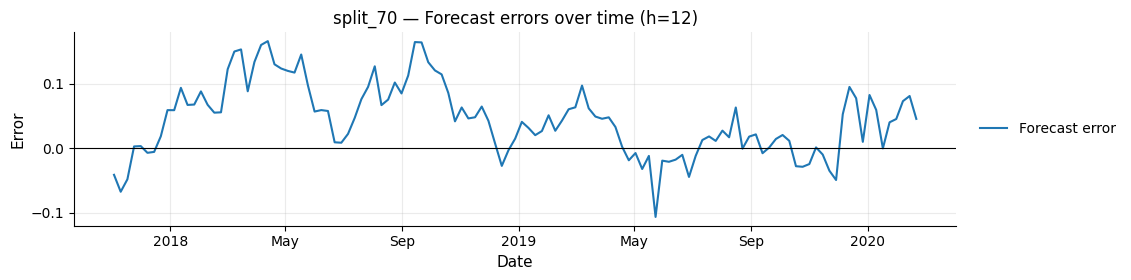


=== AR(1) on LEVEL — metrics (level forecasts) ===
  h=1: MAE=0.018470  MSE=0.000652  RMSE=0.025534  MAPE=3.97%  sMAPE=4.00%  MFE=0.004390
  h=4: MAE=0.034142  MSE=0.001965  RMSE=0.044326  MAPE=7.13%  sMAPE=7.36%  MFE=0.017079
  h=12: MAE=0.055762  MSE=0.005003  RMSE=0.070733  MAPE=11.22%  sMAPE=12.07%  MFE=0.044377

=========== AR(1) LEVEL — split_80 (train 0:1063 | test 1064:1196) ===========


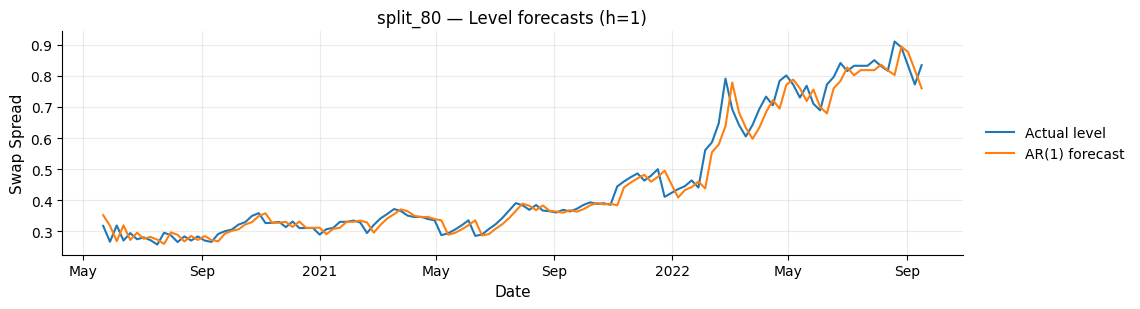

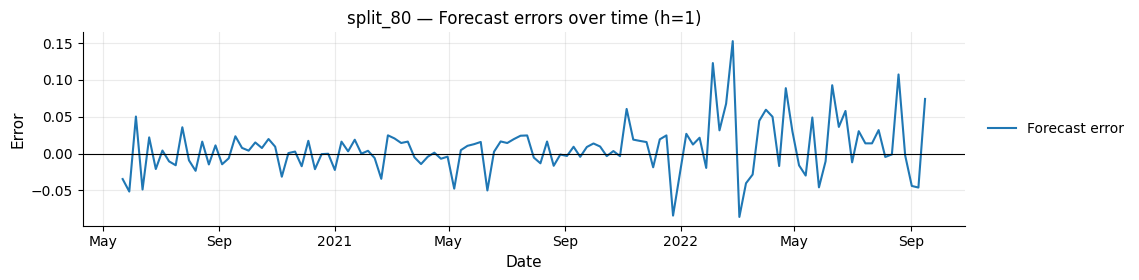

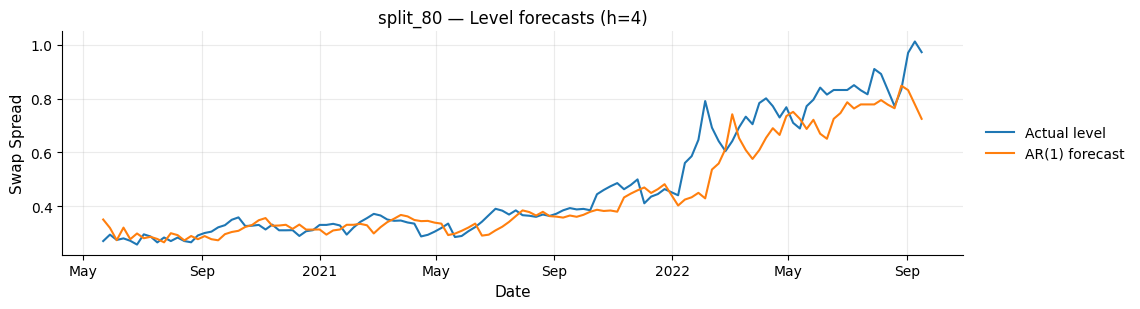

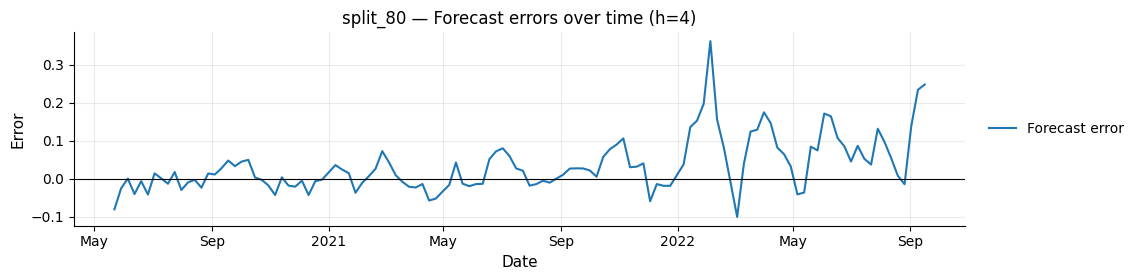

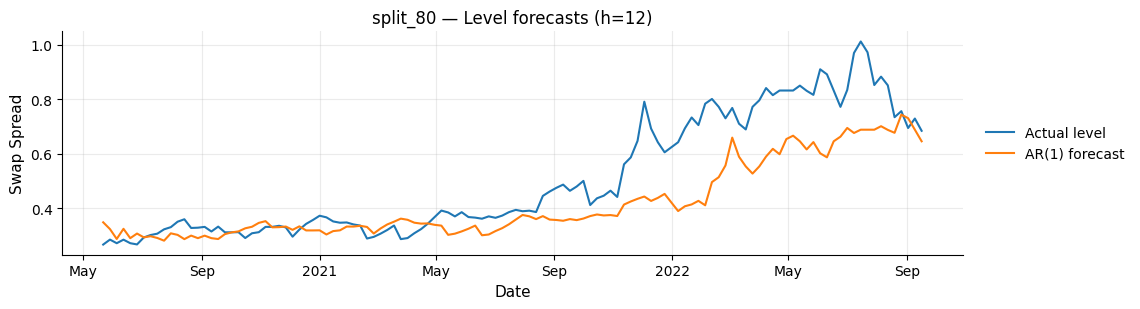

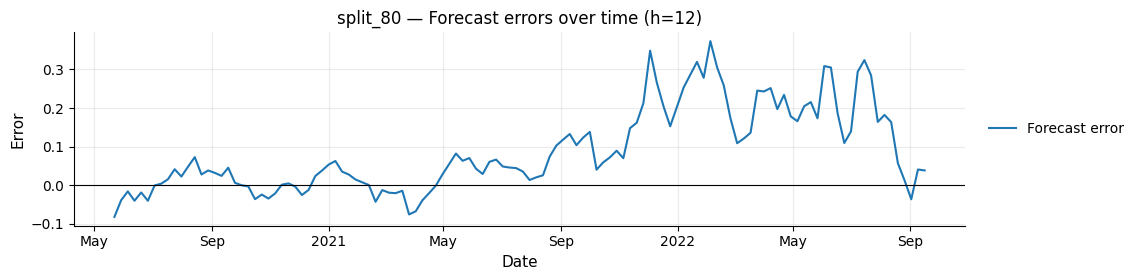


=== AR(1) on LEVEL — metrics (level forecasts) ===
  h=1: MAE=0.024965  MSE=0.001302  RMSE=0.036078  MAPE=5.39%  sMAPE=5.42%  MFE=0.007283
  h=4: MAE=0.051898  MSE=0.006029  RMSE=0.077650  MAPE=9.77%  sMAPE=10.31%  MFE=0.033605
  h=12: MAE=0.099864  MSE=0.019347  RMSE=0.139094  MAPE=16.61%  sMAPE=18.67%  MFE=0.087647

=========== AR(1) LEVEL — split_90 (train 0:1196 | test 1197:1330) ===========


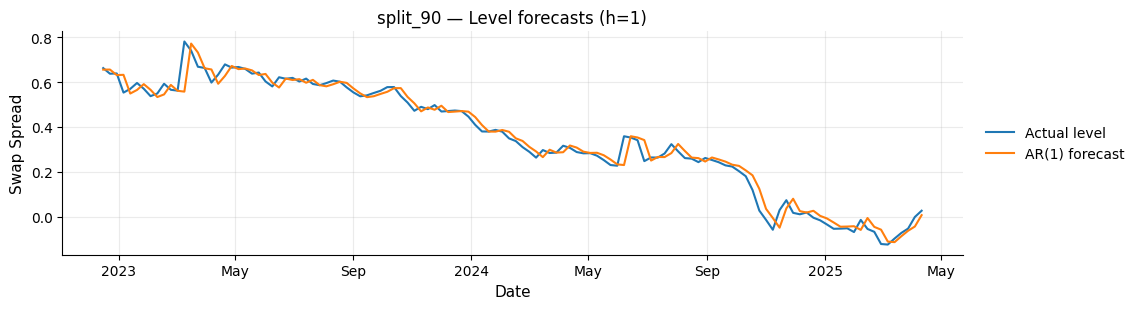

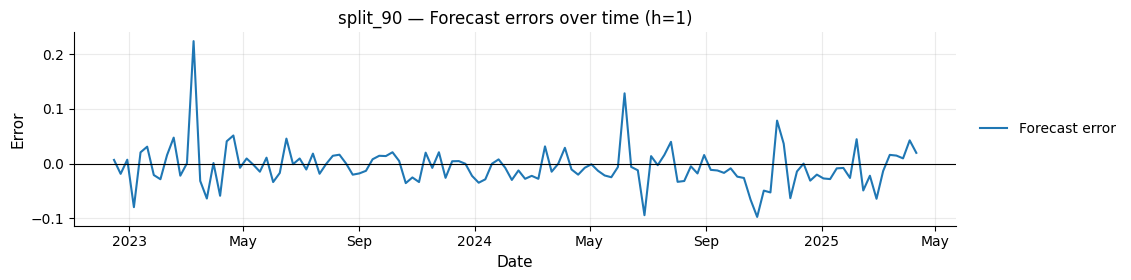

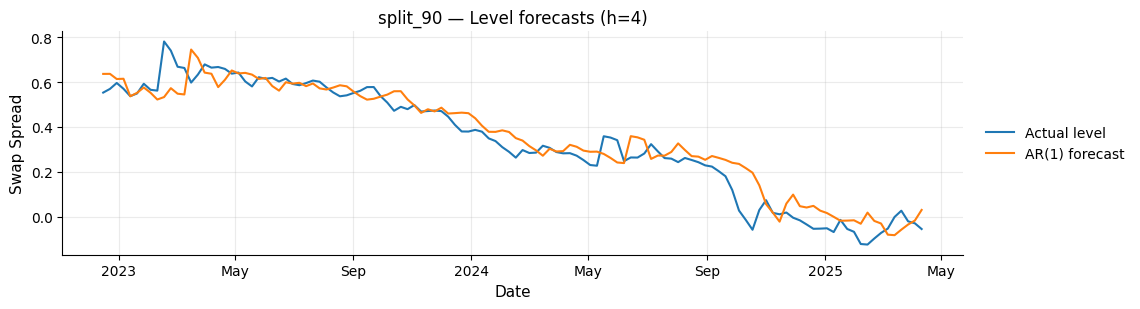

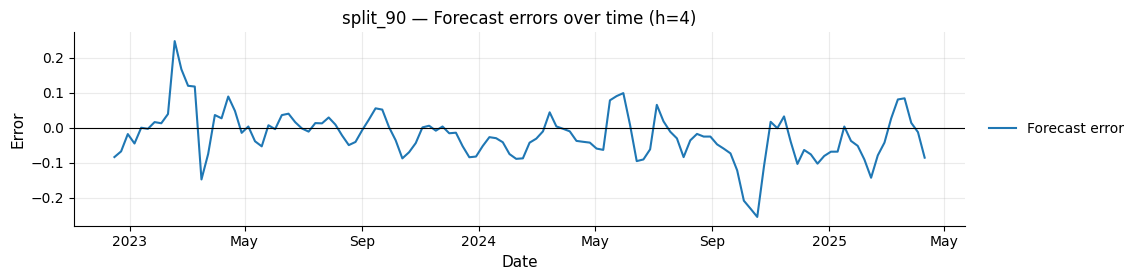

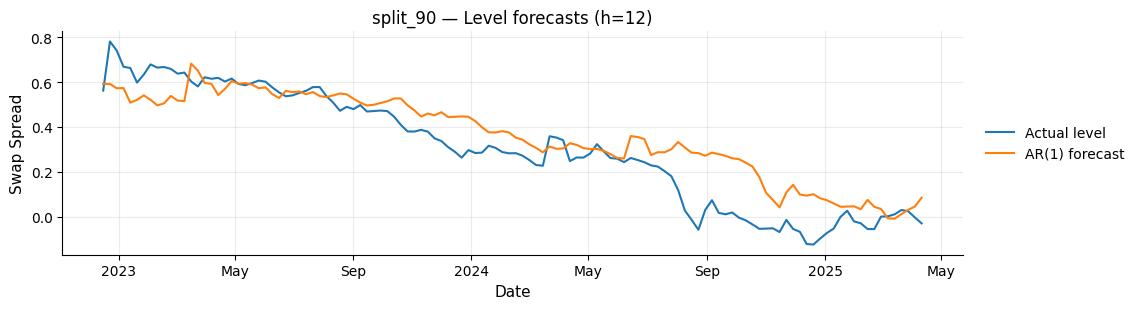

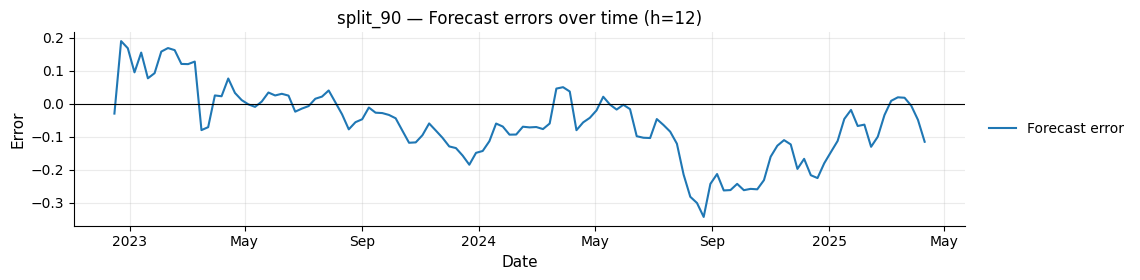


=== AR(1) on LEVEL — metrics (level forecasts) ===
  h=1: MAE=0.025471  MSE=0.001435  RMSE=0.037881  MAPE=48.94%  sMAPE=24.34%  MFE=-0.005275
  h=4: MAE=0.053642  MSE=0.005281  RMSE=0.072669  MAPE=109.97%  sMAPE=41.23%  MFE=-0.022217
  h=12: MAE=0.096209  MSE=0.015257  RMSE=0.123518  MAPE=316.89%  sMAPE=66.32%  MFE=-0.060006


In [ ]:

import math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.ar_model import AutoReg

# --------- Config & data ----------
PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"
DATE_COL   = "Date"
LEVEL_COL  = "Swap Spread"
HORIZONS   = [1, 4, 12]
SPLITS     = [(0.60,0.70), (0.70,0.80), (0.80,0.90), (0.90,1.00)]
LEGEND_BBOX = (1.02, 0.5)  # legend outside to the right
EPS = 1e-8                 # guard for percentages

df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl", parse_dates=[DATE_COL])
df = df[[DATE_COL, LEVEL_COL]].dropna().sort_values(DATE_COL).reset_index(drop=True)

# --------- Helpers ----------
def setup_dates(ax):
    """Less-cramped date axis: AutoDateLocator + ConciseDateFormatter."""
    locator = mdates.AutoDateLocator(minticks=6, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

def smape(y_true, y_hat):
    y_true = np.asarray(y_true, float)
    y_hat  = np.asarray(y_hat,  float)
    denom = np.maximum(np.abs(y_true) + np.abs(y_hat), EPS)
    return float(np.mean(2.0 * np.abs(y_true - y_hat) / denom) * 100.0)

def metrics_report(y_true, y_hat):
    y_true = np.asarray(y_true, float)
    y_hat  = np.asarray(y_hat,  float)
    err  = y_true - y_hat
    mae  = float(np.mean(np.abs(err)))
    mse  = float(np.mean(err**2))
    rmse = float(np.sqrt(mse))
    mape = float(np.mean(np.abs(err) / (np.abs(y_true) + EPS))) * 100.0
    smp  = smape(y_true, y_hat)
    mfe  = float(np.mean(err))  # positive => under-forecast on average
    return dict(MAE=mae, MSE=mse, RMSE=rmse, MAPE=mape, sMAPE=smp, MFE=mfe)

def print_metrics_table(title, res_dict):
    print(f"\n=== {title} ===")
    for h in sorted(res_dict):
        m = res_dict[h]
        print(
            f"  h={h}: MAE={m['MAE']:.6f}  MSE={m['MSE']:.6f}  RMSE={m['RMSE']:.6f}  "
            f"MAPE={m['MAPE']:.2f}%  sMAPE={m['sMAPE']:.2f}%  MFE={m['MFE']:.6f}"
        )

def ar1_level_fit_params(y_train):
    """
    AR(1) on LEVEL: y_t = c + phi*y_{t-1} + e_t
    Returns (c, phi) using positional params to avoid dtype/name issues.
    """
    model  = AutoReg(y_train, lags=1, trend='c', old_names=False).fit()
    params = np.asarray(model.params, dtype=float)
    if params.shape[0] < 2:
        raise RuntimeError("AR(1) fit did not return two parameters.")
    c, phi = float(params[0]), float(params[1])
    return c, phi

def ar1_level_forecast_h(y_t, c, phi, h):
    """
    h-step AR(1) forecast on level:
    E[y_{t+h}|y_t] = c*(1 - phi^h)/(1 - phi) + phi^h * y_t
    """
    if abs(1.0 - phi) < 1e-10:
        return y_t + h * c  # random-walk-with-drift limit
    return c * (1.0 - (phi ** h)) / (1.0 - phi) + (phi ** h) * y_t

# --------- Runner ----------
def run_ar1_level_baseline(df):
    dates = df[DATE_COL].values
    y     = df[LEVEL_COL].astype(float).values
    N     = len(df)

    for (a,b) in SPLITS:
        tr_end = int(math.floor(a*N))
        te_end = int(math.floor(b*N))
        if te_end - tr_end <= max(HORIZONS):
            print(f"\n(split_{int(a*100)}) window too small for max horizon; skipping.")
            continue

        print(f"\n=========== AR(1) LEVEL — split_{int(a*100)} (train 0:{tr_end-1} | test {tr_end}:{te_end-1}) ===========")

        # Fit AR(1) on TRAIN level
        c, phi = ar1_level_fit_params(y[:tr_end])

        # Test anchors t s.t. y_{t+h} exists within [tr_end, te_end)
        anchors = np.arange(tr_end, te_end - max(HORIZONS))
        dates_a = dates[anchors]

        # Forecasts & metrics per horizon
        res = {}
        for h in HORIZONS:
            y_true = y[anchors + h]
            y_t    = y[anchors]
            y_hat  = np.array([ar1_level_forecast_h(y_t[i], c, phi, h) for i in range(len(anchors))], dtype=float)
            res[h] = metrics_report(y_true, y_hat)

            # Plot 1: Actual vs Forecast (level) — legend outside
            fig, ax = plt.subplots(figsize=(11.5, 3.2))
            ax.plot(dates_a, y_true, label="Actual level")
            ax.plot(dates_a, y_hat,  label="AR(1) forecast")
            ax.set_title(f"split_{int(a*100)} — Level forecasts (h={h})")
            ax.set_xlabel("Date"); ax.set_ylabel(LEVEL_COL)
            setup_dates(ax)
            ax.legend(loc="center left", bbox_to_anchor=LEGEND_BBOX, borderaxespad=0.)
            fig.tight_layout(); plt.show()

            # Plot 2: Errors over time — single blue-line legend labeled "Forecast error"
            e = y_true - y_hat
            fig, ax = plt.subplots(figsize=(11.5, 2.9))
            ax.plot(dates_a, e, label="Forecast error")
            ax.axhline(0, color='black', linewidth=0.8)
            ax.set_title(f"split_{int(a*100)} — Forecast errors over time (h={h})")
            ax.set_xlabel("Date"); ax.set_ylabel("Error")
            setup_dates(ax)
            ax.legend(loc="center left", bbox_to_anchor=LEGEND_BBOX, borderaxespad=0.)
            fig.tight_layout(); plt.show()

        print_metrics_table("AR(1) on LEVEL — metrics (level forecasts)", res)

# ------------------- Go -------------------
run_ar1_level_baseline(df)


AR(p) optimized good


================ AR(p) — split_60 (train 0:797 | test 798:930) ================
Chosen p=2 by BIC=-2948.096

=== AR(p) (level forecasts) ===
  h= 1: MAE=0.021870  MSE=0.000833  RMSE=0.028864  MAPE=5.71%  sMAPE=5.67%  MFE=0.003151
  h= 4: MAE=0.038923  MSE=0.002269  RMSE=0.047635  MAPE=9.71%  sMAPE=9.88%  MFE=0.011769
  h=12: MAE=0.044953  MSE=0.003226  RMSE=0.056802  MAPE=10.82%  sMAPE=11.48%  MFE=0.029792


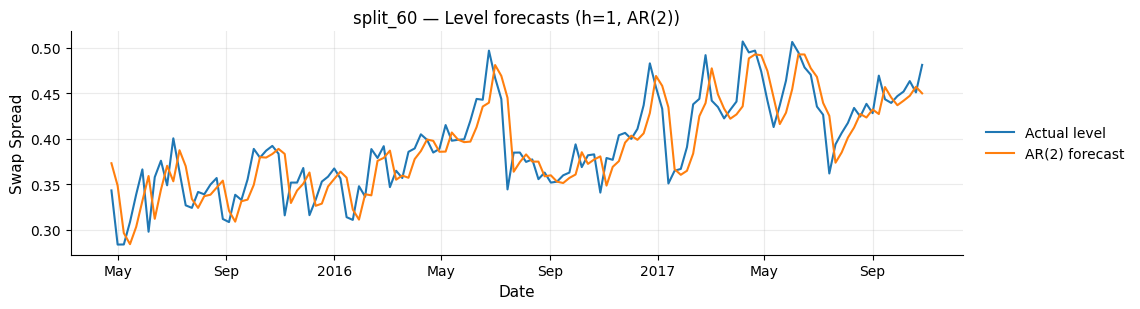

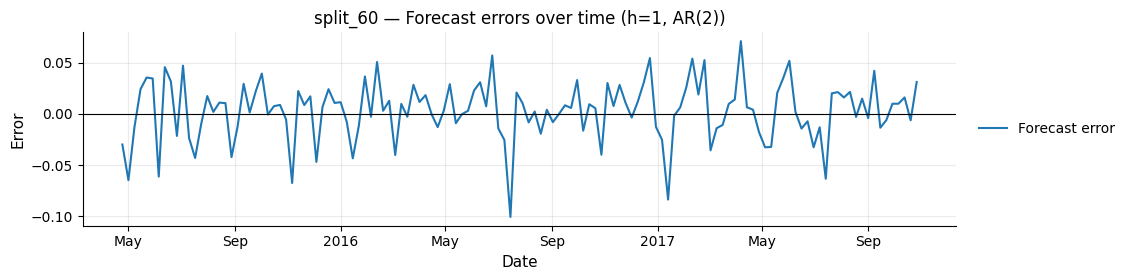

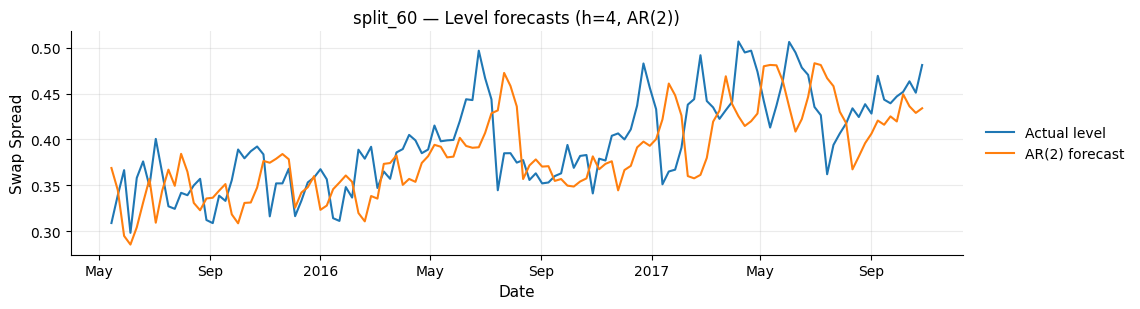

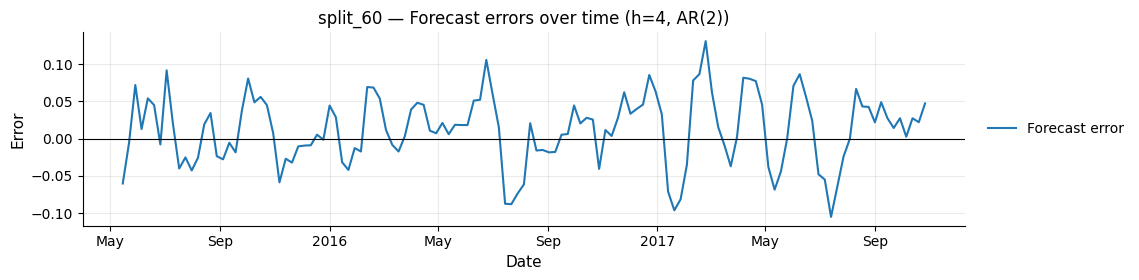

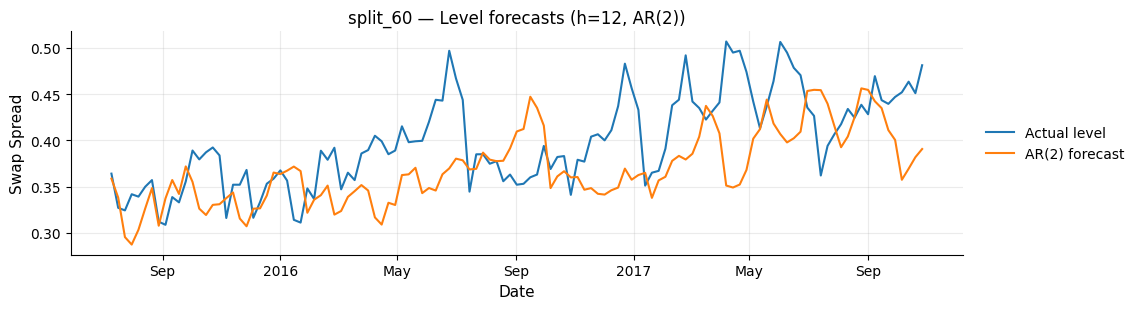

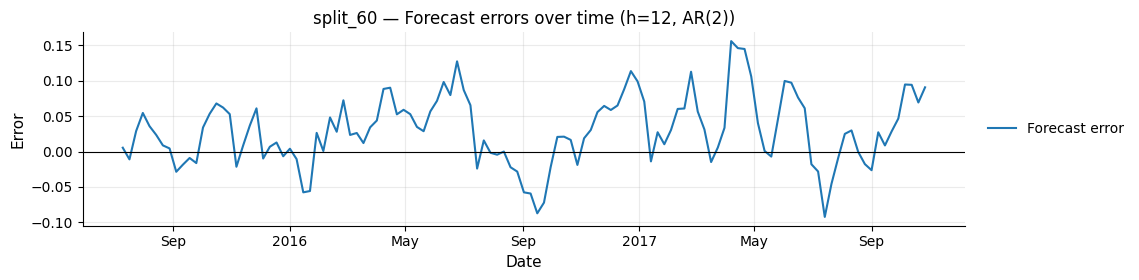


================ AR(p) — split_70 (train 0:930 | test 931:1063) ================
Chosen p=2 by BIC=-3500.495

=== AR(p) (level forecasts) ===
  h= 1: MAE=0.019924  MSE=0.000721  RMSE=0.026844  MAPE=4.37%  sMAPE=4.38%  MFE=0.002906
  h= 4: MAE=0.033253  MSE=0.001845  RMSE=0.042955  MAPE=7.09%  sMAPE=7.22%  MFE=0.010710
  h=12: MAE=0.049522  MSE=0.004025  RMSE=0.063440  MAPE=10.14%  sMAPE=10.69%  MFE=0.030457


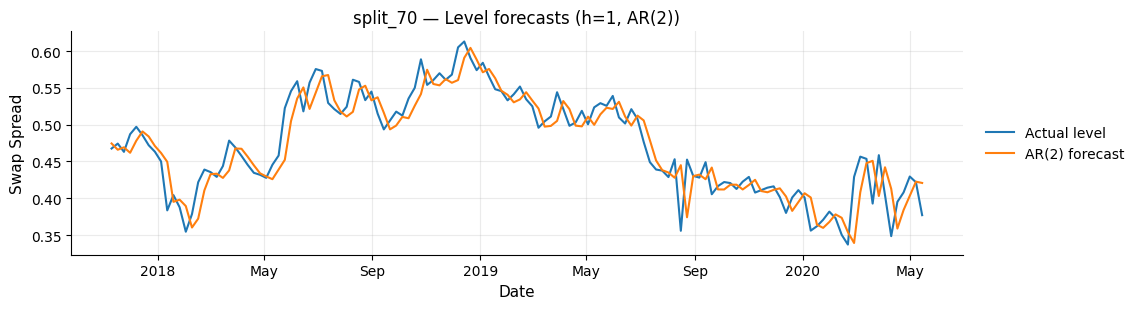

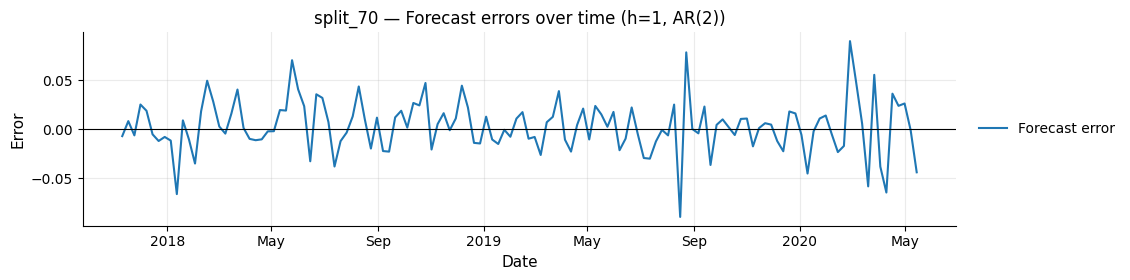

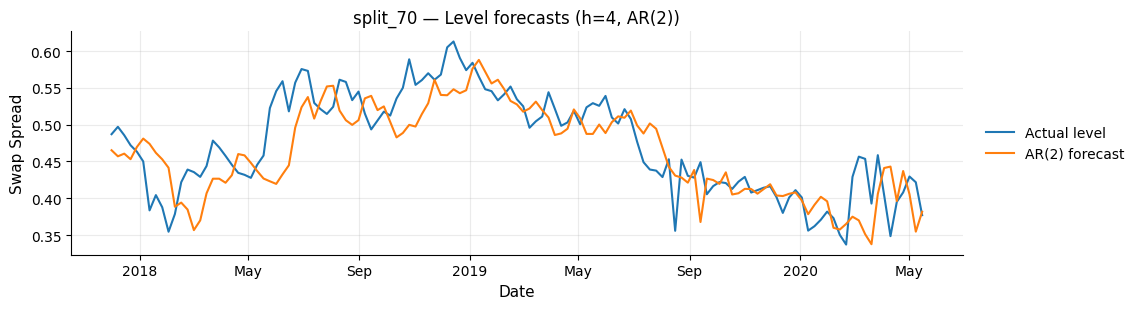

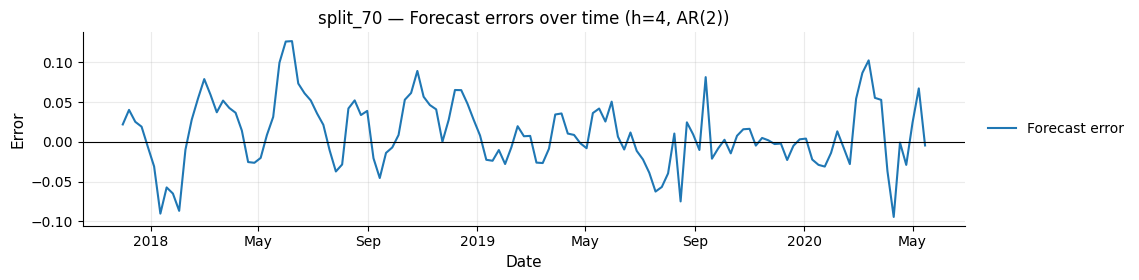

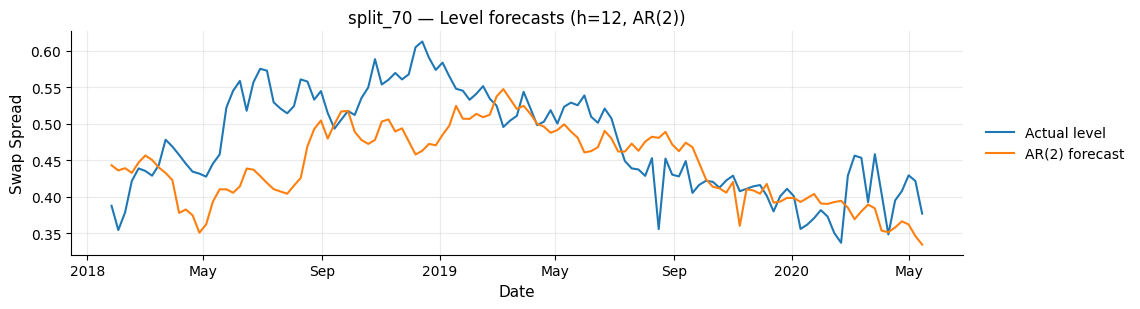

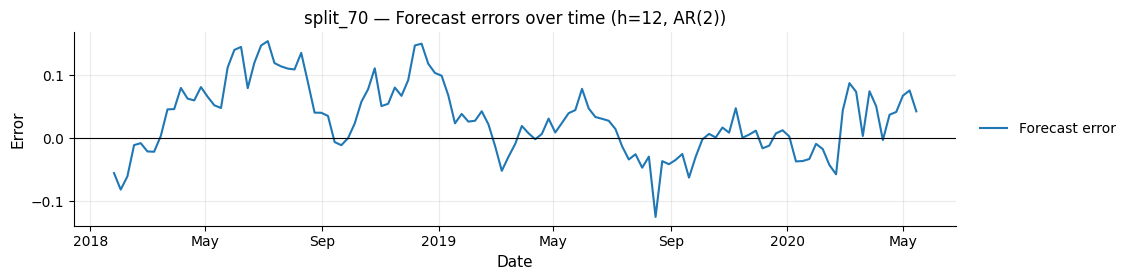


================ AR(p) — split_80 (train 0:1063 | test 1064:1196) ================
Chosen p=2 by BIC=-4067.504

=== AR(p) (level forecasts) ===
  h= 1: MAE=0.028051  MSE=0.001678  RMSE=0.040967  MAPE=5.54%  sMAPE=5.57%  MFE=0.006498
  h= 4: MAE=0.051939  MSE=0.005777  RMSE=0.076007  MAPE=9.62%  sMAPE=10.04%  MFE=0.024129
  h=12: MAE=0.092091  MSE=0.016276  RMSE=0.127575  MAPE=15.74%  sMAPE=17.52%  MFE=0.078863


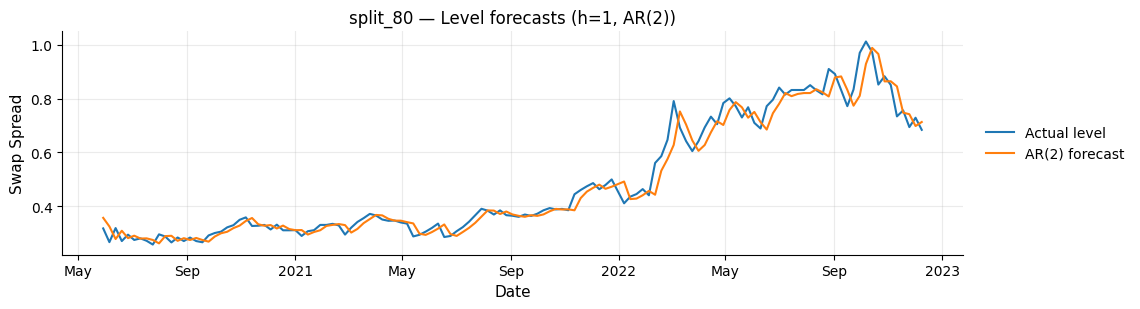

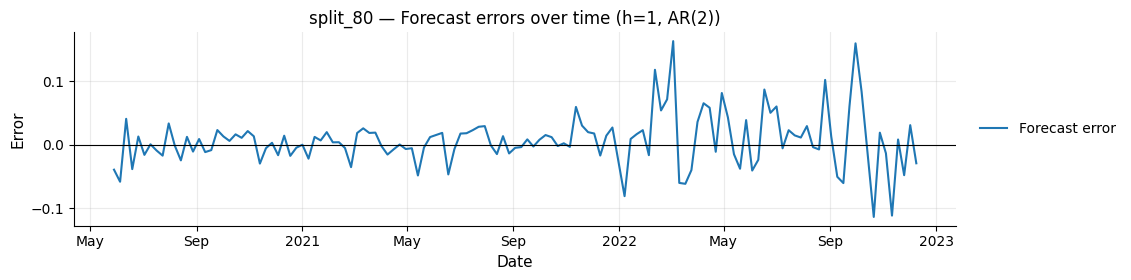

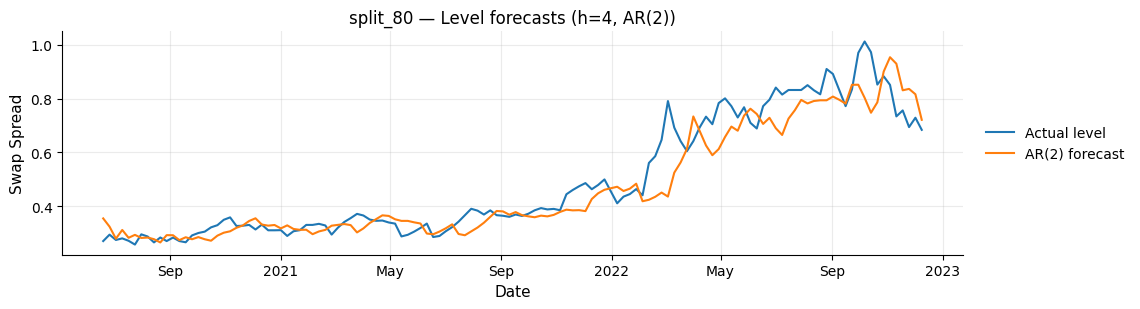

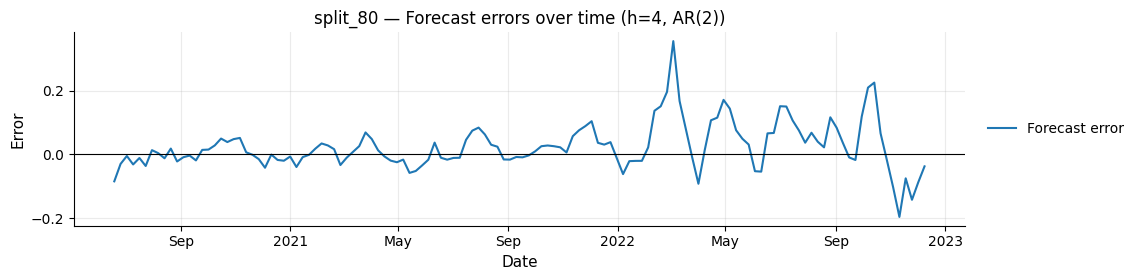

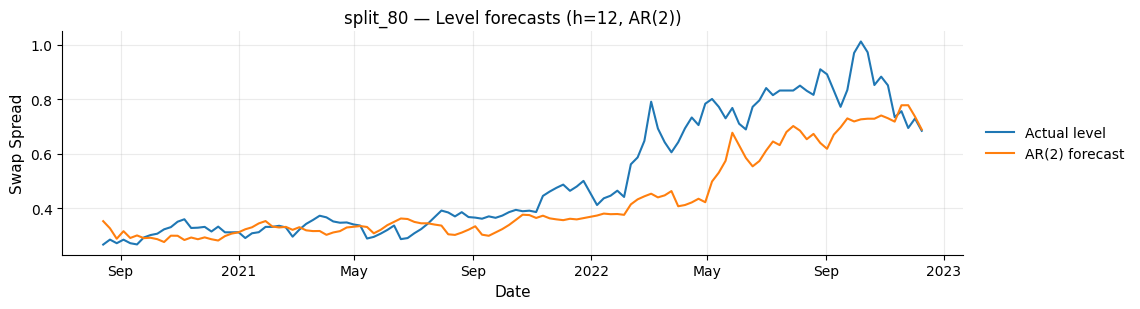

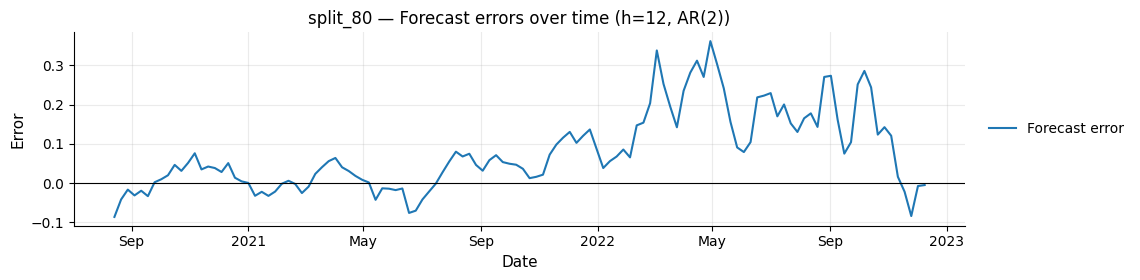


================ AR(p) — split_90 (train 0:1196 | test 1197:1330) ================
Chosen p=2 by BIC=-4536.123

=== AR(p) (level forecasts) ===
  h= 1: MAE=0.025930  MSE=0.001446  RMSE=0.038024  MAPE=166.34%  sMAPE=33.85%  MFE=-0.006734
  h= 4: MAE=0.051726  MSE=0.004913  RMSE=0.070093  MAPE=142.43%  sMAPE=48.47%  MFE=-0.022354
  h=12: MAE=0.092614  MSE=0.014112  RMSE=0.118794  MAPE=250.71%  sMAPE=68.50%  MFE=-0.061007


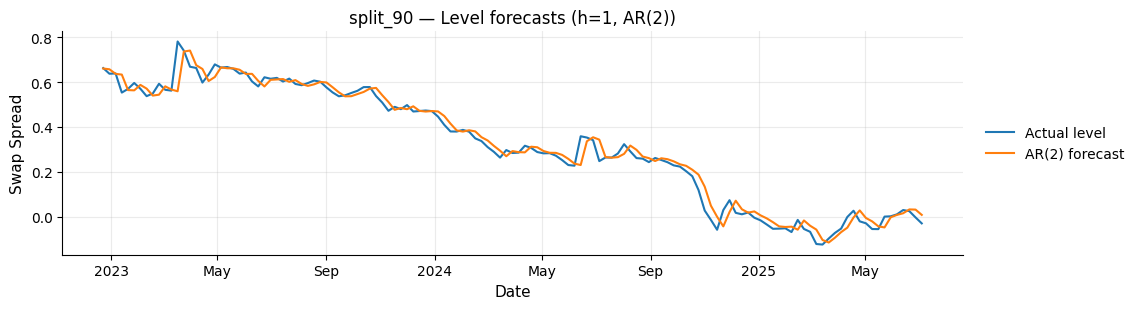

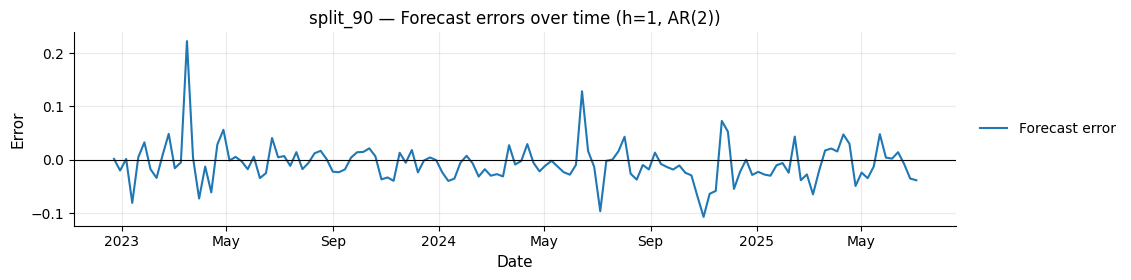

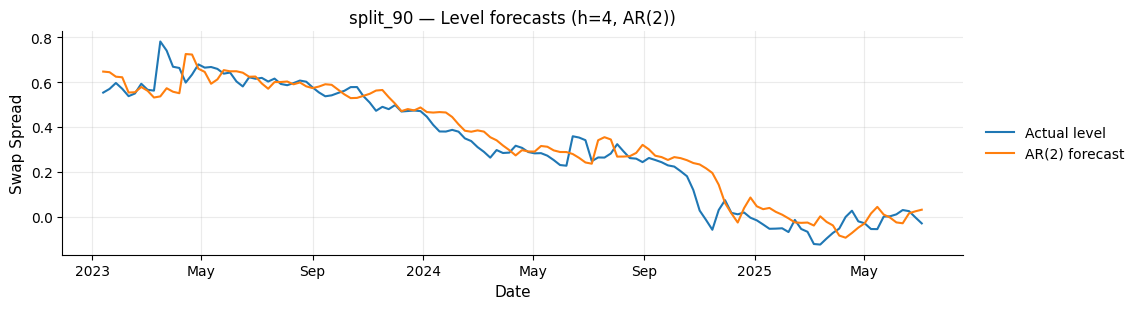

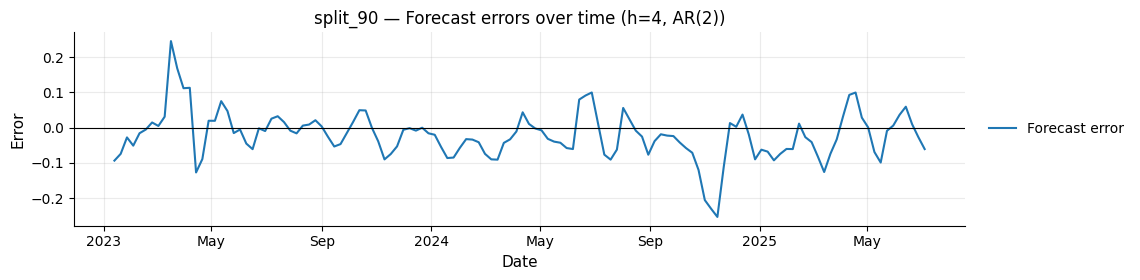

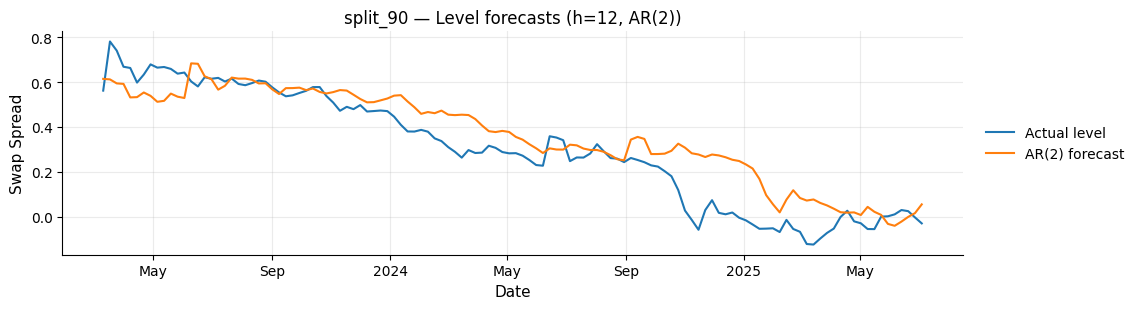

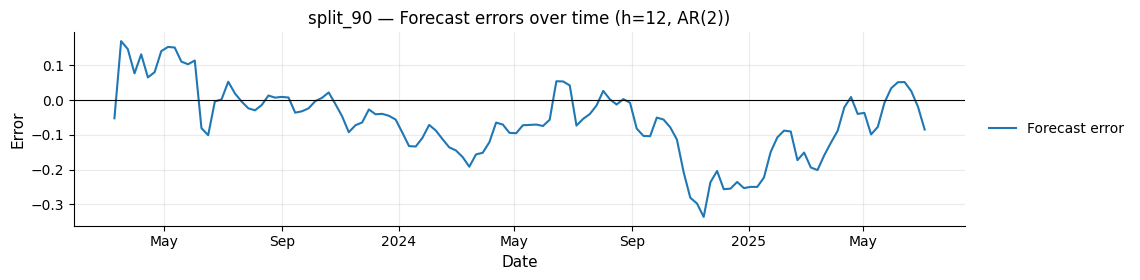

In [ ]:

import math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.ar_model import AutoReg

# ----------------------------- Config ------------------------------------------
PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"
DATE_COL  = "Date"
LEVEL_COL = "Swap Spread"     # level series (no differencing)
HORIZONS  = [1, 4, 12]
SPLITS    = [(0.60,0.70), (0.70,0.80), (0.80,0.90), (0.90,1.00)]
P_MAX     = 12                # you can try 24 as a sensitivity check
LEGEND_BBOX = (1.02, 0.5)     # legend outside (right, vertically centered)
EPS = 1e-8                    # numerical guard for % metrics

# ----------------------------- Load --------------------------------------------
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df = df[[DATE_COL, LEVEL_COL]].dropna().sort_values(DATE_COL).reset_index(drop=True)
dates = pd.to_datetime(df[DATE_COL].values)
y     = df[LEVEL_COL].astype(float).values
N     = len(df)

# ----------------------------- Utils -------------------------------------------
def setup_dates(ax):
    """Less-cramped date axis: AutoDateLocator + ConciseDateFormatter."""
    locator = mdates.AutoDateLocator(minticks=6, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

def smape(y_true, y_hat):
    y_true = np.asarray(y_true, float); y_hat = np.asarray(y_hat, float)
    denom = np.maximum(np.abs(y_true) + np.abs(y_hat), EPS)
    return float(np.mean(2.0 * np.abs(y_true - y_hat) / denom) * 100.0)

def metrics_report(y_true, y_hat):
    y_true = np.asarray(y_true, float); y_hat = np.asarray(y_hat, float)
    err  = y_true - y_hat
    mae  = float(np.mean(np.abs(err)))
    mse  = float(np.mean(err**2))
    rmse = float(np.sqrt(mse))
    mape = float(np.mean(np.abs(err) / (np.abs(y_true) + EPS))) * 100.0
    smp  = smape(y_true, y_hat)
    mfe  = float(np.mean(err))  # >0 means under-forecast on average
    return dict(MAE=mae, MSE=mse, RMSE=rmse, MAPE=mape, sMAPE=smp, MFE=mfe)

def print_metrics_table(title, res_dict):
    print(f"\n=== {title} ===")
    for h in HORIZONS:
        if h not in res_dict: 
            print(f"  h={h:>2}: (no test points)")
            continue
        m = res_dict[h]
        print(
            f"  h={h:>2}: MAE={m['MAE']:.6f}  MSE={m['MSE']:.6f}  RMSE={m['RMSE']:.6f}  "
            f"MAPE={m['MAPE']:.2f}%  sMAPE={m['sMAPE']:.2f}%  MFE={m['MFE']:.6f}"
        )

def fit_ar_p_bic(y_train, pmax=P_MAX):
    """
    Fit AR(p) with p in [1..pmax], select by minimum BIC.
    Returns (p_best, c, phi, bic_best, results_object).
    """
    best = dict(bic=np.inf, p=None, res=None)
    for p in range(1, pmax+1):
        if len(y_train) <= p + 1:
            break
        try:
            res = AutoReg(y_train, lags=p, trend='c', old_names=False).fit()
            bic = float(res.bic)
            if bic < best["bic"]:
                best = dict(bic=bic, p=p, res=res)
        except Exception:
            continue
    if best["res"] is None:
        raise RuntimeError("Failed to fit any AR(p) model. Try lowering P_MAX.")
    res = best["res"]
    params = res.params
    c = float(params[0])
    phi = np.array(params[1:], float)
    return best["p"], c, phi, best["bic"], res

def ar_p_forecast_h(c, phi, history_descending, h):
    """
    h-step forecast for AR(p):
      y_{t+1} = c + sum_{i=1..p} phi_i * y_{t+1-i}
    history_descending: [y_t, y_{t-1}, ..., y_{t-p+1}] (length >= p)
    """
    p = len(phi)
    buf = list(history_descending[:p])  # ensure length p
    for _ in range(h):
        nxt = c
        for i in range(1, p+1):
            nxt += phi[i-1] * buf[i-1]     # buf[0]=last value, buf[1]=lag1, ...
        buf = [nxt] + buf[:p-1]           # prepend new level
    return buf[0]  # y_{t+h|t}

# ----------------------------- Main --------------------------------------------
for (a,b) in SPLITS:
    tr_end = int(math.floor(a*N))        # train: 0..tr_end-1
    te_end = int(math.floor(b*N))        # test anchors in [tr_end .. te_end-h]
    print(f"\n================ AR(p) — split_{int(a*100)} (train 0:{tr_end-1} | test {tr_end}:{te_end-1}) ================")

    y_train = y[:tr_end].copy()
    # Choose p by BIC
    p_best, c, phi, bic, res = fit_ar_p_bic(y_train, pmax=P_MAX)
    print(f"Chosen p={p_best} by BIC={bic:.3f}")

    # Containers for metrics and (per-h) plotting data
    res_by_h = {}
    plot_cache = {}  # h -> dict(dates_plot, y_true_plot, y_hat_plot, err_plot)

    # Evaluate every horizon
    for h in HORIZONS:
        if te_end - h <= tr_end:
            print(f"  h={h}: not enough test points in this split.")
            continue

        anchors = np.arange(tr_end, te_end - h)
        y_true  = y[anchors + h]

        y_hat = np.empty_like(y_true)
        p = len(phi)
        for idx, t in enumerate(anchors):
            # Gather last p values as [y_t, y_{t-1}, ..., y_{t-p+1}]
            if t - (p-1) < 0:
                y_hat[idx] = np.nan
                continue
            hist = y[t : t - p : -1] if p > 1 else np.array([y[t]])
            if len(hist) < p:
                pad = [y[0]] * (p - len(hist))
                hist = np.concatenate([hist, pad])
            y_hat[idx] = ar_p_forecast_h(c, phi, hist, h)

        # Drop potential NaNs near the very start
        mask = ~np.isnan(y_hat)
        y_true = y_true[mask]; y_hat = y_hat[mask]
        res_by_h[h] = metrics_report(y_true, y_hat)

        if mask.sum() > 0:
            dates_plot = dates[anchors[mask] + h]
            plot_cache[h] = {
                "dates_plot": dates_plot,
                "y_true_plot": y_true,
                "y_hat_plot":  y_hat,
                "err_plot":    y_true - y_hat,
            }

    # Print metrics (includes sMAPE and MFE)
    print_metrics_table("AR(p) (level forecasts)", res_by_h)

    # --------- Plots (for ALL horizons) ---------
    for h in HORIZONS:
        if h not in plot_cache:
            continue
        dates_plot = plot_cache[h]["dates_plot"]
        y_true_plot = plot_cache[h]["y_true_plot"]
        y_hat_plot  = plot_cache[h]["y_hat_plot"]
        err_plot    = plot_cache[h]["err_plot"]

        # Level plot — legend outside, clear labels
        fig, ax = plt.subplots(figsize=(11.5, 3.2))
        ax.plot(dates_plot, y_true_plot, label="Actual level")
        ax.plot(dates_plot, y_hat_plot,  label=f"AR({p_best}) forecast")
        ax.set_title(f"split_{int(a*100)} — Level forecasts (h={h}, AR({p_best}))")
        ax.set_xlabel("Date"); ax.set_ylabel(LEVEL_COL)
        setup_dates(ax)
        ax.legend(loc="center left", bbox_to_anchor=LEGEND_BBOX, borderaxespad=0.)
        fig.tight_layout(); plt.show()

        # Error plot — single blue-line legend "Forecast error"
        fig, ax = plt.subplots(figsize=(11.5, 2.9))
        ax.plot(dates_plot, err_plot, label="Forecast error")
        ax.axhline(0, linewidth=0.8, color='black')
        ax.set_title(f"split_{int(a*100)} — Forecast errors over time (h={h}, AR({p_best}))")
        ax.set_xlabel("Date"); ax.set_ylabel("Error")
        setup_dates(ax)
        ax.legend(loc="center left", bbox_to_anchor=LEGEND_BBOX, borderaxespad=0.)
        fig.tight_layout(); plt.show()


AR-X good


================ AR-X (joint BIC) — split_60 (train 0:797 | test 798:930) ================
Chosen by BIC on TRAIN: p=2, exogs=['Yield_Slope_L1', 'German_UnemploymentRate_L1'], BIC=-2957.717

=== AR-X (joint BIC) — level forecasts ===
  h= 1: N= 132  MAE=0.021370  MSE=0.000848  RMSE=0.029123  MAPE=5.65%  sMAPE=5.49%  MFE=-0.004230
  h= 4: N= 129  MAE=0.038327  MSE=0.002259  RMSE=0.047532  MAPE=9.96%  sMAPE=9.55%  MFE=-0.012528
  h=12: N= 121  MAE=0.048704  MSE=0.003628  RMSE=0.060230  MAPE=12.91%  sMAPE=11.90%  MFE=-0.033130


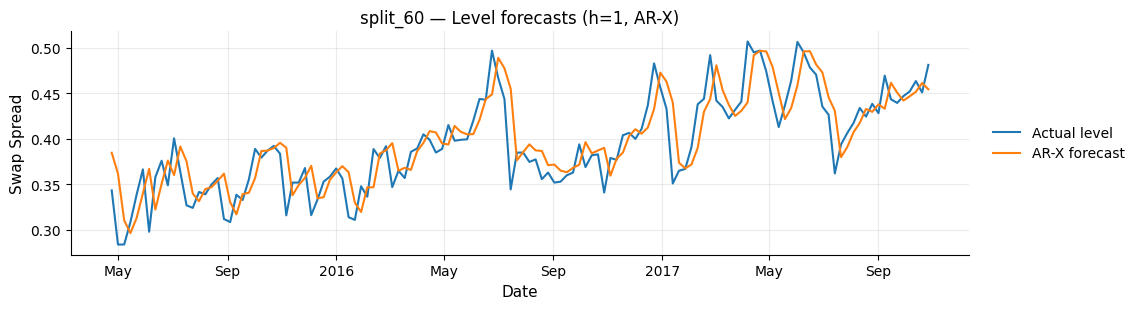

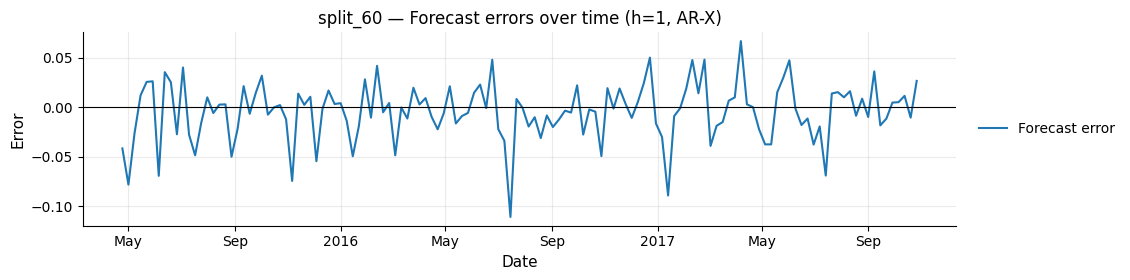

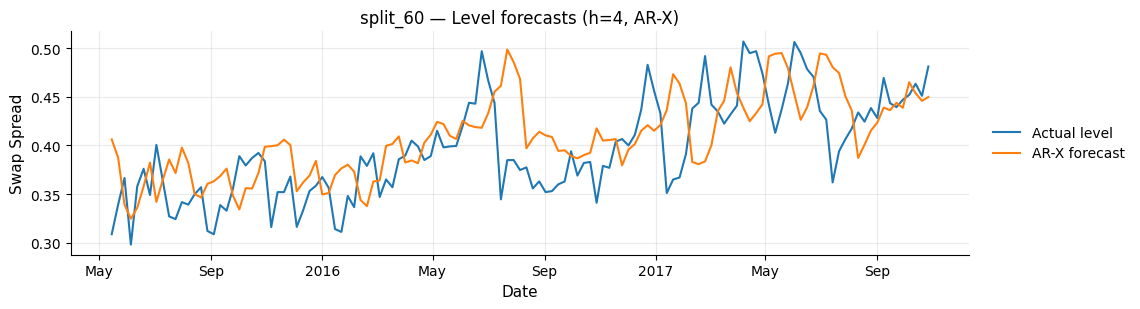

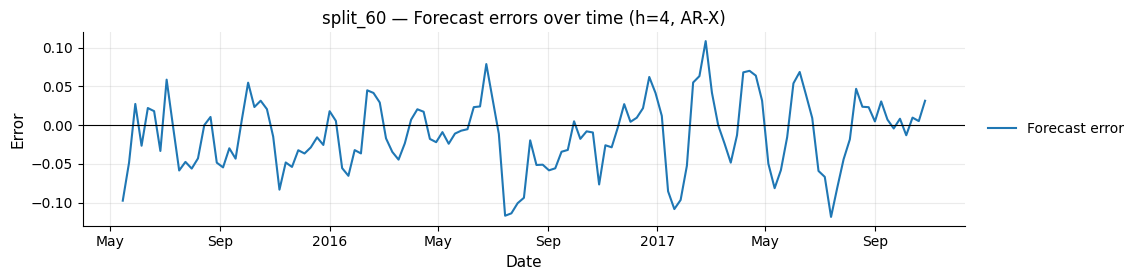

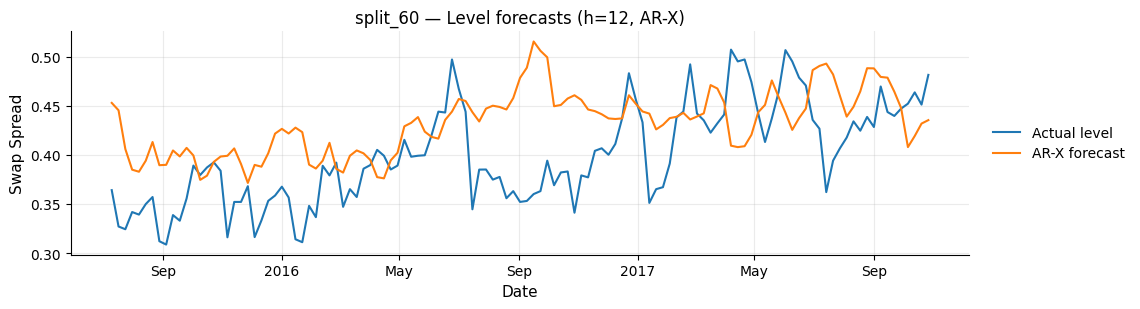

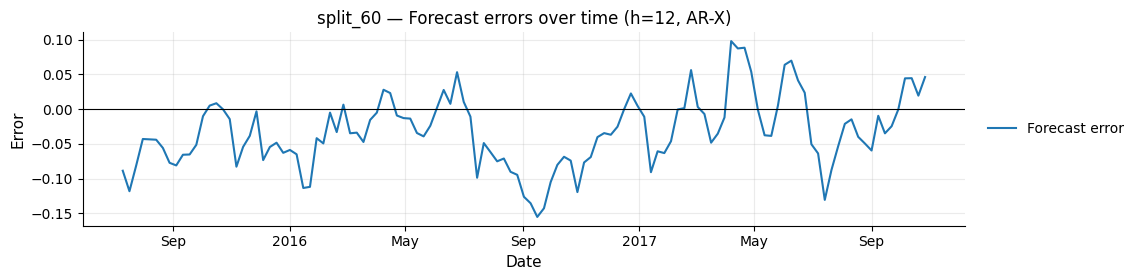


================ AR-X (joint BIC) — split_70 (train 0:930 | test 931:1063) ================
Chosen by BIC on TRAIN: p=2, exogs=['Credit_Risk_L1', 'ECBrate_L1', 'German_UnemploymentRate_L1'], BIC=-3511.764

=== AR-X (joint BIC) — level forecasts ===
  h= 1: N= 132  MAE=0.019832  MSE=0.000710  RMSE=0.026647  MAPE=4.38%  sMAPE=4.35%  MFE=-0.000083
  h= 4: N= 129  MAE=0.033403  MSE=0.001725  RMSE=0.041532  MAPE=7.32%  sMAPE=7.24%  MFE=0.000449
  h=12: N= 121  MAE=0.047590  MSE=0.003343  RMSE=0.057817  MAPE=10.30%  sMAPE=10.15%  MFE=0.002139


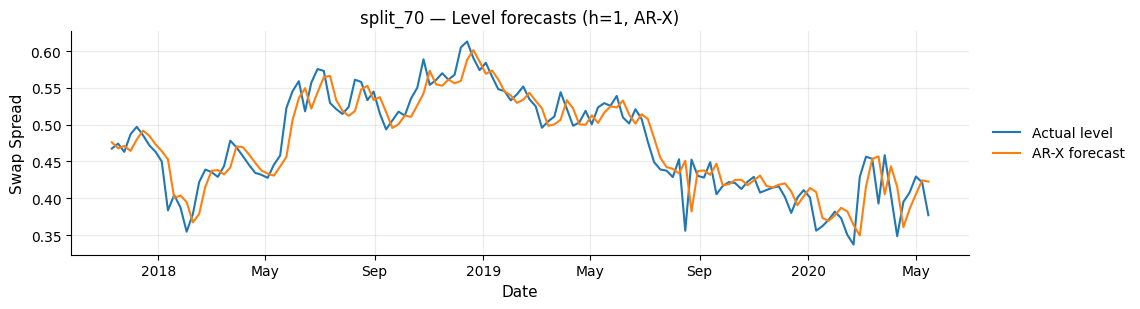

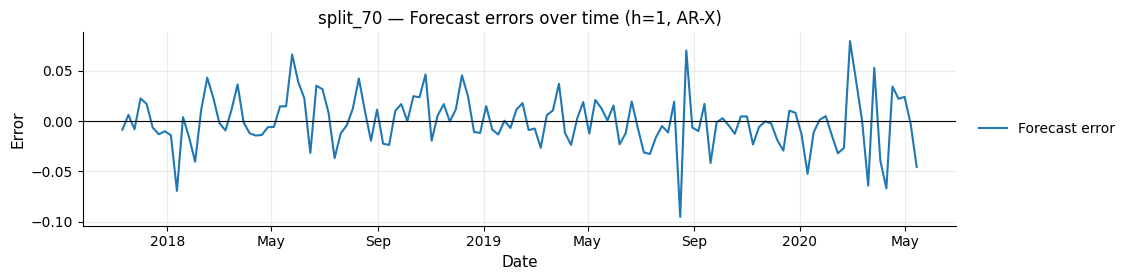

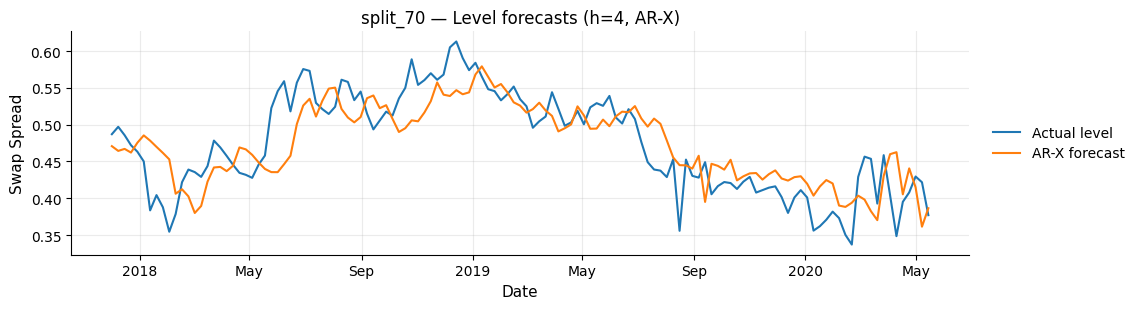

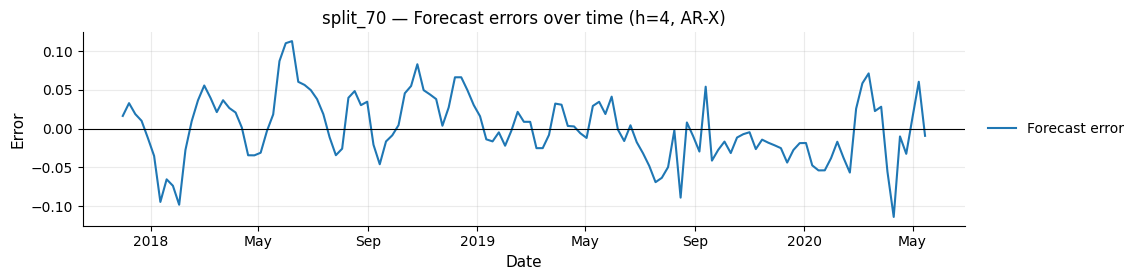

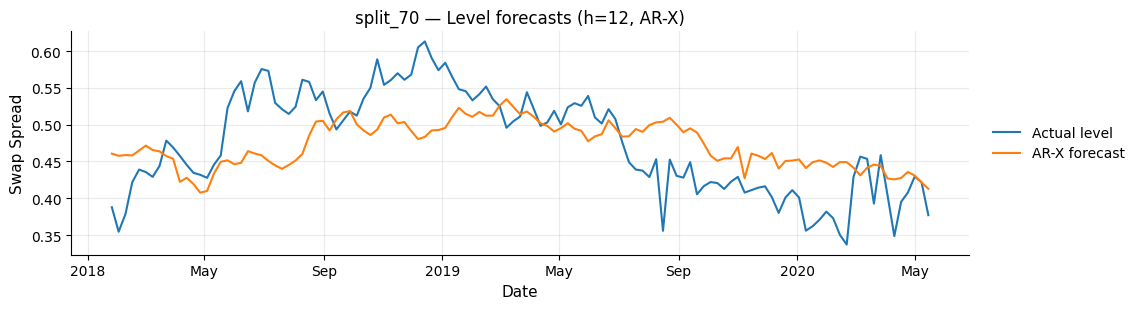

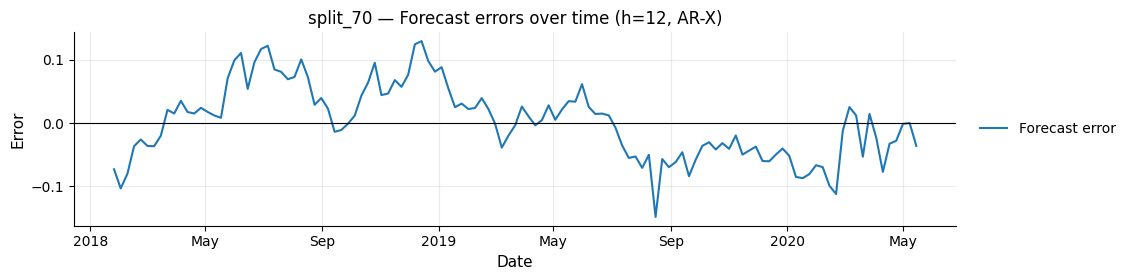


================ AR-X (joint BIC) — split_80 (train 0:1063 | test 1064:1196) ================
Chosen by BIC on TRAIN: p=2, exogs=['Credit_Risk_L1', 'ECBrate_L1', 'German_UnemploymentRate_L1'], BIC=-4082.158

=== AR-X (joint BIC) — level forecasts ===
  h= 1: N= 132  MAE=0.028009  MSE=0.001724  RMSE=0.041521  MAPE=5.50%  sMAPE=5.51%  MFE=0.006510
  h= 4: N= 129  MAE=0.054093  MSE=0.006143  RMSE=0.078378  MAPE=9.89%  sMAPE=10.20%  MFE=0.023753
  h=12: N= 121  MAE=0.092409  MSE=0.018012  RMSE=0.134209  MAPE=15.03%  sMAPE=16.36%  MFE=0.070140


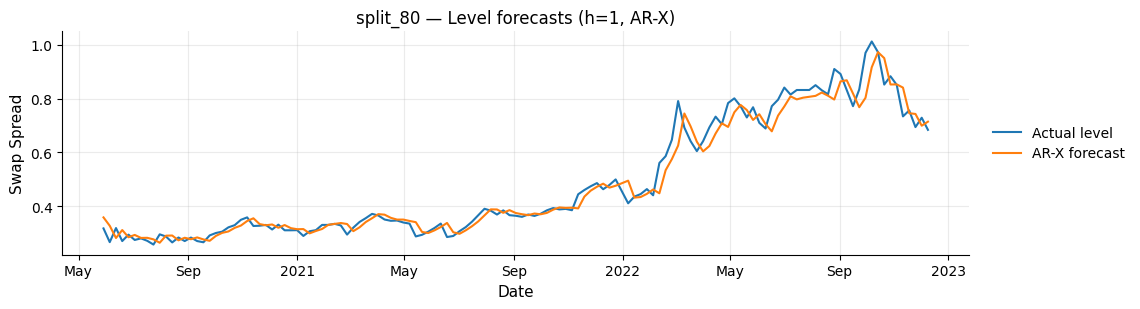

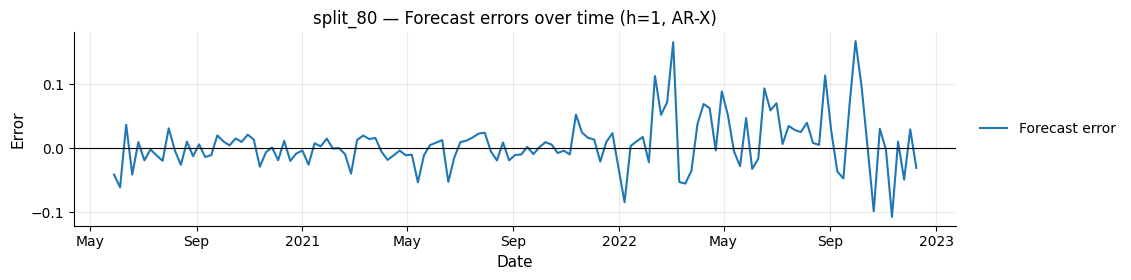

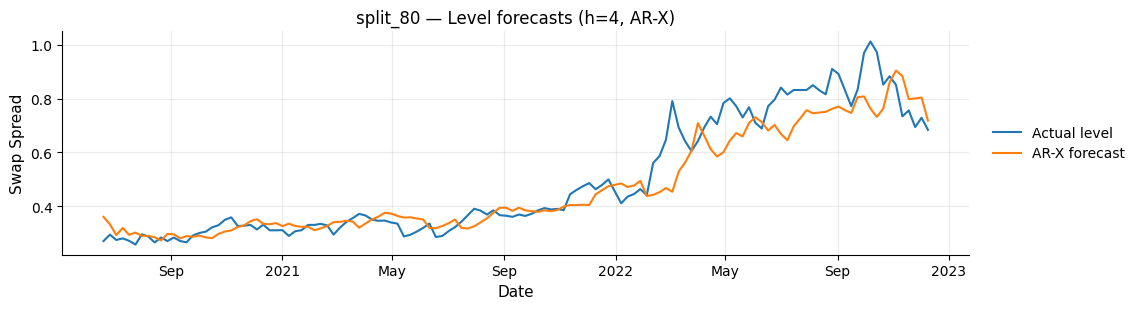

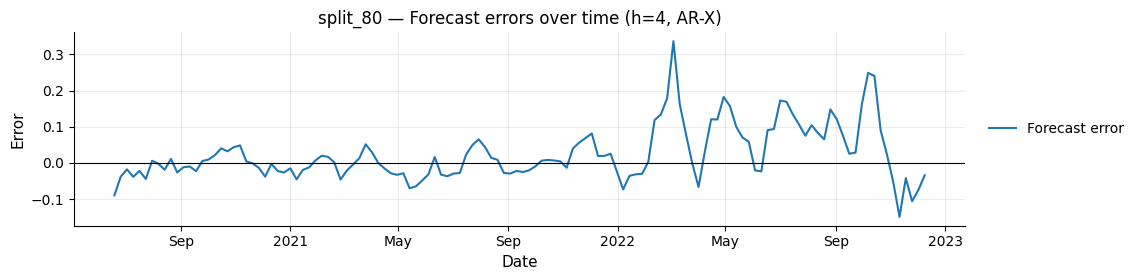

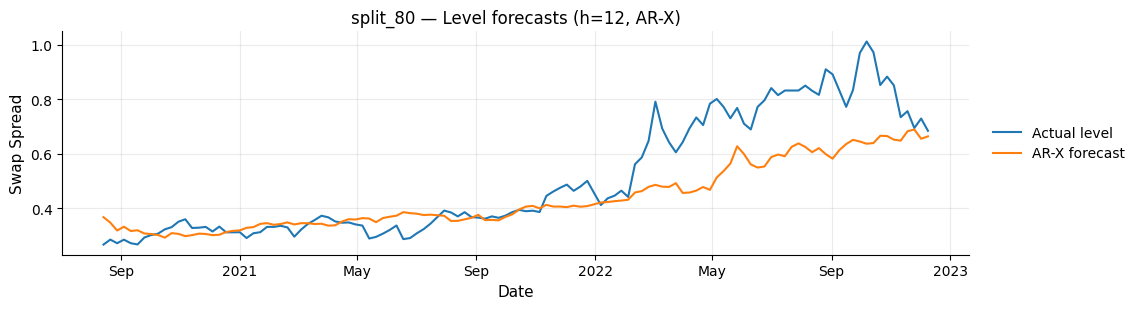

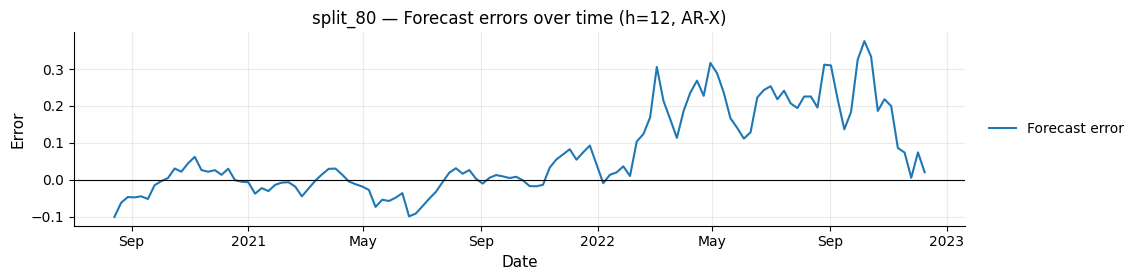


================ AR-X (joint BIC) — split_90 (train 0:1196 | test 1197:1330) ================
Chosen by BIC on TRAIN: p=2, exogs=['Credit_Risk_L1', 'ECBrate_L1', 'German_UnemploymentRate_L1'], BIC=-4546.921

=== AR-X (joint BIC) — level forecasts ===
  h= 1: N= 133  MAE=0.037640  MSE=0.002312  RMSE=0.048078  MAPE=135.94%  sMAPE=42.94%  MFE=-0.028605
  h= 4: N= 130  MAE=0.103054  MSE=0.014556  RMSE=0.120647  MAPE=431.21%  sMAPE=65.05%  MFE=-0.095057
  h=12: N= 122  MAE=0.249079  MSE=0.078146  RMSE=0.279546  MAPE=1375.30%  sMAPE=87.00%  MFE=-0.241793


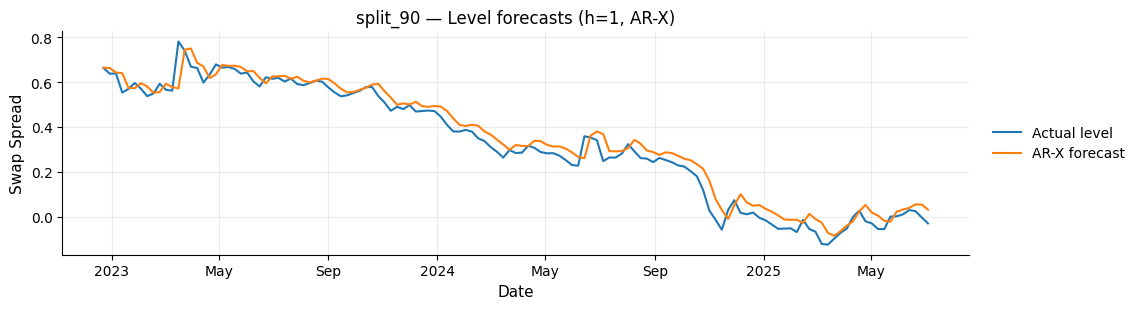

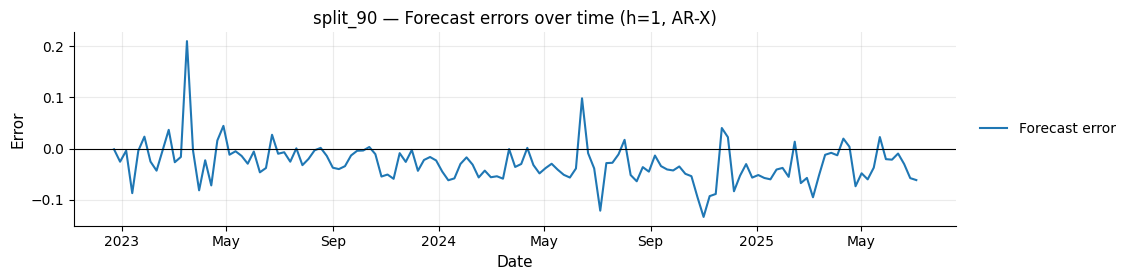

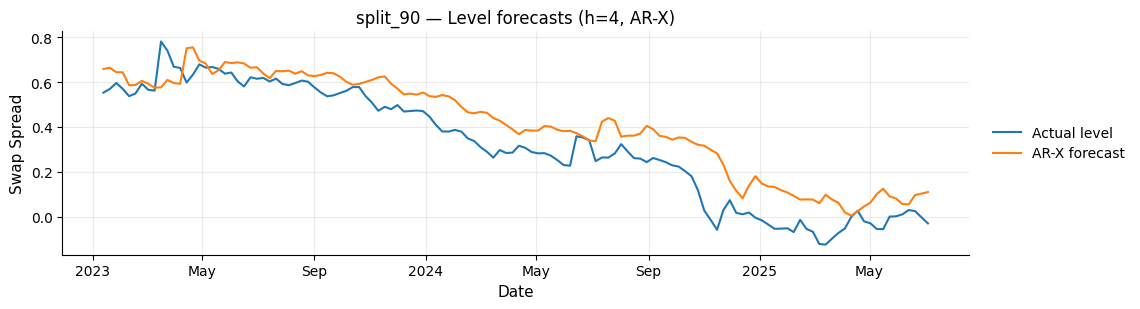

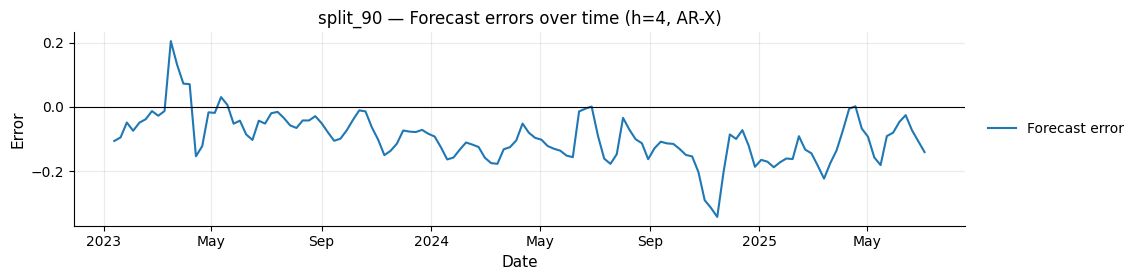

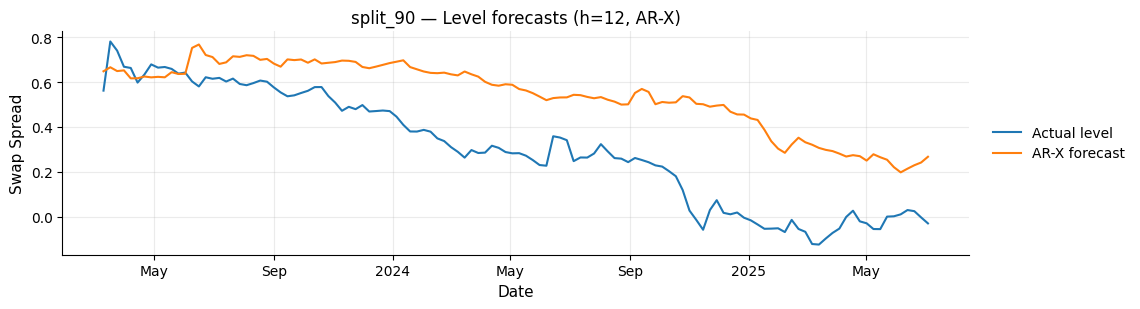

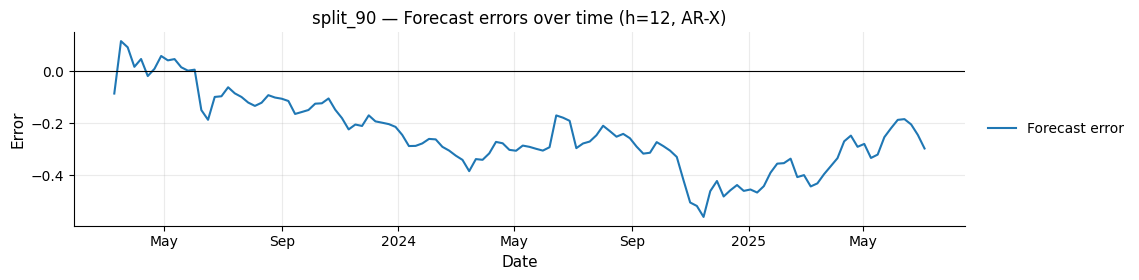

In [ ]:


import math, warnings, itertools
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------------- Config ------------------------------------------
PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"
DATE_COL  = "Date"
LEVEL_COL = "Swap Spread"   # level series

# >>>> set your 7 exogenous series here (column names in your Excel) <<<<
EXOG_COLS  = ["Credit_Risk","ECBrate","German_CPI YoY","Euribor-OIS","Yield_Slope","VSTOXX","German_UnemploymentRate"]

EXOG_LAGS = [1]             # allowed lags for each exog (keep modest; 1 is default)
HORIZONS  = [1, 4, 12]
SPLITS    = [(0.60,0.70), (0.70,0.80), (0.80,0.90), (0.90,1.00)]
P_MAX     = 6               # AR order grid upper bound (adjust if needed)
TREND_C   = True            # include intercept in AR-X

LEGEND_BBOX = (1.02, 0.5)   # legend outside (right)
EPS = 1e-8                  # numerical guard for percentages

# ----------------------------- Load --------------------------------------------
df_raw = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl", parse_dates=[DATE_COL])
use_cols = [DATE_COL, LEVEL_COL] + EXOG_COLS
df = df_raw[use_cols].dropna().sort_values(DATE_COL).reset_index(drop=True)
dates = pd.to_datetime(df[DATE_COL].values)
y     = df[LEVEL_COL].astype(float).values
N     = len(df)

# ----------------------------- Helpers ------------------------------------------
def setup_dates(ax):
    locator = mdates.AutoDateLocator(minticks=6, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

def smape(y_true, y_hat):
    y_true = np.asarray(y_true, float); y_hat = np.asarray(y_hat, float)
    denom = np.maximum(np.abs(y_true) + np.abs(y_hat), EPS)
    return float(np.mean(2.0 * np.abs(y_true - y_hat) / denom) * 100.0)

def metrics_report(y_true, y_hat):
    y_true = np.asarray(y_true, float); y_hat = np.asarray(y_hat, float)
    err  = y_true - y_hat
    mae  = float(np.mean(np.abs(err)))
    mse  = float(np.mean(err**2))
    rmse = float(np.sqrt(mse))
    mape = float(np.mean(np.abs(err) / (np.abs(y_true) + EPS))) * 100.0
    smp  = smape(y_true, y_hat)
    mfe  = float(np.mean(err))  # >0 => under-forecast on average
    return dict(MAE=mae, MSE=mse, RMSE=rmse, MAPE=mape, sMAPE=smp, MFE=mfe)

def print_metrics_table(title, res_dict, horizons):
    print(f"\n=== {title} ===")
    for h in horizons:
        if h not in res_dict:
            print(f"  h={h:>2}: (no test points)")
            continue
        m = res_dict[h]
        print(
            f"  h={h:>2}: N={m['N']:4d}  MAE={m['MAE']:.6f}  MSE={m['MSE']:.6f}  RMSE={m['RMSE']:.6f}  "
            f"MAPE={m['MAPE']:.2f}%  sMAPE={m['sMAPE']:.2f}%  MFE={m['MFE']:.6f}"
        )

def make_lagged_exogs(df_exog: pd.DataFrame, lags):
    pieces = []
    for col in df_exog.columns:
        for L in lags:
            pieces.append(df_exog[col].shift(L).rename(f"{col}_L{L}"))
    Xlag = pd.concat(pieces, axis=1)
    return Xlag

def align_design(y_series: pd.Series, p: int, Xlag: pd.DataFrame | None):
    """
    Build design for OLS: target y_t; regressors: [const], y_{t-1..t-p}, and selected Xlag columns at t.
    Returns y_vec (n,), X_mat (n,k), colnames list.
    """
    data = pd.DataFrame({"y": y_series})
    # Add AR lags
    for i in range(1, p+1):
        data[f"y_L{i}"] = y_series.shift(i)
    # Add exog lags if any
    if Xlag is not None and Xlag.shape[1] > 0:
        data = pd.concat([data, Xlag], axis=1)
    data = data.dropna()
    y_vec = data["y"].astype(float).values
    cols = []
    X_parts = []
    if TREND_C:
        X_parts.append(np.ones((len(data), 1), dtype=float))
        cols.append("const")
    for i in range(1, p+1):
        X_parts.append(data[f"y_L{i}"].astype(float).values.reshape(-1,1))
        cols.append(f"y_L{i}")
    if Xlag is not None and Xlag.shape[1] > 0:
        X_parts.append(data[Xlag.columns].astype(float).values)
        cols.extend(list(Xlag.columns))
    X_mat = np.hstack(X_parts) if len(X_parts)>0 else np.empty((len(data),0))
    return y_vec, X_mat, cols

def ols_fit_bic(y_vec, X_mat):
    """
    OLS via lstsq; compute Gaussian loglik and BIC: BIC = k*log(n) - 2*llf
    Returns (params, BIC, sigma2, rss)
    """
    n = y_vec.shape[0]
    k = X_mat.shape[1]
    if n <= k:
        return None, np.inf, np.nan, np.nan
    beta, residuals, rank, s = np.linalg.lstsq(X_mat, y_vec, rcond=None)
    if residuals.size == 0:
        # compute residuals explicitly if lstsq didn't return sumsq
        res = y_vec - X_mat @ beta
        rss = float(np.sum(res**2))
    else:
        rss = float(residuals[0])
    sigma2 = rss / n
    # Gaussian log-likelihood
    llf = -0.5 * n * (np.log(2*np.pi*sigma2) + 1.0)
    bic = k * np.log(n) - 2.0 * llf
    return beta, float(bic), float(sigma2), rss

def arx_forecast_multi(h, c, phi, beta_ex, hist_y_desc, x_vec):
    """
    h-step ARX forecast.
    hist_y_desc: list/array [y_t, y_{t-1}, ..., y_{t-p+1}]
    x_vec: exog vector at the origin (aligned with training design; same order as beta_ex)
    """
    p = len(phi)
    buf = list(hist_y_desc[:p]) if p>0 else []
    nxt = None
    for _ in range(h):
        nxt = (c if TREND_C else 0.0)
        # AR part
        for i in range(p):
            nxt += phi[i] * (buf[i] if i < len(buf) else buf[-1])
        # exog part (fixed over horizon = last known at origin)
        if beta_ex is not None and len(beta_ex) > 0:
            nxt += float(np.dot(beta_ex, x_vec))
        # roll buffer
        if p > 0:
            buf = [nxt] + buf[:p-1]
    return float(nxt)

# ----------------------------- Main --------------------------------------------
for (a,b) in SPLITS:
    tr_end = int(math.floor(a*N))        # train indices: 0..tr_end-1
    te_end = int(math.floor(b*N))        # test anchors in [tr_end .. te_end-h]
    print(f"\n================ AR-X (joint BIC) — split_{int(a*100)} (train 0:{tr_end-1} | test {tr_end}:{te_end-1}) ================")

    # Training slices as Series/DataFrame for lagging
    y_tr_series = pd.Series(y[:tr_end])
    X_raw_tr    = df.loc[:tr_end-1, EXOG_COLS].astype(float).reset_index(drop=True)

    # Build lagged exogs (training-only; we will use the same columns later on test)
    Xlag_tr_full = make_lagged_exogs(X_raw_tr, EXOG_LAGS)

    # Full subset grid over exog lag columns (including empty set)
    exog_columns_all = list(Xlag_tr_full.columns)
    best = {"bic": np.inf, "p": None, "cols": [] , "beta": None, "cols_order": None}

    for p in range(1, P_MAX+1):
        # Iterate all subsets of exog columns
        # For speed: iterate by subset size, but full 2^K is fine for K<=7 (lags=1 -> 7 columns)
        for r in range(0, len(exog_columns_all)+1):
            for subset in itertools.combinations(exog_columns_all, r):
                X_sel = Xlag_tr_full[list(subset)] if r>0 else None
                y_vec, X_mat, cols = align_design(y_tr_series, p, X_sel)
                beta, bic, sigma2, rss = ols_fit_bic(y_vec, X_mat)
                if np.isfinite(bic) and bic < best["bic"]:
                    best.update({"bic": bic, "p": p, "cols": list(subset), "beta": beta, "cols_order": cols})

    if best["p"] is None:
        print("No valid AR-X model could be fit on this split. Skipping.")
        continue

    p_best = best["p"]; cols_sel = best["cols"]; bic_best = best["bic"]
    print(f"Chosen by BIC on TRAIN: p={p_best}, exogs={cols_sel if cols_sel else '<none>'}, BIC={bic_best:.3f}")

    # ---- Refit on TRAIN with the chosen spec to get final params & train alignment ----
    X_sel_tr = Xlag_tr_full[cols_sel] if len(cols_sel)>0 else None
    y_vec_tr, X_mat_tr, cols_order = align_design(y_tr_series, p_best, X_sel_tr)
    beta_hat, bic_refit, sigma2_refit, rss_refit = ols_fit_bic(y_vec_tr, X_mat_tr)
    # Map params into (c, phi[], beta_ex[])
    idx = 0
    c_hat = beta_hat[idx] if TREND_C else 0.0
    idx += 1 if TREND_C else 0
    phi_hat = beta_hat[idx: idx + p_best] if p_best>0 else np.array([], float)
    idx += p_best
    beta_ex_hat = beta_hat[idx:] if len(cols_sel)>0 else np.array([], float)

    # ---- Prepare test design objects ----
    # Build lagged exogs on the *full* sample (we will pull rows at test anchors)
    Xlag_full = make_lagged_exogs(df.loc[:, EXOG_COLS].astype(float), EXOG_LAGS)
    # We'll use rows at the anchor time t (same alignment as training design)
    # Determine valid anchors for each horizon within [tr_end, te_end-h)
    res_by_h = {}
    plot_cache = {}

    for h in HORIZONS:
        if te_end - h <= tr_end:
            print(f"  h={h}: not enough test points in this split.")
            continue
        anchors = np.arange(tr_end, te_end - h)  # origins t
        y_true_h = y[anchors + h]
        y_hat_h  = np.empty_like(y_true_h, dtype=float)

        for idx_a, t in enumerate(anchors):
            # Build AR history [y_t, y_{t-1}, ..., y_{t-p+1}]
            if p_best > 0:
                if t - (p_best-1) < 0:
                    y_hat_h[idx_a] = np.nan
                    continue
                hist = y[t : t - p_best : -1] if p_best > 1 else np.array([y[t]])
                if len(hist) < p_best:
                    # pad if needed (rare near start)
                    hist = np.pad(hist, (0, p_best - len(hist)), constant_values=hist[-1])
            else:
                hist = []

            # Exog vector at origin t (aligned like training, i.e., lagged columns at row t)
            if len(cols_sel) > 0:
                x_row = Xlag_full.loc[t, cols_sel]
                if x_row.isnull().any():
                    y_hat_h[idx_a] = np.nan
                    continue
                x_vec = x_row.values.astype(float)
            else:
                x_vec = None

            y_hat_h[idx_a] = arx_forecast_multi(h, c_hat, np.asarray(phi_hat, float), 
                                                np.asarray(beta_ex_hat, float), hist, x_vec)

        mask = ~np.isnan(y_hat_h)
        y_true_h = y_true_h[mask]; y_hat_h = y_hat_h[mask]
        res = metrics_report(y_true_h, y_hat_h)
        res_by_h[h] = {"N": int(len(y_true_h)), **res}

        if mask.sum() > 0:
            dates_plot = dates[anchors[mask] + h]
            plot_cache[h] = {
                "dates_plot": dates_plot,
                "y_true_plot": y_true_h,
                "y_hat_plot":  y_hat_h,
                "err_plot":    y_true_h - y_hat_h,
            }

    # ---- Print metrics table ----
    print_metrics_table("AR-X (joint BIC) — level forecasts", res_by_h, HORIZONS)

    # ---- Plots for ALL horizons ----
    for h in HORIZONS:
        if h not in plot_cache:
            continue
        dates_plot = plot_cache[h]["dates_plot"]
        y_true_plot = plot_cache[h]["y_true_plot"]
        y_hat_plot  = plot_cache[h]["y_hat_plot"]
        err_plot    = plot_cache[h]["err_plot"]

        # Level plot
        fig, ax = plt.subplots(figsize=(11.5, 3.2))
        ax.plot(dates_plot, y_true_plot, label="Actual level")
        ax.plot(dates_plot, y_hat_plot,  label=f"AR-X forecast")
        ax.set_title(f"split_{int(a*100)} — Level forecasts (h={h}, AR-X)")
        ax.set_xlabel("Date"); ax.set_ylabel(LEVEL_COL)
        setup_dates(ax)
        ax.legend(loc="center left", bbox_to_anchor=LEGEND_BBOX, borderaxespad=0.)
        fig.tight_layout(); plt.show()

        # Error plot
        fig, ax = plt.subplots(figsize=(11.5, 2.9))
        ax.plot(dates_plot, err_plot, label="Forecast error")
        ax.axhline(0, linewidth=0.8, color='black')
        ax.set_title(f"split_{int(a*100)} — Forecast errors over time (h={h}, AR-X)")
        ax.set_xlabel("Date"); ax.set_ylabel("Error")
        setup_dates(ax)
        ax.legend(loc="center left", bbox_to_anchor=LEGEND_BBOX, borderaxespad=0.)
        fig.tight_layout(); plt.show()


ACF PACF Plots

Samples -> level y: 1331 | diff Δy: 1330


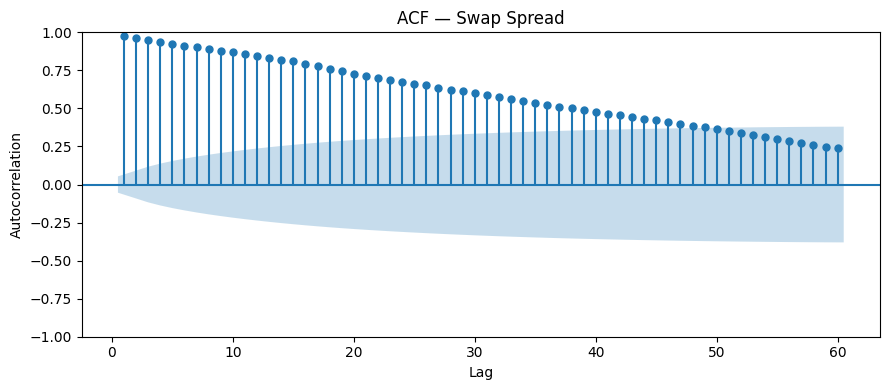

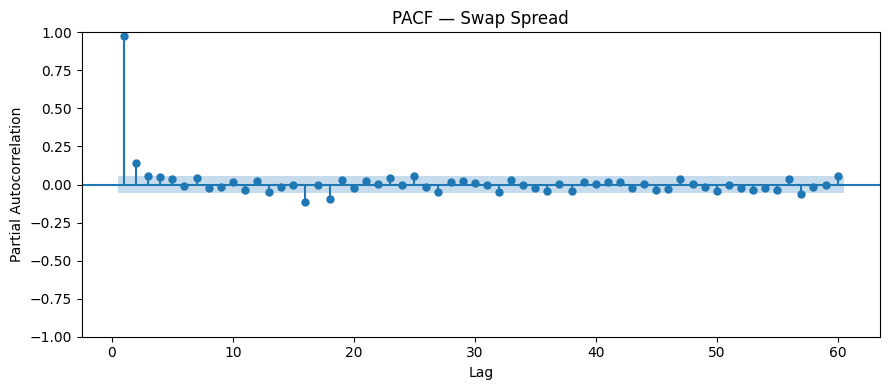

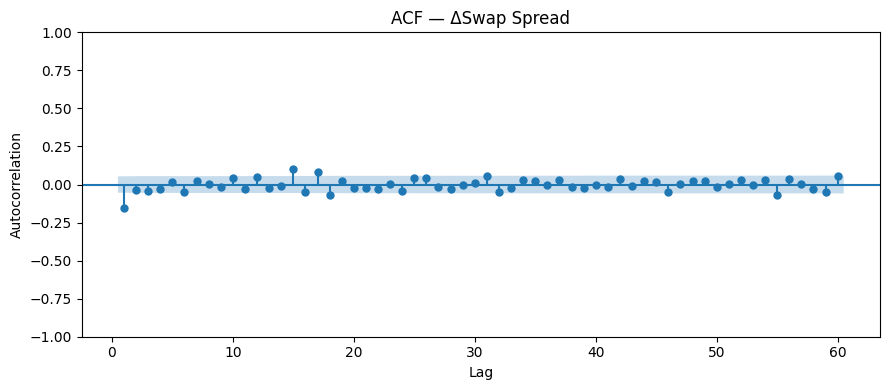

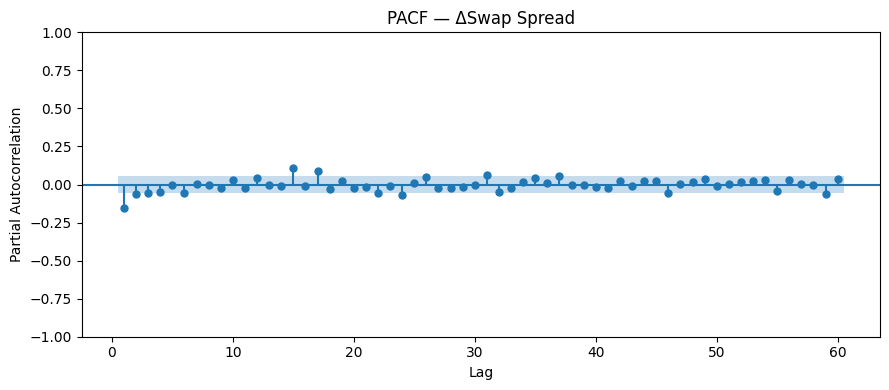

In [23]:
# ==================== ACF & PACF for y and Δy (lags=104) ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ---- Config ----
try:
    PATH_TO_EXCEL
except NameError:
    PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"

DATE_COL   = "Date"
TARGET_COL = "Swap Spread"
ACF_LAGS   = 60   # two years of weekly lags

# ---- Load ----
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

# Level series
y = df[[DATE_COL, TARGET_COL]].dropna().reset_index(drop=True)
y_series = y[TARGET_COL].astype(float).values

# First difference
dy = y[TARGET_COL].diff()
dy = pd.DataFrame({DATE_COL: y[DATE_COL], "ΔSwap Spread": dy}).dropna().reset_index(drop=True)
dy_series = dy["ΔSwap Spread"].astype(float).values

print(f"Samples -> level y: {len(y_series)} | diff Δy: {len(dy_series)}")

# ---- 1) ACF — Swap Spread ----
fig = plt.figure(figsize=(9,4))
ax = plt.gca()
plot_acf(y_series, lags=ACF_LAGS, zero=False, ax=ax)
ax.set_title("ACF — Swap Spread")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.tight_layout(); plt.show()

# ---- 2) PACF — Swap Spread ----
fig = plt.figure(figsize=(9,4))
ax = plt.gca()
plot_pacf(y_series, lags=ACF_LAGS, method='ywmle', zero=False, ax=ax)
ax.set_title("PACF — Swap Spread")
ax.set_xlabel("Lag")
ax.set_ylabel("Partial Autocorrelation")
plt.tight_layout(); plt.show()

# ---- 3) ACF — ΔSwap Spread ----
fig = plt.figure(figsize=(9,4))
ax = plt.gca()
plot_acf(dy_series, lags=ACF_LAGS, zero=False, ax=ax)
ax.set_title("ACF — ΔSwap Spread")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.tight_layout(); plt.show()

# ---- 4) PACF — ΔSwap Spread ----
fig = plt.figure(figsize=(9,4))
ax = plt.gca()
plot_pacf(dy_series, lags=ACF_LAGS, method='ywmle', zero=False, ax=ax)
ax.set_title("PACF — ΔSwap Spread")
ax.set_xlabel("Lag")
ax.set_ylabel("Partial Autocorrelation")
plt.tight_layout(); plt.show()


Chow test

In [24]:
# ======================= Chow Test at a Pre-Specified Break Date =======================
# Model: Δy_t  ~ const + AR lags of Δy + optional exogenous (contemporaneous)
# (Set USE_DIFF=False to run on level y_t — but Δy is recommended.)
# Outputs: F-stat, p-value, k (params), n1, n2, break date used, and model spec printed.

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat

# -------------------- Config --------------------
try:
    PATH_TO_EXCEL
except NameError:
    PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"

DATE_COL   = "Date"
TARGET_COL = "Swap Spread"

# Choose the break date you want to test (must be within sample)
BREAK_DATE = "2008-09-15"        # <-- change this
USE_DIFF   = True                # True: use Δy (recommended). False: use level y
P_LAGS     = 4                   # AR lags of dependent variable (on RHS)
EXOG_NAMES = []                  # e.g., ["VSTOXX","Credit_Risk"] (optional)

# -------------------- Load & prep --------------------
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)

# keep numeric
cols_needed = [TARGET_COL] + EXOG_NAMES
df[cols_needed] = df[cols_needed].apply(pd.to_numeric, errors="coerce")

# Build series
y = df[TARGET_COL].astype(float).copy()
if USE_DIFF:
    dy = y.diff()
    base_series = dy.rename("dep")  # dependent series
else:
    base_series = y.rename("dep")

# Align exogs and drop initial NaNs from differencing/lagging
data = pd.concat([df[[DATE_COL]], base_series, df[EXOG_NAMES]], axis=1)

# Build AR lags of dependent on RHS (exclude current t)
if P_LAGS > 0:
    # lagmat returns matrix with columns [lag1, lag2, ...]
    dep_lags = lagmat(base_series.values, maxlag=P_LAGS, trim='both')
    lag_cols = {f"dep_lag{j}": dep_lags[:, j-1] for j in range(1, P_LAGS+1)}

    # Trim dates/exogs to match lagged rows
    trimmed = data.iloc[P_LAGS:].reset_index(drop=True)
    for name, arr in lag_cols.items():
        trimmed[name] = arr
else:
    trimmed = data.copy()
    lag_cols = {}

# Drop any remaining NaNs
trimmed = trimmed.dropna().reset_index(drop=True)

# Design matrices
Y = trimmed["dep"].values
X_list = []
X_list.append(np.ones((len(trimmed), 1)))  # constant
if P_LAGS > 0:
    for j in range(1, P_LAGS+1):
        X_list.append(trimmed[f"dep_lag{j}"].values.reshape(-1,1))
for name in EXOG_NAMES:
    X_list.append(trimmed[name].values.reshape(-1,1))

X = np.hstack(X_list)
dates = trimmed[DATE_COL].values

# -------------------- Find break index --------------------
break_dt = pd.to_datetime(BREAK_DATE)
# choose first index with date >= break_dt (you can change to nearest if you prefer)
break_idx = np.searchsorted(dates, np.datetime64(break_dt))

if break_idx <= 0 or break_idx >= len(Y):
    raise ValueError(f"Chosen BREAK_DATE={BREAK_DATE} is outside usable sample "
                     f"(usable dates: {str(dates[0])[:10]} to {str(dates[-1])[:10]}).")

actual_break_date = pd.to_datetime(str(dates[break_idx])[:10])

# -------------------- Chow test computation --------------------
# Helper: OLS SSR
def ols_ssr(Xmat, yvec):
    # Solve OLS and compute residual sum of squares
    beta, *_ = np.linalg.lstsq(Xmat, yvec, rcond=None)
    resid = yvec - Xmat @ beta
    return float(resid.T @ resid)

# Split
X1, y1 = X[:break_idx, :], Y[:break_idx]
X2, y2 = X[break_idx:, :], Y[break_idx:]

# Degrees
n1, n2 = len(y1), len(y2)
k = X.shape[1]  # number of parameters including constant

# Guard: each subsample must have > k observations
if n1 <= k or n2 <= k:
    raise ValueError(f"Insufficient observations around break for Chow test: "
                     f"n1={n1}, n2={n2}, k={k} (need n1>k and n2>k).")

# SSRs
SSR_pooled = ols_ssr(X, Y)
SSR_1 = ols_ssr(X1, y1)
SSR_2 = ols_ssr(X2, y2)

# Chow F-statistic:
# F = [(SSR_pooled - (SSR_1 + SSR_2)) / k] / [ (SSR_1 + SSR_2) / (n1 + n2 - 2k) ]
numer = (SSR_pooled - (SSR_1 + SSR_2)) / k
denom = (SSR_1 + SSR_2) / (n1 + n2 - 2*k)
F_stat = numer / denom
p_value = 1.0 - stats.f.cdf(F_stat, dfn=k, dfd=(n1 + n2 - 2*k))

# -------------------- Print report-ready output --------------------
model_label = f"{'Δ' if USE_DIFF else ''}{TARGET_COL} ~ const"
if P_LAGS > 0:
    model_label += " + " + " + ".join([f"L{j}({ 'Δ' if USE_DIFF else ''}{TARGET_COL})" for j in range(1, P_LAGS+1)])
if EXOG_NAMES:
    model_label += " + " + " + ".join(EXOG_NAMES)

print("\n" + "="*90)
print("Chow Test for a Structural Break at a Pre-Specified Date")
print("="*90)
print(f"Model: {model_label}")
print(f"Break date requested : {BREAK_DATE}")
print(f"Break date used      : {actual_break_date.date()}")
print(f"Sample sizes         : n1={n1} (pre-break), n2={n2} (post-break)")
print(f"Parameters (k)       : {k} (incl. constant)")
print(f"SSR pooled           : {SSR_pooled:,.4f}")
print(f"SSR pre + post       : {(SSR_1+SSR_2):,.4f}  (pre={SSR_1:,.4f}, post={SSR_2:,.4f})")
print(f"F-statistic          : {F_stat:.4f}")
print(f"p-value (F_{k},{n1+n2-2*k}) : {p_value:.6f}")
sig = "YES" if p_value < 0.05 else "NO"
print(f"Reject parameter stability at 5%? {sig}")
print("="*90)

# -------------------- What to report in the thesis (template) --------------------
print("\nReport these items:")
print(f" - Model: {model_label}")
print(f" - Break date: {actual_break_date.date()} (pre-specified)")
print(f" - Sample sizes: n1={n1}, n2={n2}; number of parameters k={k}")
print(f" - Chow F = {F_stat:.3f}, p = {p_value:.4f} (df = {k}, {n1+n2-2*k})")
print(" - Interpretation: reject H0 (no break) ⇒ evidence of a structural break in regression parameters at the chosen date."
      " Use CUSUM/MOSUM or QLR as complementary evidence for unknown break timing or multiple breaks.")



Chow Test for a Structural Break at a Pre-Specified Date
Model: ΔSwap Spread ~ const + L1(ΔSwap Spread) + L2(ΔSwap Spread) + L3(ΔSwap Spread) + L4(ΔSwap Spread)
Break date requested : 2008-09-15
Break date used      : 2008-09-19
Sample sizes         : n1=450 (pre-break), n2=876 (post-break)
Parameters (k)       : 5 (incl. constant)
SSR pooled           : 1.7127
SSR pre + post       : 1.6969  (pre=0.3144, post=1.3824)
F-statistic          : 2.4485
p-value (F_5,1316) : 0.032154
Reject parameter stability at 5%? YES

Report these items:
 - Model: ΔSwap Spread ~ const + L1(ΔSwap Spread) + L2(ΔSwap Spread) + L3(ΔSwap Spread) + L4(ΔSwap Spread)
 - Break date: 2008-09-19 (pre-specified)
 - Sample sizes: n1=450, n2=876; number of parameters k=5
 - Chow F = 2.448, p = 0.0322 (df = 5, 1316)
 - Interpretation: reject H0 (no break) ⇒ evidence of a structural break in regression parameters at the chosen date. Use CUSUM/MOSUM or QLR as complementary evidence for unknown break timing or multiple bre

Bai-Perron test

In [38]:
# ======================= Chow test at 23-03-2020 (nearest date) =======================
# Model: Δy_t ~ const + L1(Δy) + ... + Lp(Δy) + optional exogs
# Output: F, p, df; chosen break date (nearest to target); pre/post sizes; pre/post betas.

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat

# -------------------- Config --------------------
try:
    PATH_TO_EXCEL
except NameError:
    PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"

DATE_COL    = "Date"
TARGET_COL  = "Swap Spread"
TARGET_DATE = "2020-03-23"     # <- COVID shock date (dd-mm-yyyy or yyyy-mm-dd both ok)
USE_DIFF    = True             # Δy recommended
P_LAGS      = 4                # AR order
EXOG_NAMES  = []               # e.g., ["VSTOXX","Euribor-OIS","Yield_Slope","Credit_Risk"]

# -------------------- Load & prep --------------------
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)

cols_needed = [TARGET_COL] + EXOG_NAMES
df[cols_needed] = df[cols_needed].apply(pd.to_numeric, errors="coerce")

y = df[TARGET_COL].astype(float)
dep = (y.diff() if USE_DIFF else y).rename("dep")
data = pd.concat([df[[DATE_COL]], dep, df[EXOG_NAMES]], axis=1)

# Build AR lags of dependent on RHS (exclude current t)
if P_LAGS > 0:
    dep_lags = lagmat(dep.values, maxlag=P_LAGS, trim='both')
    trimmed = data.iloc[P_LAGS:].reset_index(drop=True)
    for j in range(1, P_LAGS+1):
        trimmed[f"dep_lag{j}"] = dep_lags[:, j-1]
else:
    trimmed = data.copy()

trimmed = trimmed.dropna().reset_index(drop=True)

Y = trimmed["dep"].values
X_list = [np.ones((len(trimmed), 1))]  # constant
if P_LAGS > 0:
    for j in range(1, P_LAGS+1):
        X_list.append(trimmed[f"dep_lag{j}"].values.reshape(-1,1))
for nm in EXOG_NAMES:
    X_list.append(trimmed[nm].values.reshape(-1,1))
X = np.hstack(X_list)
dates = trimmed[DATE_COL].values

# -------------------- Choose nearest date to TARGET_DATE --------------------
target_dt = pd.to_datetime(TARGET_DATE, dayfirst=("-" in TARGET_DATE and TARGET_DATE.split("-")[0].isdigit() and len(TARGET_DATE.split("-")[0])==2))
# nearest index (absolute difference)
idx_nearest = int(np.argmin(np.abs(dates - np.datetime64(target_dt))))
actual_dt = pd.to_datetime(dates[idx_nearest]).date()

# -------------------- Chow test --------------------
def ols_ssr(Xmat, yvec):
    beta, *_ = np.linalg.lstsq(Xmat, yvec, rcond=None)
    resid = yvec - Xmat @ beta
    return float(resid.T @ resid), beta

n = len(Y)
k = X.shape[1]

# Split at nearest index (post-break starts at idx_nearest)
X1, y1 = X[:idx_nearest, :], Y[:idx_nearest]
X2, y2 = X[idx_nearest:, :], Y[idx_nearest:]

n1, n2 = len(y1), len(y2)
if n1 <= k or n2 <= k:
    raise ValueError(f"Insufficient observations: n1={n1}, n2={n2}, k={k}. "
                     f"Try lowering P_LAGS or picking another date.")

SSR_pooled, beta_pooled = ols_ssr(X,  Y)
SSR_1,      beta_1      = ols_ssr(X1, y1)
SSR_2,      beta_2      = ols_ssr(X2, y2)

numer = (SSR_pooled - (SSR_1 + SSR_2)) / k
denom = (SSR_1 + SSR_2) / (n1 + n2 - 2*k)
F_stat = numer / denom
p_val  = 1.0 - stats.f.cdf(F_stat, dfn=k, dfd=(n1 + n2 - 2*k))

# -------------------- Print report-ready output --------------------
model_label = f"{'Δ' if USE_DIFF else ''}{TARGET_COL} ~ const"
if P_LAGS > 0:
    model_label += " + " + " + ".join([f"L{j}({ 'Δ' if USE_DIFF else ''}{TARGET_COL})" for j in range(1, P_LAGS+1)])
if EXOG_NAMES:
    model_label += " + " + " + ".join(EXOG_NAMES)

print("\n" + "="*100)
print("Chow Test for a Structural Break at COVID (nearest to 23-03-2020)")
print("="*100)
print(f"Model                 : {model_label}")
print(f"Target break date     : {TARGET_DATE}")
print(f"Nearest date in data  : {actual_dt}")
print(f"Sample sizes          : n1={n1} (pre), n2={n2} (post)")
print(f"Parameters (k)        : {k} (incl. const)")
print(f"SSR pooled            : {SSR_pooled:,.4f}")
print(f"SSR pre + post        : {(SSR_1 + SSR_2):,.4f}  (pre={SSR_1:,.4f}, post={SSR_2:,.4f})")
print(f"F-statistic           : {F_stat:.4f}")
print(f"p-value (F_{k},{n1+n2-2*k}) : {p_val:.6f}")
print(f"Reject stability @5%? : {'YES' if p_val < 0.05 else 'NO'}")

# Show pre/post coefficients (magnitude of change)
names = (["const"] +
         [f"L{j}({'Δ' if USE_DIFF else ''}{TARGET_COL})" for j in range(1, P_LAGS+1)] +
         EXOG_NAMES)
coef_tab = pd.DataFrame({
    "Parameter": names,
    "Pre-beta": beta_1,
    "Post-beta": beta_2,
    "Diff (post-pre)": beta_2 - beta_1
})
with pd.option_context("display.float_format", lambda v: f"{v: .4f}",
                       "display.max_rows", 200,
                       "display.width", 120):
    print("\nPre vs Post coefficients (OLS, no HAC):")
    print(coef_tab.to_string(index=False))



Chow Test for a Structural Break at COVID (nearest to 23-03-2020)
Model                 : ΔSwap Spread ~ const + L1(ΔSwap Spread) + L2(ΔSwap Spread) + L3(ΔSwap Spread) + L4(ΔSwap Spread)
Target break date     : 2020-03-23
Nearest date in data  : 2020-03-20
Sample sizes          : n1=1050 (pre), n2=276 (post)
Parameters (k)        : 5 (incl. const)
SSR pooled            : 1.7127
SSR pre + post        : 1.6934  (pre=1.2943, post=0.3991)
F-statistic           : 2.9983
p-value (F_5,1316) : 0.010694
Reject stability @5%? : YES

Pre vs Post coefficients (OLS, no HAC):
       Parameter  Pre-beta  Post-beta  Diff (post-pre)
           const    0.0001    -0.0022          -0.0023
L1(ΔSwap Spread)   -0.2215    -0.0063           0.2152
L2(ΔSwap Spread)   -0.0747    -0.1299          -0.0552
L3(ΔSwap Spread)   -0.0612    -0.0530           0.0083
L4(ΔSwap Spread)   -0.0330    -0.1150          -0.0820


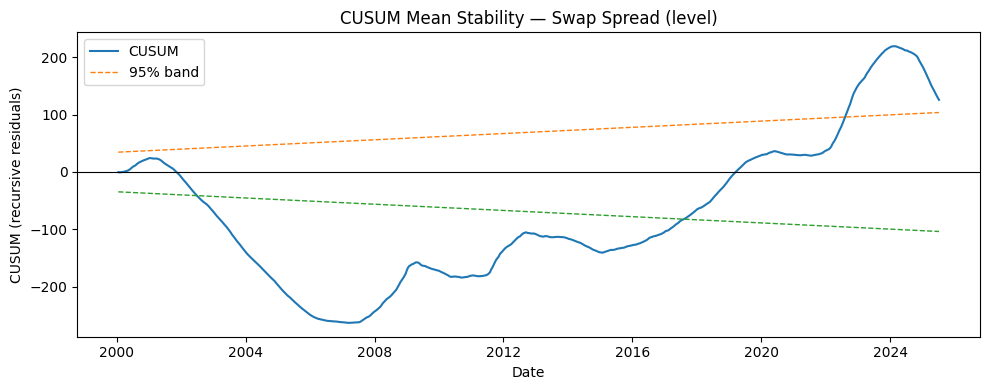


CUSUM (mean) summary — LEVEL
Series          : Swap Spread (level, constant-only)
Bands (alpha)   : 0.95
Recursive start : index 3 | date 2000-01-21
Aligned length n: 1328
CUSUM exited bands? YES


In [43]:
# ======================= Simple CUSUM on mean — LEVEL (no differencing) =======================
# Tests stability of the mean of Swap Spread via CUSUM using a constant-only regression.
# Output: plot with bands and terminal summary (no files).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import recursive_olsresiduals

# -------------------- Config --------------------
try:
    PATH_TO_EXCEL
except NameError:
    PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"

DATE_COL   = "Date"
TARGET_COL = "Swap Spread"

ALPHA_BAND = 0.95     # must be one of {0.90, 0.95, 0.99}

# -------------------- Load --------------------
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

series = df[TARGET_COL].astype(float)
data = pd.concat([df[[DATE_COL]], series.rename("y")], axis=1).dropna().reset_index(drop=True)

Y = data["y"].values
X = np.ones((len(Y), 1))  # constant only
dates = data[DATE_COL].values

# Fit OLS and recursive residuals / CUSUM
ols_res = sm.OLS(Y, X).fit()

# skip at least k+1 (k=1 here), add a small buffer
k = X.shape[1]
skip = max(k + 1, 3)
if len(dates) <= skip:
    raise ValueError(f"Not enough observations for recursion: total={len(dates)}, skip={skip}")

_ALLOWED = np.array([0.90, 0.95, 0.99])
if ALPHA_BAND not in _ALLOWED:
    ALPHA_BAND = float(_ALLOWED[np.argmin(np.abs(_ALLOWED - ALPHA_BAND))])

out = list(recursive_olsresiduals(ols_res, skip=skip, alpha=ALPHA_BAND))
cusum_ci = out[-1]   # (lower, upper)
cusum    = out[-2]   # CUSUM path

# Align lengths (version robustness)
cusum = np.asarray(cusum).ravel()
lower_band = np.asarray(cusum_ci[0]).ravel()
upper_band = np.asarray(cusum_ci[1]).ravel()
n = int(min(len(cusum), len(lower_band), len(upper_band), len(dates) - skip))
cusum, lower_band, upper_band = cusum[:n], lower_band[:n], upper_band[:n]
dates_rec = pd.to_datetime(dates[skip:skip+n])

exited = np.any((cusum < lower_band) | (cusum > upper_band))

# Plot
plt.figure(figsize=(10,4))
plt.plot(dates_rec, cusum, label="CUSUM")
plt.plot(dates_rec, upper_band, linestyle="--", linewidth=1, label=f"{int(ALPHA_BAND*100)}% band")
plt.plot(dates_rec, lower_band, linestyle="--", linewidth=1)
plt.axhline(0.0, color="black", linewidth=0.8)
plt.title("CUSUM Mean Stability — Swap Spread (level)")
plt.xlabel("Date"); plt.ylabel("CUSUM (recursive residuals)")
plt.legend(loc="best")
plt.tight_layout(); plt.show()

# Terminal summary
print("\nCUSUM (mean) summary — LEVEL")
print(f"Series          : {TARGET_COL} (level, constant-only)")
print(f"Bands (alpha)   : {ALPHA_BAND:.2f}")
print(f"Recursive start : index {skip} | date {pd.to_datetime(dates[skip]).date()}")
print(f"Aligned length n: {n}")
print(f"CUSUM exited bands? {'YES' if exited else 'NO'}")


Usable obs (mean-break search, LEVEL): n=1331

Mean-only multiple breaks — LEVEL (ruptures Dynp, l2)
Trim fraction (min seg size): 0.10  (min_size=133)
Candidate breaks searched: 0..8
Selected # breaks by BIC: m = 6
Break dates (end of pre-break segment): 2002-07-26, 2007-06-15, 2012-08-17, 2015-03-20, 2017-10-20, 2022-11-25

Segment means (LEVEL)
 Segment      Start        End   N    Mean
       1 1999-12-31 2002-07-26 135  0.4350
       2 2002-08-02 2007-06-15 255  0.1605
       3 2007-06-22 2012-08-17 270  0.3905
       4 2012-08-24 2015-03-20 135  0.2656
       5 2015-03-27 2017-10-20 135  0.3925
       6 2017-10-27 2022-11-25 265  0.4785
       7 2022-12-02 2025-07-04 136  0.3330


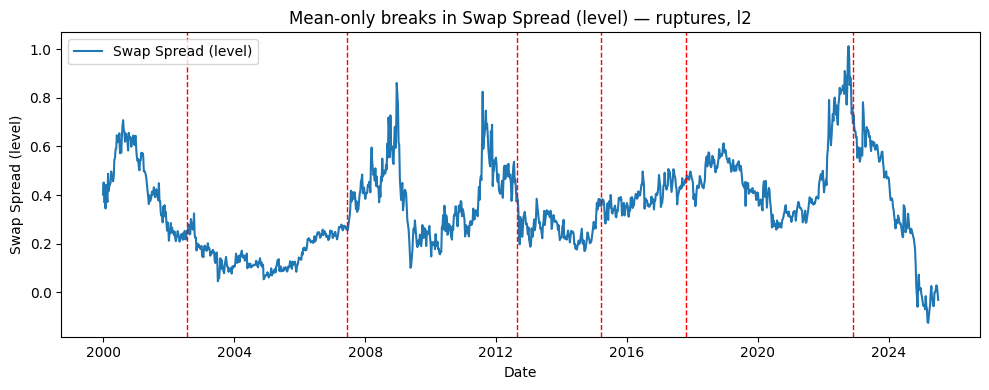

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Config
try:
    PATH_TO_EXCEL
except NameError:
    PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"

DATE_COL   = "Date"
TARGET_COL = "Swap Spread"

TRIM_FRAC  = 0.10      # min fraction per segment (e.g., 10%)
MAX_BREAKS = 8         # search up to K

# Load
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

y  = df[TARGET_COL].astype(float).values
dt = df[DATE_COL].values

# Drop NaNs
mask = np.isfinite(y)
y    = y[mask]
dt   = dt[mask]
n = len(y)

print(f"Usable obs (mean-break search, LEVEL): n={n}")

# ruptures
try:
    import ruptures as rpt
except Exception as e:
    raise ImportError(
        "This cell needs the 'ruptures' package.\n"
        "Install it once with: pip install ruptures\n"
        f"(Original import error: {e})"
    )

# Helper: BIC for given segmentation (mean-only)
def mean_bic(series, ends):
    # ends: list of segment end indices INCLUDING n (e.g., [t1, t2, ..., n])
    series = np.asarray(series)
    n = len(series)
    ssr_total = 0.0
    seg_info = []
    start = 0
    for end in ends:
        seg = series[start:end]
        if len(seg) <= 1:
            return np.inf, []
        mu = float(np.mean(seg))
        ssr = float(np.sum((seg - mu)**2))
        ssr_total += ssr
        seg_info.append((start, end, mu))
        start = end
    # params: 1 mean per segment
    k_total = len(seg_info) * 1
    sigma2 = ssr_total / n
    bic = n * np.log(sigma2) + k_total * np.log(n)
    return bic, seg_info

# Minimum segment size (trimming)
min_size = max(int(np.floor(TRIM_FRAC * n)), 20)  # at least ~20 obs per seg
algo = rpt.Dynp(model="l2", min_size=min_size).fit(y)

best = None
for m in range(0, MAX_BREAKS + 1):
    ends = sorted(algo.predict(n_bkps=m))   # includes n
    bic, seg_info = mean_bic(y, ends)
    if not np.isfinite(bic):
        continue
    if (best is None) or (bic < best["bic"]):
        best = {"m": m, "ends": ends, "bic": bic, "seg_info": seg_info}

if best is None:
    raise RuntimeError("No admissible segmentation found. Consider lowering TRIM_FRAC or MAX_BREAKS.")

# Results
m = best["m"]
ends = best["ends"]
break_idx = ends[:-1]
break_dates = [pd.to_datetime(dt[i-1]).date() for i in break_idx]

print("\n" + "="*100)
print("Mean-only multiple breaks — LEVEL (ruptures Dynp, l2)")
print("="*100)
print(f"Trim fraction (min seg size): {TRIM_FRAC:.2f}  (min_size={min_size})")
print(f"Candidate breaks searched: 0..{MAX_BREAKS}")
print(f"Selected # breaks by BIC: m = {m}")
print(f"Break dates (end of pre-break segment): {', '.join(map(str, break_dates)) if m>0 else 'none'}")

# Segment means table
rows = []
for seg_id, (s, e, mu) in enumerate(best["seg_info"], start=1):
    rows.append({
        "Segment": seg_id,
        "Start": str(pd.to_datetime(dt[s]).date()),
        "End":   str(pd.to_datetime(dt[e-1]).date()),
        "N": int(e - s),
        "Mean": float(mu)
    })
seg_table = pd.DataFrame(rows)

pd.set_option("display.width", 160)
with pd.option_context("display.float_format", lambda v: f"{v: .4f}"):
    print("\nSegment means (LEVEL)")
    print(seg_table.to_string(index=False))

# Plot with break lines
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(dt), y, label="Swap Spread (level)")
for i in break_idx:
    plt.axvline(pd.to_datetime(dt[i-1]), color="red", linestyle="--", linewidth=1)
plt.title("Mean-only breaks in Swap Spread (level) — ruptures, l2")
plt.xlabel("Date"); plt.ylabel("Swap Spread (level)")
plt.legend()
plt.tight_layout(); plt.show()


Series: level Swap Spread | usable n=1331

Bai–Perron–style mean breaks on level (sequential sup-F with wild bootstrap)
Trimming           : 0.15
Max breaks allowed : 5
Bootstrap reps     : 499
Selected breaks    : m = 5
Break dates        : 2007-07-20, 2009-02-27, 2010-09-17, 2016-04-01, 2024-02-16

Segment means (level)
 Segment      Start        End   N    Mean
       1 1999-12-31 2007-07-13 394  0.2558
       2 2007-07-20 2009-02-20  84  0.4862
       3 2009-02-27 2010-09-10  81  0.2417
       4 2010-09-17 2016-03-25 289  0.3403
       5 2016-04-01 2024-02-09 410  0.4813
       6 2024-02-16 2025-07-04  73  0.1254

Accepted breaks (sequential sup-F with wild bootstrap)
 Break #       Date  Index     sup-F  p_boot Segment start Segment end  Segment n
       1 2007-07-20    394  176.1538  0.0020    1999-12-31  2025-07-04       1331
       2 2016-04-01    848   52.0022  0.0020    2007-07-20  2025-07-04        937
       3 2009-02-27    478  151.3913  0.0020    2007-07-20  2016-03-25   

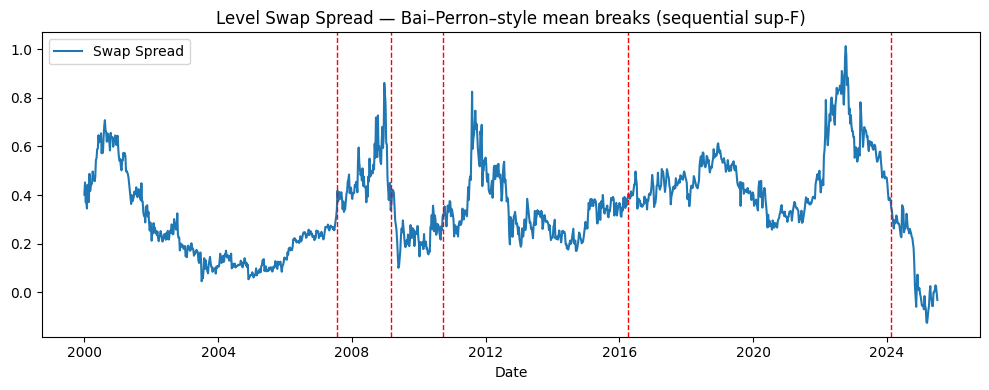

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# -------------------- Config --------------------
try:
    PATH_TO_EXCEL
except NameError:
    PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"

DATE_COL   = "Date"
TARGET_COL = "Swap Spread"

TRIM_FRAC   = 0.15   # standard trimming (15%)
MAX_BREAKS  = 5      # cap on # breaks to search
N_BOOT      = 499    # wild bootstrap reps for p-values (use 999 for final)
ALPHA_CRIT  = 0.05   # significance level for adding a break
SEED        = 123
np.random.seed(SEED)

# -------------------- Load level series --------------------
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

y_all = df[TARGET_COL].astype(float).values
dts   = df[DATE_COL].values
mask  = np.isfinite(y_all)
y_all = y_all[mask]
dts   = dts[mask]
n_all = len(y_all)

print(f"Series: level {TARGET_COL} | usable n={n_all}")

# -------------------- Helpers --------------------
def ssr_mean(y):
    mu = np.mean(y)
    r  = y - mu
    return float(np.dot(r, r)), mu

def chow_F_mean(y, idx):
    """Mean-only Chow F at split 'idx' (post starts at idx)."""
    y1, y2 = y[:idx], y[idx:]
    n1, n2 = len(y1), len(y2)
    if n1 <= 1 or n2 <= 1:
        return np.nan
    SSR_pooled, _ = ssr_mean(y)
    SSR_1, _      = ssr_mean(y1)
    SSR_2, _      = ssr_mean(y2)
    # parameters: 1 mean; adding one break adds 1 parameter
    k = 1
    numer = (SSR_pooled - (SSR_1 + SSR_2)) / k
    denom = (SSR_1 + SSR_2) / (n1 + n2 - 2*k)
    return float(numer / denom)

def supF_segment(y, trim_frac, n_boot):
    """Return sup-F, argmax index (relative to segment), bootstrap p-value, and F(t) array."""
    n = len(y)
    left  = int(np.floor(trim_frac * n))
    right = n - int(np.floor(trim_frac * n))
    if right - left <= 3:
        return np.nan, None, np.nan, np.full(n, np.nan)
    cand = np.arange(left, right)

    F_vals = np.full(n, np.nan)
    for idx in cand:
        F_vals[idx] = chow_F_mean(y, idx)

    supF = np.nanmax(F_vals)
    t_star = int(np.nanargmax(F_vals))

    # Wild bootstrap under H0: y = mu + u, resample u with Rademacher multipliers
    SSR0, mu0 = ssr_mean(y)
    u = y - mu0
    supF_boot = np.zeros(n_boot)
    for b in range(n_boot):
        mult = np.random.choice([-1.0, 1.0], size=n)
        y_b  = mu0 + u * mult
        Fb = np.full(n, np.nan)
        for idx in cand:
            Fb[idx] = chow_F_mean(y_b, idx)
        supF_boot[b] = np.nanmax(Fb)
    p_boot = (np.sum(supF_boot >= supF) + 1.0) / (n_boot + 1.0)
    return supF, t_star, p_boot, F_vals

# -------------------- Sequential search (binary segmentation with sup-F and bootstrap) --------------------
breaks = []  # absolute indices (0..n_all)
queue  = [(0, n_all)]  # segments to test as (start, end)
stats_rows = []
total_breaks = 0

while queue and total_breaks < MAX_BREAKS:
    s, e = queue.pop(0)
    y_seg = y_all[s:e]
    n_seg = len(y_seg)

    # sup-F within this segment
    supF, t_rel, pval, F_vals = supF_segment(y_seg, TRIM_FRAC, N_BOOT)
    if not np.isfinite(supF) or t_rel is None:
        continue

    # Decide to split?
    if pval < ALPHA_CRIT:
        t_abs = s + t_rel
        breaks.append(t_abs)
        total_breaks += 1

        # Save stats for reporting
        stats_rows.append({
            "Break #": total_breaks,
            "Date": pd.to_datetime(dts[t_abs]).date(),
            "Index": int(t_abs),
            "sup-F": float(supF),
            "p_boot": float(pval),
            "Segment start": pd.to_datetime(dts[s]).date(),
            "Segment end":   pd.to_datetime(dts[e-1]).date(),
            "Segment n": int(n_seg)
        })

        # Push left and right subsegments for further testing
        # Ensure each side keeps enough obs for trimming later
        left_len  = t_abs - s
        right_len = e - t_abs
        min_len   = max(int(np.floor(TRIM_FRAC * n_seg)), 20)
        if left_len  > 2*min_len:
            queue.append((s, t_abs))
        if right_len > 2*min_len:
            queue.append((t_abs, e))
    # if not significant, do nothing (no split)

# Sort break indices and build final segments
breaks = sorted(set(breaks))
segments = [0] + breaks + [n_all]

# -------------------- Summaries --------------------
print("\n" + "="*100)
print("Bai–Perron–style mean breaks on level (sequential sup-F with wild bootstrap)")
print("="*100)
print(f"Trimming           : {TRIM_FRAC:.2f}")
print(f"Max breaks allowed : {MAX_BREAKS}")
print(f"Bootstrap reps     : {N_BOOT}")
print(f"Selected breaks    : m = {len(breaks)}")
if breaks:
    print("Break dates        : " + ", ".join(str(pd.to_datetime(dts[i]).date()) for i in breaks))
else:
    print("Break dates        : none")

# Segment means table
rows = []
for j in range(len(segments)-1):
    s, e = segments[j], segments[j+1]
    mu = float(np.mean(y_all[s:e]))
    rows.append({
        "Segment": j+1,
        "Start": str(pd.to_datetime(dts[s]).date()),
        "End":   str(pd.to_datetime(dts[e-1]).date()),
        "N": int(e - s),
        "Mean": mu
    })
seg_table = pd.DataFrame(rows)

# Stats table for each accepted break
bp_table = pd.DataFrame(stats_rows)

pd.set_option("display.width", 160)
with pd.option_context("display.float_format", lambda v: f"{v: .4f}"):
    print("\nSegment means (level)")
    print(seg_table.to_string(index=False))
    if len(bp_table):
        print("\nAccepted breaks (sequential sup-F with wild bootstrap)")
        print(bp_table.to_string(index=False))
    else:
        print("\nNo significant breaks found at the chosen settings.")

# -------------------- Plot with vertical break lines --------------------
plt.figure(figsize=(10,4))
plt.plot(dts, y_all, label="Swap Spread")
for i in breaks:
    plt.axvline(pd.to_datetime(dts[i]), color="red", linestyle="--", linewidth=1)
plt.title("Level Swap Spread — Bai–Perron–style mean breaks (sequential sup-F)")
plt.xlabel("Date"); plt.ylabel("")
plt.legend()
plt.tight_layout(); plt.show()


Mean+Variance BP — usable n=1331 (level Swap Spread)
Note: Given n=1331 and min_size=199, the maximum feasible breaks are 5. Restricting search to m ∈ [0, 5].

Bai–Perron–style mean + variance breaks (Gaussian cost)
Trim fraction (min seg size): 0.15  (min_size=199)
Feasible breaks searched     : 0..5
Selected # breaks by BIC     : m = 5
Break dates (end of pre-break segment): 2003-10-24, 2007-08-24, 2012-08-17, 2016-06-17, 2020-05-22
BIC                          : -4892.371

Segment mean & variance (level)
 Segment      Start        End   N    Mean  Variance  Std. Dev.
       1 1999-12-31 2003-10-24 200  0.3497    0.0313     0.1769
       2 2003-10-31 2007-08-24 200  0.1658    0.0058     0.0764
       3 2007-08-31 2012-08-17 260  0.3922    0.0223     0.1495
       4 2012-08-24 2016-06-17 200  0.2967    0.0044     0.0660
       5 2016-06-24 2020-05-22 205  0.4552    0.0042     0.0650
       6 2020-05-29 2025-07-04 266  0.4070    0.0630     0.2510


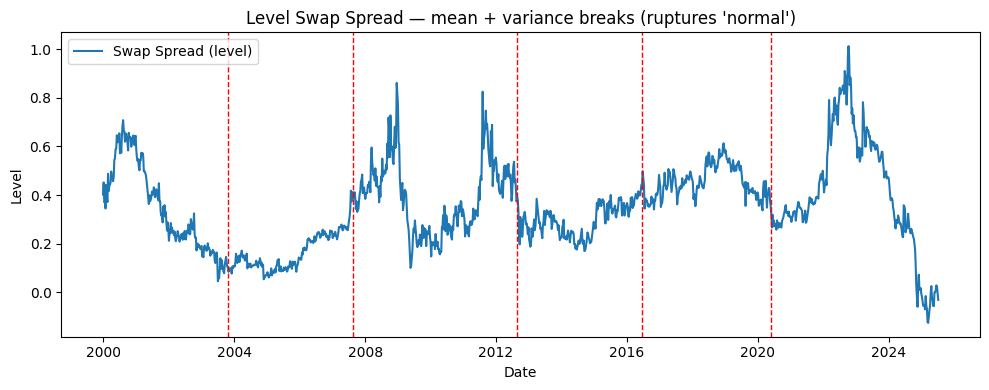

In [51]:
# ===================== Bai–Perron–style MEAN + VARIANCE breaks (level) — FIXED =====================
# - Series: Swap Spread (level)
# - Segment model: y_t ~ N( μ_j , σ_j^2 )
# - Detection: ruptures Dynp (model="normal"), with feasibility check for n_bkps
# - Selection: BIC over feasible m
# - Output: break dates, segment means/variances, plot
# ================================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------- Config --------------------
try:
    PATH_TO_EXCEL
except NameError:
    PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"

DATE_COL   = "Date"
TARGET_COL = "Swap Spread"

TRIM_FRAC  = 0.15      # standard Bai–Perron trimming
MAX_BREAKS = 6         # user cap (actual feasible cap computed below)

# -------------------- Load --------------------
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

y_all = df[TARGET_COL].astype(float).values
dt    = df[DATE_COL].values

mask = np.isfinite(y_all)
y_all = y_all[mask]
dt    = dt[mask]
n = len(y_all)
print(f"Mean+Variance BP — usable n={n} (level {TARGET_COL})")

# -------------------- ruptures (Gaussian cost) --------------------
try:
    import ruptures as rpt
    from ruptures.exceptions import BadSegmentationParameters
except Exception as e:
    raise ImportError(
        "This cell needs the 'ruptures' package. Install once with: pip install ruptures\n"
        f"(Original import error: {e})"
    )

def bic_mean_var(y, ends):
    """
    BIC for segmentation with end indices 'ends' (including n).
    Each segment estimates μ_j, σ_j^2. Gaussian likelihood -> SSR around segment mean.
    BIC = n * log(SSR_total / n) + (2 * #segments) * log(n).
    """
    y = np.asarray(y, float)
    n = len(y)
    ssr_total = 0.0
    seg_info = []
    start = 0
    for end in ends:
        seg = y[start:end]
        if len(seg) <= 2:
            return np.inf, []
        mu = float(np.mean(seg))
        ssr = float(np.sum((seg - mu) ** 2))
        var = float(np.var(seg, ddof=1)) if len(seg) > 1 else np.nan
        ssr_total += ssr
        seg_info.append((start, end, mu, var))
        start = end
    k_total = 2 * len(seg_info)  # mean + variance per segment
    sigma2_hat = ssr_total / n
    bic = n * np.log(max(sigma2_hat, 1e-12)) + k_total * np.log(n)
    return bic, seg_info

# Minimum segment size (trimming)
min_size = max(int(np.floor(TRIM_FRAC * n)), 25)
algo = rpt.Dynp(model="normal", min_size=min_size).fit(y_all)

# Compute maximum feasible number of breaks given n and min_size:
# (m + 1) * min_size <= n  ->  m <= floor(n / min_size) - 1
feasible_max_bkps = max(0, (n // min_size) - 1)
upper_m = min(MAX_BREAKS, feasible_max_bkps)
if upper_m < MAX_BREAKS:
    print(f"Note: Given n={n} and min_size={min_size}, the maximum feasible breaks are {feasible_max_bkps}. "
          f"Restricting search to m ∈ [0, {upper_m}].")

best = None
for m in range(0, upper_m + 1):
    try:
        ends = sorted(algo.predict(n_bkps=m))  # includes n
    except BadSegmentationParameters:
        # Skip infeasible m (shouldn't happen after the cap, but safe)
        continue
    bic, seg_info = bic_mean_var(y_all, ends)
    if not np.isfinite(bic):
        continue
    if (best is None) or (bic < best["bic"]):
        best = {"m": m, "ends": ends, "bic": bic, "seg_info": seg_info}

if best is None:
    raise RuntimeError("No admissible segmentation found. Consider lowering TRIM_FRAC or MAX_BREAKS.")

# -------------------- Summaries --------------------
m = best["m"]
ends = best["ends"]
break_idx = ends[:-1]  # change points (end of each segment)
break_dates = [pd.to_datetime(dt[i-1]).date() for i in break_idx]

print("\n" + "="*100)
print("Bai–Perron–style mean + variance breaks (Gaussian cost)")
print("="*100)
print(f"Trim fraction (min seg size): {TRIM_FRAC:.2f}  (min_size={min_size})")
print(f"Feasible breaks searched     : 0..{upper_m}")
print(f"Selected # breaks by BIC     : m = {m}")
print(f"Break dates (end of pre-break segment): {', '.join(map(str, break_dates)) if m>0 else 'none'}")
print(f"BIC                          : {best['bic']:.3f}")

# Segment table
rows = []
for seg_id, (s, e, mu, var) in enumerate(best["seg_info"], start=1):
    rows.append({
        "Segment": seg_id,
        "Start": str(pd.to_datetime(dt[s]).date()),
        "End":   str(pd.to_datetime(dt[e-1]).date()),
        "N": int(e - s),
        "Mean": float(mu),
        "Variance": float(var),
        "Std. Dev.": float(np.sqrt(var)) if np.isfinite(var) else np.nan
    })

seg_table = pd.DataFrame(rows)
pd.set_option("display.width", 160)
with pd.option_context("display.float_format", lambda v: f"{v: .4f}"):
    print("\nSegment mean & variance (level)")
    print(seg_table.to_string(index=False))

# -------------------- Plot --------------------
plt.figure(figsize=(10,4))
plt.plot(dt, y_all, label="Swap Spread (level)")
for i in break_idx:
    plt.axvline(pd.to_datetime(dt[i-1]), color="red", linestyle="--", linewidth=1)
plt.title("Level Swap Spread — mean + variance breaks (ruptures 'normal')")
plt.xlabel("Date"); plt.ylabel("Level")
plt.legend()
plt.tight_layout(); plt.show()


In [62]:
# ======================= Chow test at end-December 2024 (nearest date) =======================
# Model: Δy_t ~ const + L1(Δy) + ... + Lp(Δy)  (+ optional exogs)
# Output: F, p, df; chosen split date; pre/post sizes; coefficient changes.

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat

# -------------------- Config --------------------
try:
    PATH_TO_EXCEL
except NameError:
    PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"

DATE_COL    = "Date"
TARGET_COL  = "Swap Spread"
TARGET_DATE = "2023-01-31"   # end of December 2024
USE_DIFF    = True           # True: Δ swap spread (recommended); False: level
P_LAGS      = 4              # AR order
EXOG_NAMES  = []             # e.g., ["VSTOXX","Euribor-OIS","Yield_Slope","Credit_Risk"]

# -------------------- Load & prep --------------------
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)

cols_needed = [TARGET_COL] + EXOG_NAMES
df[cols_needed] = df[cols_needed].apply(pd.to_numeric, errors="coerce")

y = df[TARGET_COL].astype(float)
dep = (y.diff() if USE_DIFF else y).rename("dep")
data = pd.concat([df[[DATE_COL]], dep, df[EXOG_NAMES]], axis=1)

# Build AR lags of dependent on RHS (exclude current t)
if P_LAGS > 0:
    dep_lags = lagmat(dep.values, maxlag=P_LAGS, trim='both')
    trimmed = data.iloc[P_LAGS:].reset_index(drop=True)
    for j in range(1, P_LAGS+1):
        trimmed[f"dep_lag{j}"] = dep_lags[:, j-1]
else:
    trimmed = data.copy()

trimmed = trimmed.dropna().reset_index(drop=True)

Y = trimmed["dep"].values
X_parts = [np.ones((len(trimmed), 1))]  # constant
if P_LAGS > 0:
    for j in range(1, P_LAGS+1):
        X_parts.append(trimmed[f"dep_lag{j}"].values.reshape(-1,1))
for nm in EXOG_NAMES:
    X_parts.append(trimmed[nm].values.reshape(-1,1))
X = np.hstack(X_parts)
dates = trimmed[DATE_COL].values

# -------------------- Choose nearest date to TARGET_DATE --------------------
# Accept both yyyy-mm-dd and dd-mm-yyyy by detecting day-first
try:
    target_dt = pd.to_datetime(TARGET_DATE, dayfirst=False)
except Exception:
    target_dt = pd.to_datetime(TARGET_DATE, dayfirst=True)

idx_nearest = int(np.argmin(np.abs(dates - np.datetime64(target_dt))))
actual_dt = pd.to_datetime(dates[idx_nearest]).date()

# -------------------- Chow test --------------------
def ols_ssr(Xmat, yvec):
    beta, *_ = np.linalg.lstsq(Xmat, yvec, rcond=None)
    resid = yvec - Xmat @ beta
    return float(resid.T @ resid), beta

n = len(Y)
k = X.shape[1]

X1, y1 = X[:idx_nearest, :], Y[:idx_nearest]
X2, y2 = X[idx_nearest:, :], Y[idx_nearest:]

n1, n2 = len(y1), len(y2)
if n1 <= k or n2 <= k:
    raise ValueError(f"Insufficient observations around the split: n1={n1}, n2={n2}, k={k}. "
                     f"Consider lowering P_LAGS or choosing a different date.")

SSR_pooled, beta_pooled = ols_ssr(X,  Y)
SSR_1,      beta_1      = ols_ssr(X1, y1)
SSR_2,      beta_2      = ols_ssr(X2, y2)

numer = (SSR_pooled - (SSR_1 + SSR_2)) / k
denom = (SSR_1 + SSR_2) / (n1 + n2 - 2*k)
F_stat = numer / denom
p_val  = 1.0 - stats.f.cdf(F_stat, dfn=k, dfd=(n1 + n2 - 2*k))

# -------------------- Print report-ready output --------------------
lhs_label = ("Δ" if USE_DIFF else "") + TARGET_COL
rhs_terms = ["const"] + ([f"L{j}({lhs_label})" for j in range(1, P_LAGS+1)] if P_LAGS>0 else [])
rhs_terms += EXOG_NAMES
model_label = f"{lhs_label} ~ " + " + ".join(rhs_terms)

print("\n" + "="*100)
print("Chow Test for a Structural Break at end-Dec 2024 (nearest date)")
print("="*100)
print(f"Model                 : {model_label}")
print(f"Target break date     : {TARGET_DATE}")
print(f"Nearest date in data  : {actual_dt}")
print(f"Sample sizes          : n1={n1} (pre), n2={n2} (post)")
print(f"Parameters (k)        : {k} (incl. const)")
print(f"SSR pooled            : {SSR_pooled:,.4f}")
print(f"SSR pre + post        : {(SSR_1 + SSR_2):,.4f}  (pre={SSR_1:,.4f}, post={SSR_2:,.4f})")
print(f"F-statistic           : {F_stat:.4f}")
print(f"p-value (F_{k},{n1+n2-2*k}) : {p_val:.6f}")
print(f"Reject stability @5%? : {'YES' if p_val < 0.05 else 'NO'}")

# Coefficient comparison table
param_names = (["const"] +
               [f"L{j}({lhs_label})" for j in range(1, P_LAGS+1)] +
               EXOG_NAMES)
coef_tab = pd.DataFrame({
    "Parameter": param_names,
    "Pre-beta": beta_1,
    "Post-beta": beta_2,
    "Diff (post-pre)": beta_2 - beta_1
})
with pd.option_context("display.float_format", lambda v: f"{v: .4f}",
                       "display.max_rows", 200,
                       "display.width", 120):
    print("\nPre vs Post coefficients (OLS, no HAC):")
    print(coef_tab.to_string(index=False))



Chow Test for a Structural Break at end-Dec 2024 (nearest date)
Model                 : ΔSwap Spread ~ const + L1(ΔSwap Spread) + L2(ΔSwap Spread) + L3(ΔSwap Spread) + L4(ΔSwap Spread)
Target break date     : 2023-01-31
Nearest date in data  : 2023-02-03
Sample sizes          : n1=1199 (pre), n2=127 (post)
Parameters (k)        : 5 (incl. const)
SSR pooled            : 1.7127
SSR pre + post        : 1.6940  (pre=1.5360, post=0.1579)
F-statistic           : 2.9010
p-value (F_5,1316) : 0.013033
Reject stability @5%? : YES

Pre vs Post coefficients (OLS, no HAC):
       Parameter  Pre-beta  Post-beta  Diff (post-pre)
           const    0.0003    -0.0070          -0.0073
L1(ΔSwap Spread)   -0.1935     0.0178           0.2113
L2(ΔSwap Spread)   -0.0736    -0.2054          -0.1318
L3(ΔSwap Spread)   -0.0631    -0.0576           0.0055
L4(ΔSwap Spread)   -0.0390    -0.2037          -0.1647


Variance-break BP — usable n=1326 (after differencing & 4 lags) | proxy=e^2
Note: Given n=1326 and min_size=198, the maximum feasible breaks are 5. Restricting search to m ∈ [0, 5].

Bai–Perron variance-only breaks (mean breaks on e_t^2)
Trim fraction (min seg size): 0.15  (min_size=198)
Feasible breaks searched     : 0..5
Selected # breaks by BIC     : m = 3
Break dates (end of pre-break segment): 2008-02-15, 2012-10-26, 2021-08-20
BIC                          : -14711.660

Variance-regime table (based on residual squares)
 Segment      Start        End   N  Var proxy mean  Variance (≈)  Std. Dev. (≈)
       1 2000-02-04 2008-02-15 420          0.0006        0.0006         0.0244
       2 2008-02-22 2012-10-26 245          0.0032        0.0032         0.0564
       3 2012-11-02 2021-08-20 460          0.0007        0.0007         0.0261
       4 2021-08-27 2025-07-04 201          0.0018        0.0018         0.0428


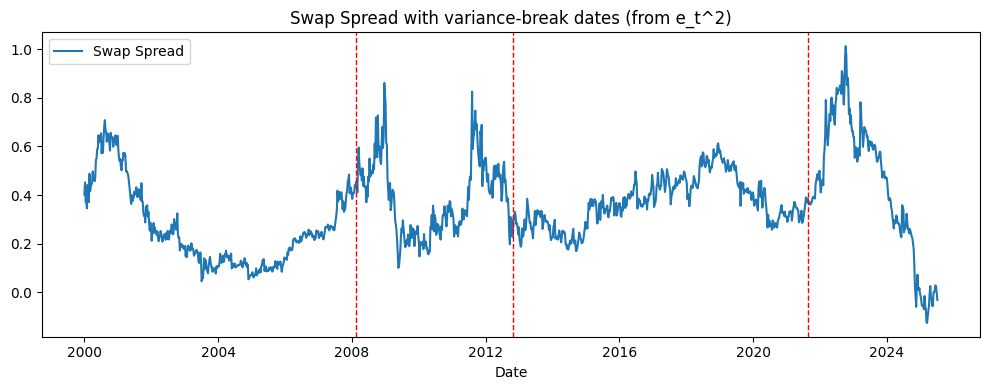

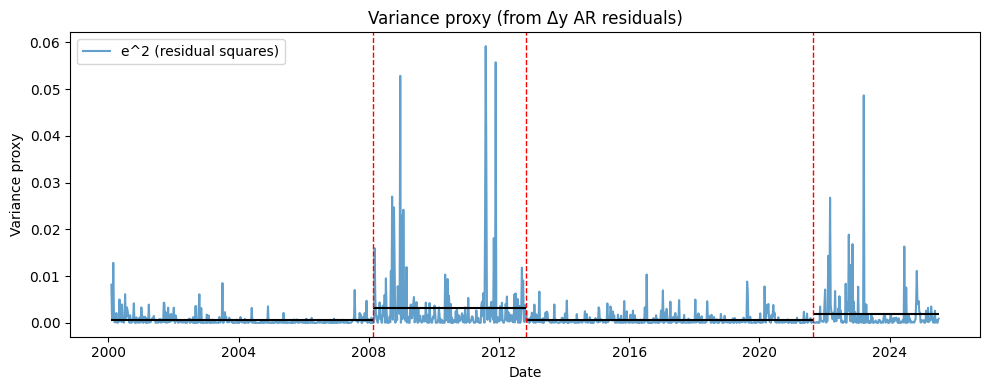

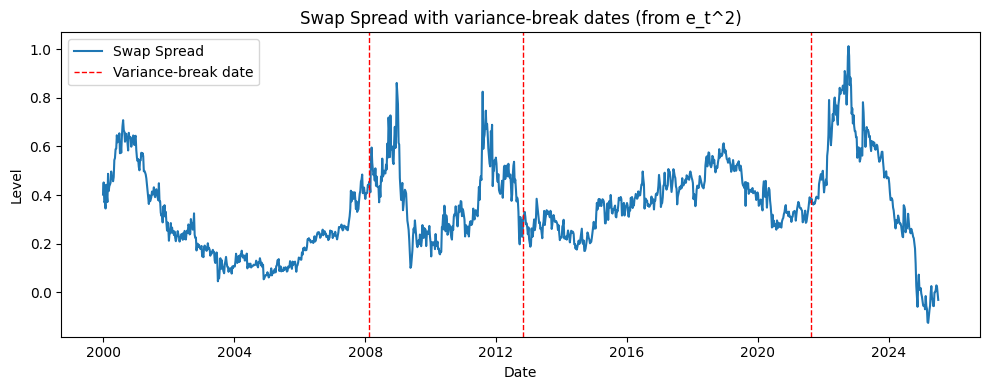

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat

# -------------------- Config --------------------
try:
    PATH_TO_EXCEL
except NameError:
    PATH_TO_EXCEL = "/Users/anwarouni/Downloads/Thesis/Code/output_data.xlsx"

DATE_COL   = "Date"
TARGET_COL = "Swap Spread"

P_LAGS     = 4        # AR order for mean filter on Δy
TRIM_FRAC  = 0.15     # BP trimming fraction
MAX_BREAKS = 6        # user cap; actual feasible cap computed below
USE_LOGVAR = False    # True -> use log(e^2) proxy to temper outliers

# -------------------- Load & mean filter --------------------
df = pd.read_excel(PATH_TO_EXCEL, engine="openpyxl")
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

y_level = df[TARGET_COL].astype(float).values
dates_full = df[DATE_COL].values

# Δy for mean filtering
dy = pd.Series(y_level).diff().values

# Build AR(p) regressors for Δy
if P_LAGS > 0:
    lags = lagmat(dy, maxlag=P_LAGS, trim='both')            # (T-P, p)
    Y = dy[P_LAGS:]                                          # target
    dates = dates_full[P_LAGS:]
    mask = np.isfinite(Y) & np.isfinite(lags).all(axis=1)
    Y, lags, dates = Y[mask], lags[mask], dates[mask]
    X = np.column_stack([np.ones(len(Y)), lags])             # const + lags
else:
    Y = dy[1:]; dates = dates_full[1:]; X = np.ones((len(Y), 1))

# OLS mean model to get residuals
ols = sm.OLS(Y, X).fit()
e = ols.resid.copy()
v = e**2
if USE_LOGVAR:
    v = np.log(v + 1e-8)

print(f"Variance-break BP — usable n={len(v)} (after differencing & {P_LAGS} lags) | "
      f"proxy={'log(e^2)' if USE_LOGVAR else 'e^2'}")

# -------------------- Bai–Perron on variance proxy v_t --------------------
try:
    import ruptures as rpt
    from ruptures.exceptions import BadSegmentationParameters
except Exception as e:
    raise ImportError("This cell needs 'ruptures'. Install once with: pip install ruptures") from e

def mean_bic(series, ends):
    """BIC for mean-only segmentation of 'series' with ends including n."""
    series = np.asarray(series, float)
    n = len(series)
    ssr_total = 0.0
    seg_info = []
    s = 0
    for e in ends:
        seg = series[s:e]
        if len(seg) <= 1:
            return np.inf, []
        mu = float(np.mean(seg))
        ssr_total += float(np.sum((seg - mu)**2))
        seg_info.append((s, e, mu))
        s = e
    k_total = len(seg_info) * 1
    sigma2 = ssr_total / n
    bic = n * np.log(max(sigma2, 1e-12)) + k_total * np.log(n)
    return bic, seg_info

n = len(v)
# Minimum segment size (trimming)
min_size = max(int(np.floor(TRIM_FRAC * n)), max(20, P_LAGS + 8))
algo = rpt.Dynp(model="l2", min_size=min_size).fit(v)

# Feasible m: (m+1)*min_size <= n -> m <= floor(n/min_size) - 1
feasible_max_bkps = max(0, (n // min_size) - 1)
upper_m = min(MAX_BREAKS, feasible_max_bkps)
if upper_m < MAX_BREAKS:
    print(f"Note: Given n={n} and min_size={min_size}, the maximum feasible breaks are {feasible_max_bkps}. "
          f"Restricting search to m ∈ [0, {upper_m}].")

best = None
for m in range(0, upper_m + 1):
    try:
        ends = sorted(algo.predict(n_bkps=m))  # includes n
    except BadSegmentationParameters:
        continue
    bic, seg_info = mean_bic(v, ends)
    if not np.isfinite(bic):
        continue
    if (best is None) or (bic < best["bic"]):
        best = {"m": m, "ends": ends, "bic": bic, "seg_info": seg_info}

if best is None:
    raise RuntimeError("No admissible segmentation found. Consider lowering TRIM_FRAC or MAX_BREAKS.")

# -------------------- Summaries --------------------
m = best["m"]; ends = best["ends"]; breaks = ends[:-1]
break_dates = [pd.to_datetime(dates[i-1]).date() for i in breaks]

print("\n" + "="*100)
print("Bai–Perron variance-only breaks (mean breaks on e_t^2)")
print("="*100)
print(f"Trim fraction (min seg size): {TRIM_FRAC:.2f}  (min_size={min_size})")
print(f"Feasible breaks searched     : 0..{upper_m}")
print(f"Selected # breaks by BIC     : m = {m}")
print(f"Break dates (end of pre-break segment): {', '.join(map(str, break_dates)) if m>0 else 'none'}")
print(f"BIC                          : {best['bic']:.3f}")

# Segment variance table
rows = []
for seg_id, (s, e, mu_v) in enumerate(best["seg_info"], start=1):
    if USE_LOGVAR:
        var_est = float(np.exp(mu_v))  # rough back-transform
        sigma_est = float(np.sqrt(var_est))
    else:
        var_est = float(mu_v)
        sigma_est = float(np.sqrt(max(var_est, 0.0)))
    rows.append({
        "Segment": seg_id,
        "Start": str(pd.to_datetime(dates[s]).date()),
        "End":   str(pd.to_datetime(dates[e-1]).date()),
        "N": int(e - s),
        "Var proxy mean": float(mu_v),
        "Variance (≈)": var_est,
        "Std. Dev. (≈)": sigma_est
    })

seg_table = pd.DataFrame(rows)
pd.set_option("display.width", 160)
with pd.option_context("display.float_format", lambda v: f"{v: .4f}"):
    print("\nVariance-regime table (based on residual squares)")
    print(seg_table.to_string(index=False))

# -------------------- Plots --------------------
# 1) Level series with variance-break lines
plt.figure(figsize=(10,4))
plt.plot(dates_full, y_level, label="Swap Spread")
for i in breaks:
    plt.axvline(pd.to_datetime(dates[i-1]), color="red", linestyle="--", linewidth=1)
plt.title("Swap Spread with variance-break dates (from e_t^2)")
plt.xlabel("Date"); plt.ylabel(""); plt.legend(); plt.tight_layout(); plt.show()

# 2) Variance proxy over time with segment means
plt.figure(figsize=(10,4))
plt.plot(dates, v, label=("log(e^2)" if USE_LOGVAR else "e^2 (residual squares)"), alpha=0.7)
# overlay piecewise-constant segment means
for (s, e, mu_v) in best["seg_info"]:
    plt.hlines(mu_v, dates[s], dates[e-1], colors="black", linewidth=1.5)
for i in breaks:
    plt.axvline(pd.to_datetime(dates[i-1]), color="red", linestyle="--", linewidth=1)
ttl = "Variance proxy (from Δy AR residuals)"
plt.title(ttl); plt.xlabel("Date"); plt.ylabel("Variance proxy"); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(dates_full, y_level, label="Swap Spread")

added_label = False
for i in breaks:
    lbl = "Variance-break date" if not added_label else None
    plt.axvline(pd.to_datetime(dates[i-1]), color="red", linestyle="--", linewidth=1, label=lbl)
    added_label = True

plt.title("Swap Spread with variance-break dates (from e_t^2)")
plt.xlabel("Date")
plt.ylabel("Level")
plt.legend(loc="best")
plt.tight_layout()
plt.show()
